<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# import warnings filter
import warnings 
# view warnings only once per loop
warnings.filterwarnings(action='once')


In [3]:
import patsy

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [4]:
# Load the data
house_original = pd.read_csv('./datasets/housing.csv')
house = house_original.copy()
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
#dropping Id column, just to have one less column...
house.drop('Id', axis=1,inplace=True)

In [6]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

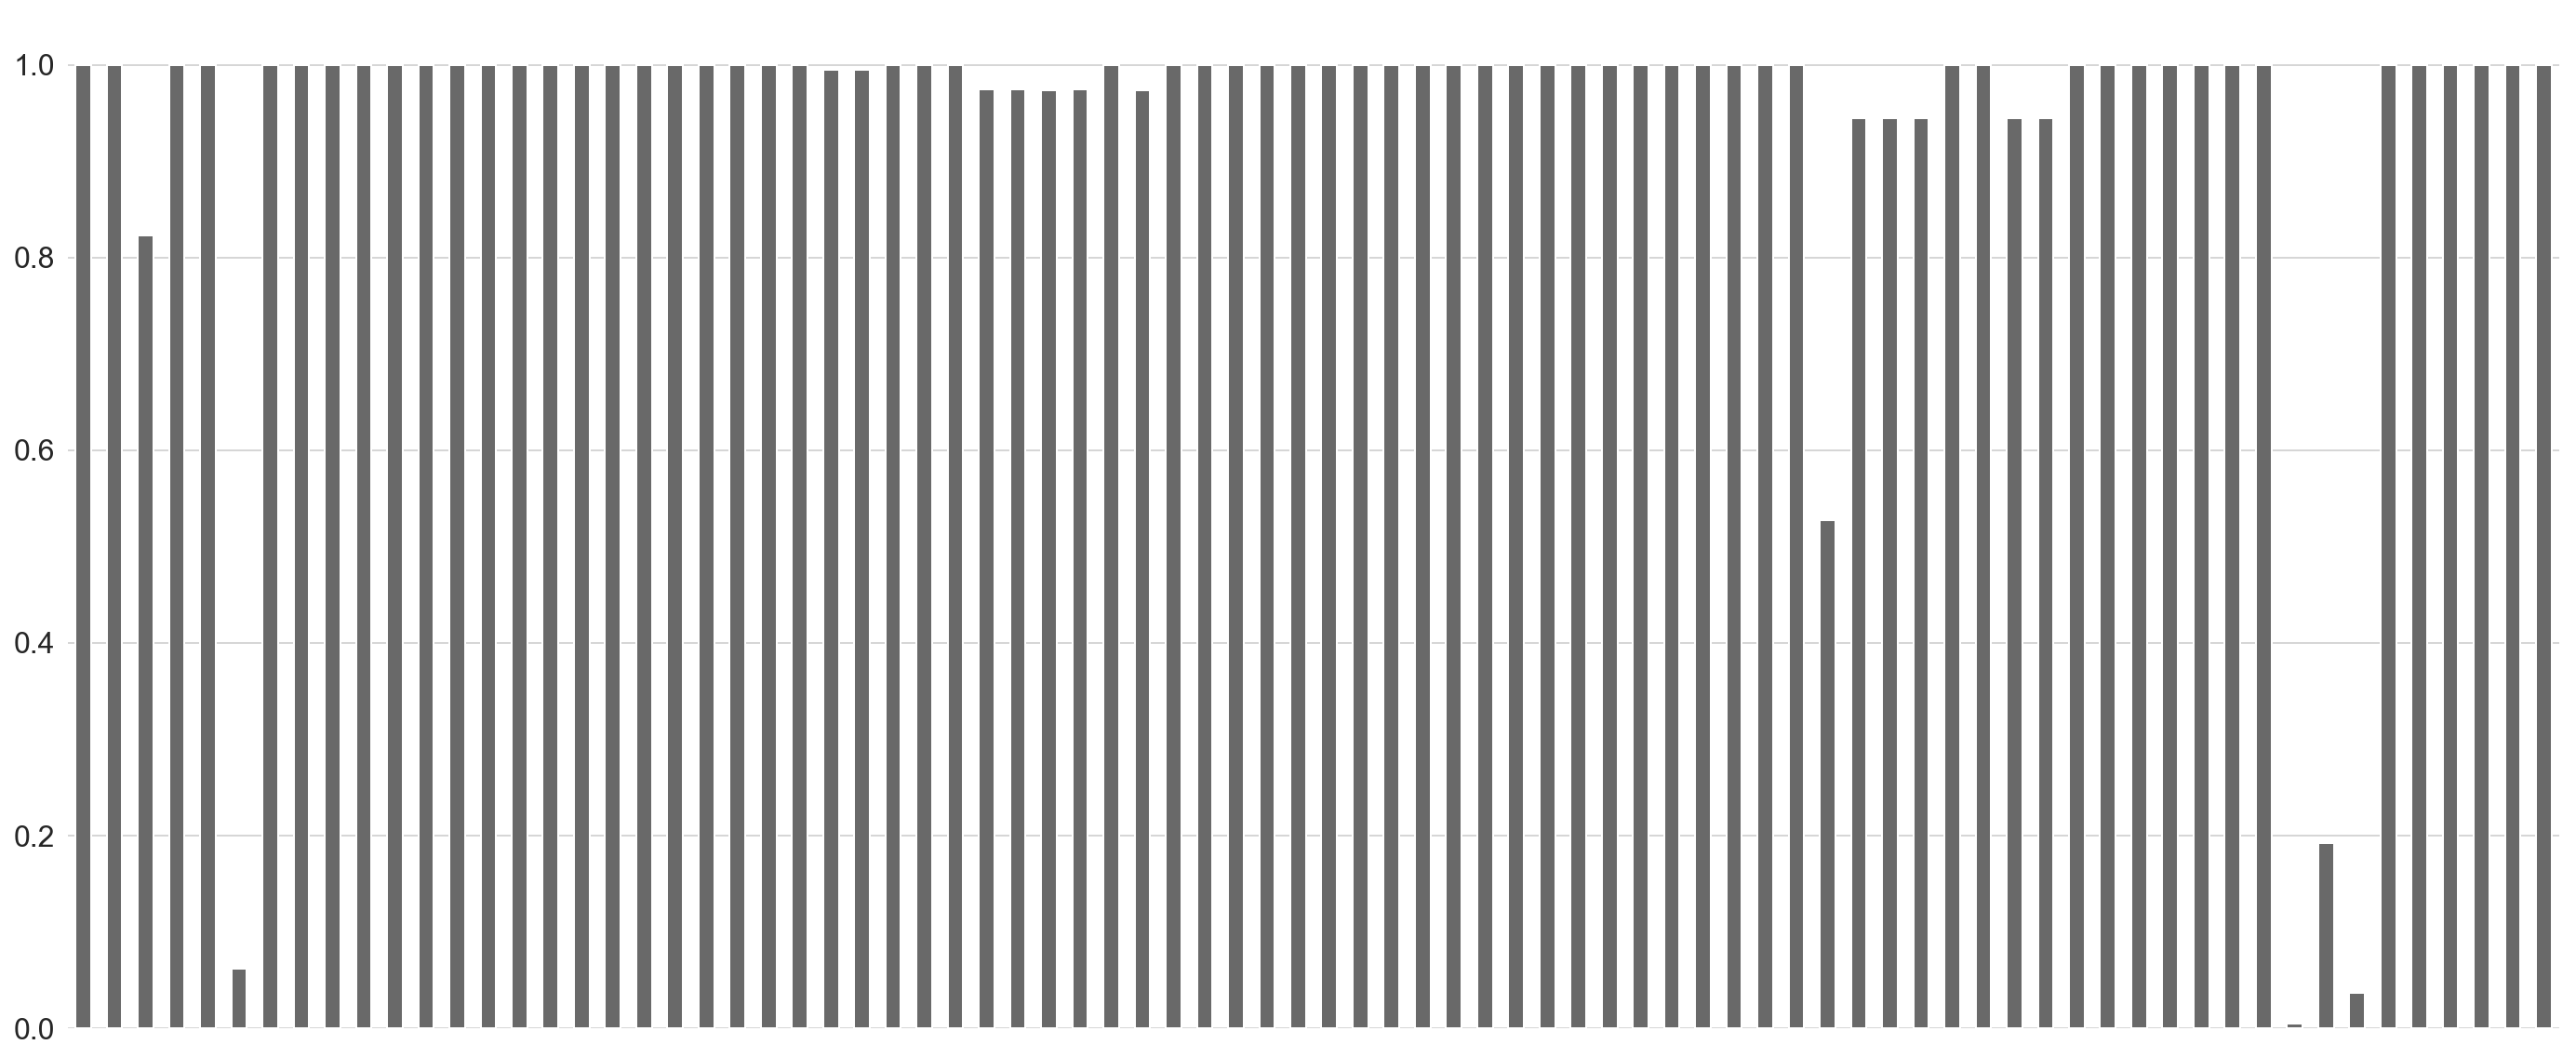

In [7]:
#Beginning EDA - getting a sense of what the data looks like
import missingno as msno

msno.bar(house)


In [8]:
house.loc[:,(house.isnull().sum() > house.shape[0]*.7)].columns


Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

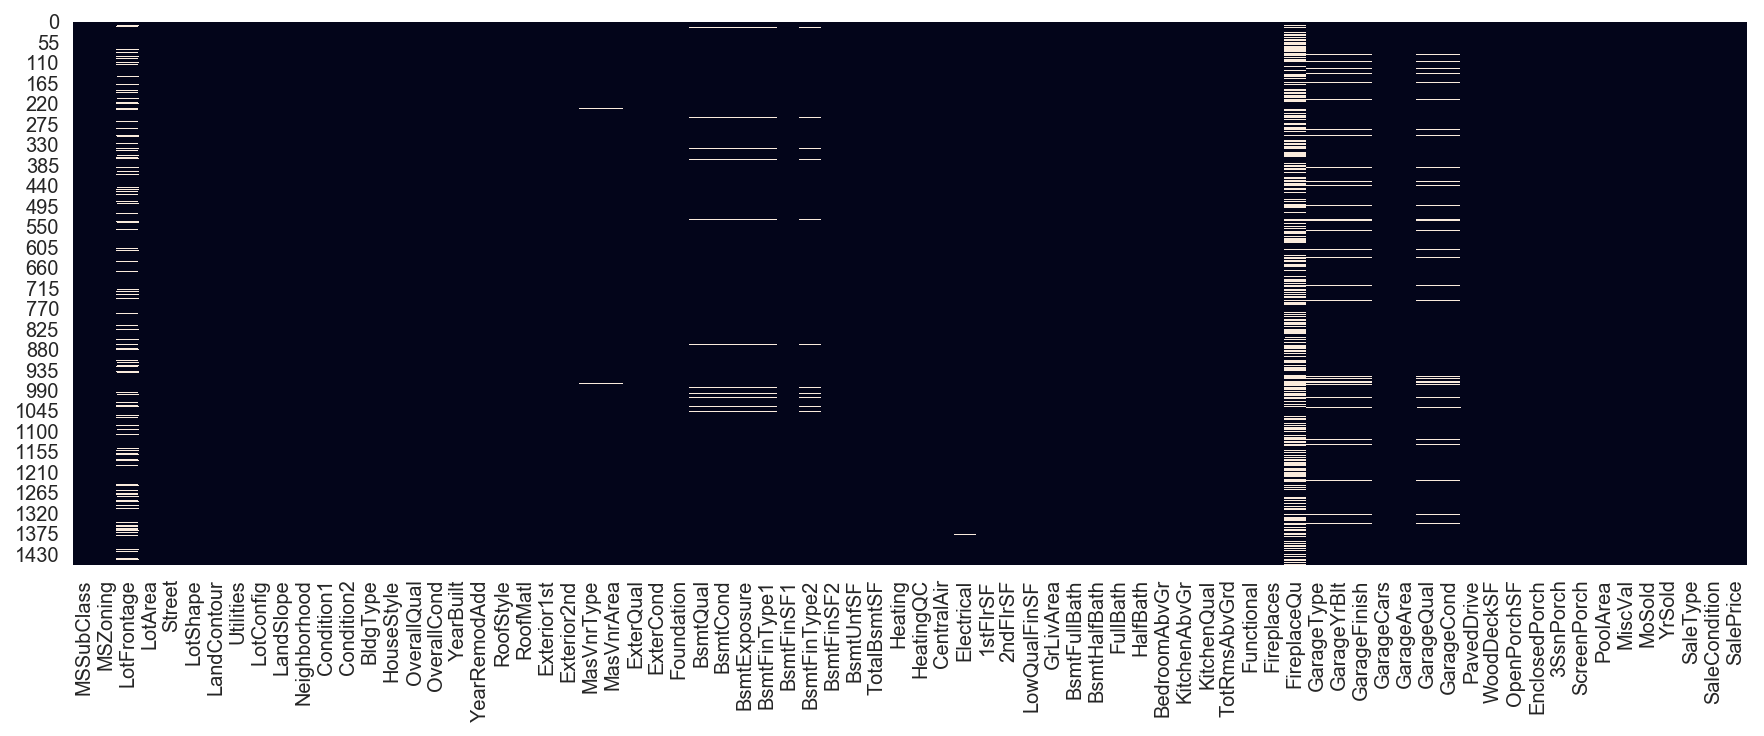

In [9]:
#the Alley, MiscFeature, PoolQC, and Fence columns containe very few values,
#which makes logical sense; will drop from consideration

house.drop(house.loc[:,(house.isnull().sum() > house.shape[0]*.7)].columns, axis=1, inplace=True)

plt.figure(figsize=(15,5))
sns.heatmap(house.isnull(), cbar=False)

In [10]:
#Two cols still missing significant data
#FireplaceQu is missing 47% - is categorical, may indicate no fireplace present
print(house.LotFrontage.isnull().sum() / house.shape[0])
print(house.FireplaceQu.isnull().sum() / house.shape[0])


0.1773972602739726
0.4726027397260274


In [11]:
#looks like the missing values are houses with no fireplaces
(house.Fireplaces == 0).sum() / house.shape[0]

0.4726027397260274

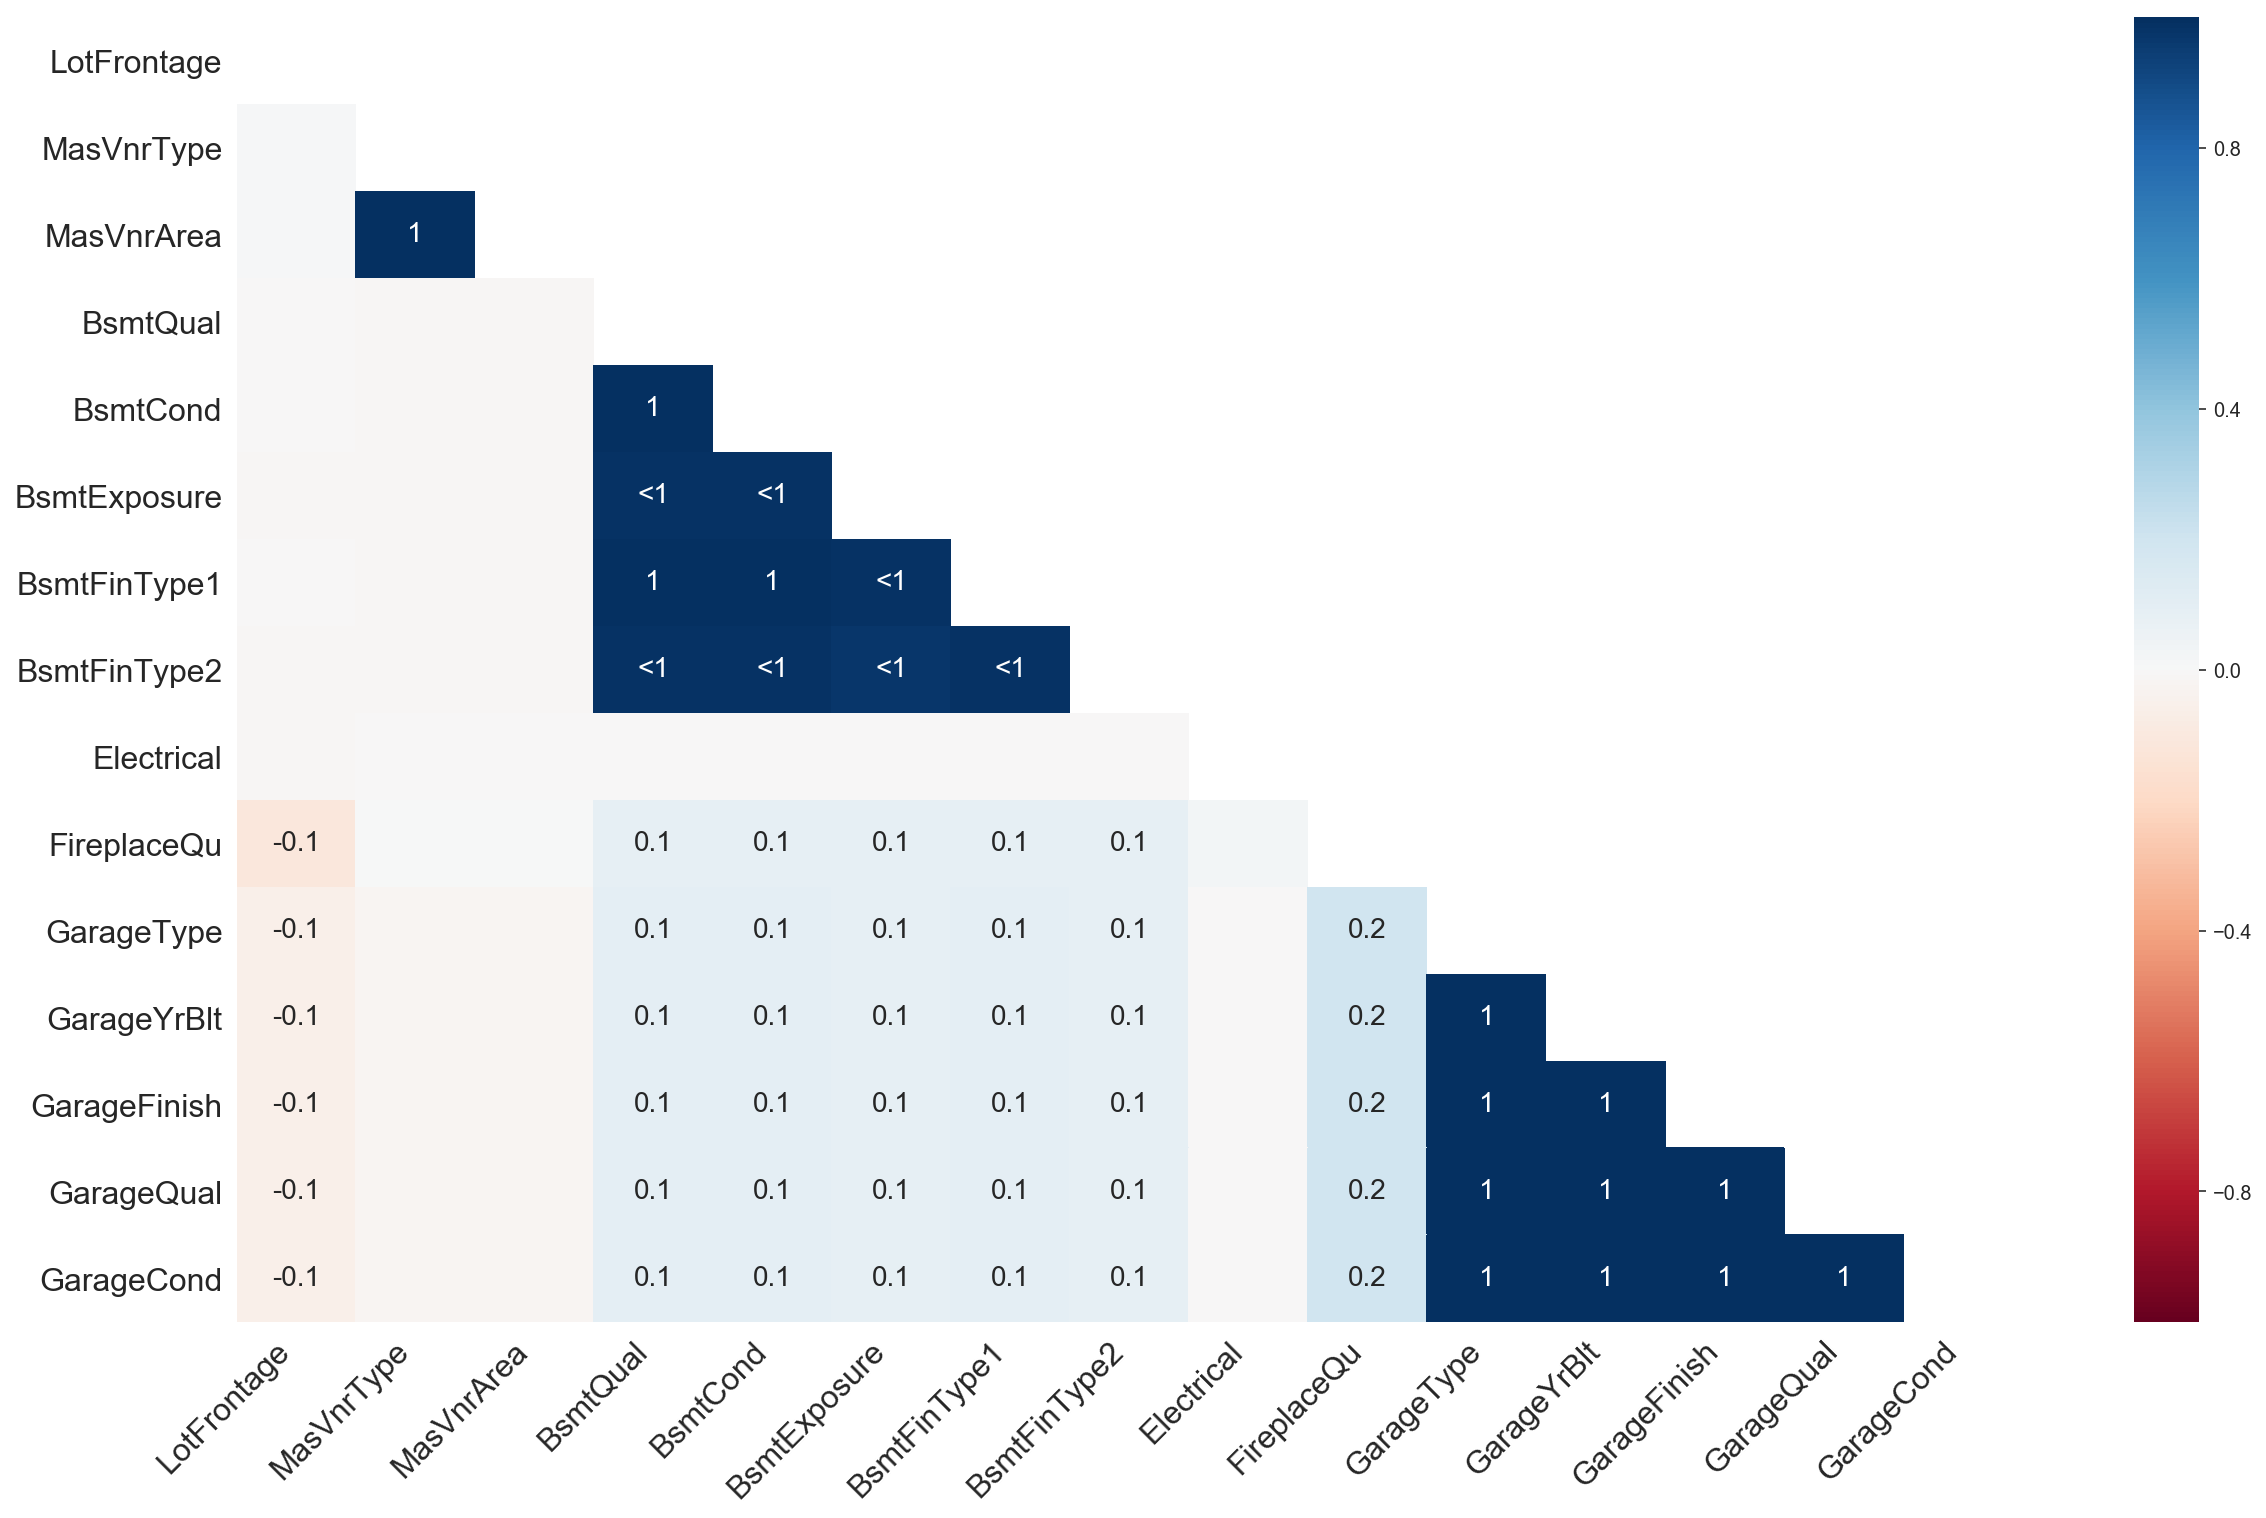

In [12]:
#checking correlations between missing values for sets of input issues
#correlations for basement & garage values - properties lacking those features
#no significant correlations for LotFrontage
msno.heatmap(house)

In [13]:
#pulling out column names for use in sorting features
fixed = pd.DataFrame(house.columns)
fixed.columns = ['Features']
fixed

Features
0      MSSubClass
1        MSZoning
2     LotFrontage
3         LotArea
4          Street
5        LotShape
6     LandContour
7       Utilities
8       LotConfig
9       LandSlope
10   Neighborhood
11     Condition1
12     Condition2
13       BldgType
14     HouseStyle
15    OverallQual
16    OverallCond
17      YearBuilt
18   YearRemodAdd
19      RoofStyle
20       RoofMatl
21    Exterior1st
22    Exterior2nd
23     MasVnrType
24     MasVnrArea
25      ExterQual
26      ExterCond
27     Foundation
28       BsmtQual
29       BsmtCond
..            ...
46   BsmtHalfBath
47       FullBath
48       HalfBath
49   BedroomAbvGr
50   KitchenAbvGr
51    KitchenQual
52   TotRmsAbvGrd
53     Functional
54     Fireplaces
55    FireplaceQu
56     GarageType
57    GarageYrBlt
58   GarageFinish
59     GarageCars
60     GarageArea
61     GarageQual
62     GarageCond
63     PavedDrive
64     WoodDeckSF
65    OpenPorchSF
66  EnclosedPorch
67      3SsnPorch
68    ScreenPorch
69       PoolArea
70        MiscVal
71         MoSold
72         YrSold
73       SaleType
74  SaleCondition
75      SalePrice

[76 rows x 1 columns]

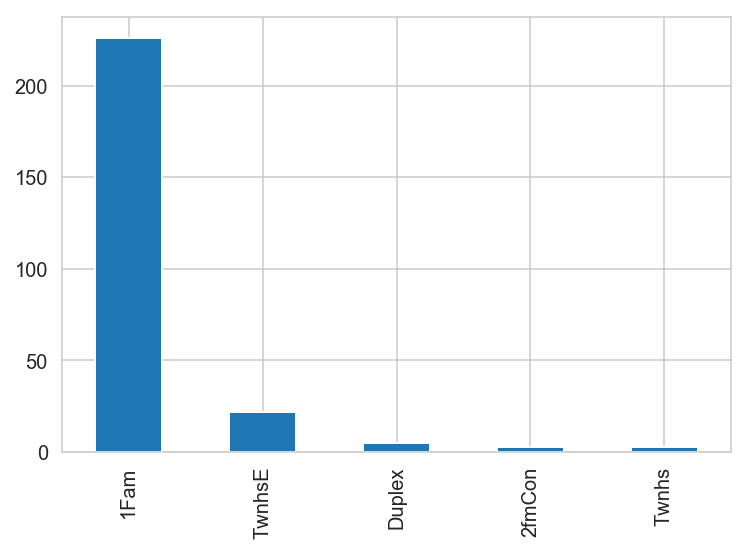

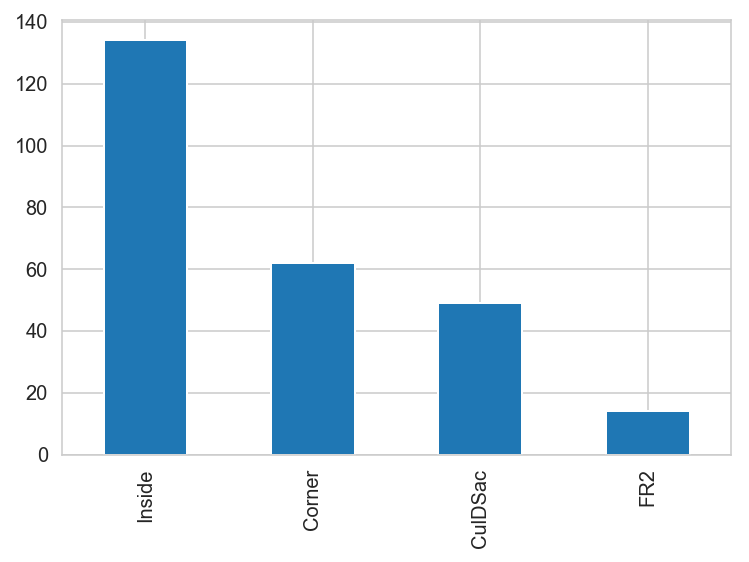

In [14]:
#investigating whether lot frontage missing values are due to dwelling type or lot config
check_LF = house[['BldgType','LotConfig','LotFrontage','SalePrice']][house.LotFrontage.isna()]
check_LF.BldgType.value_counts().plot(kind='bar')

plt.figure()
check_LF.LotConfig.value_counts().plot(kind='bar')
#mostly 1Fam homes on inside lots - doesn't necessarily tell us anything

In [15]:
#checking for apparent relationships between no LotFrontage info and price
LF = house[['LotConfig','BldgType','SalePrice','LotFrontage']]
LF['LotFrontage'].fillna(0,inplace=True)
LF.isna().sum()

LF['LF_color']=LF.LotFrontage.map(lambda x: 'number' if x > 0 else 'zero')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 720x864 with 0 Axes>

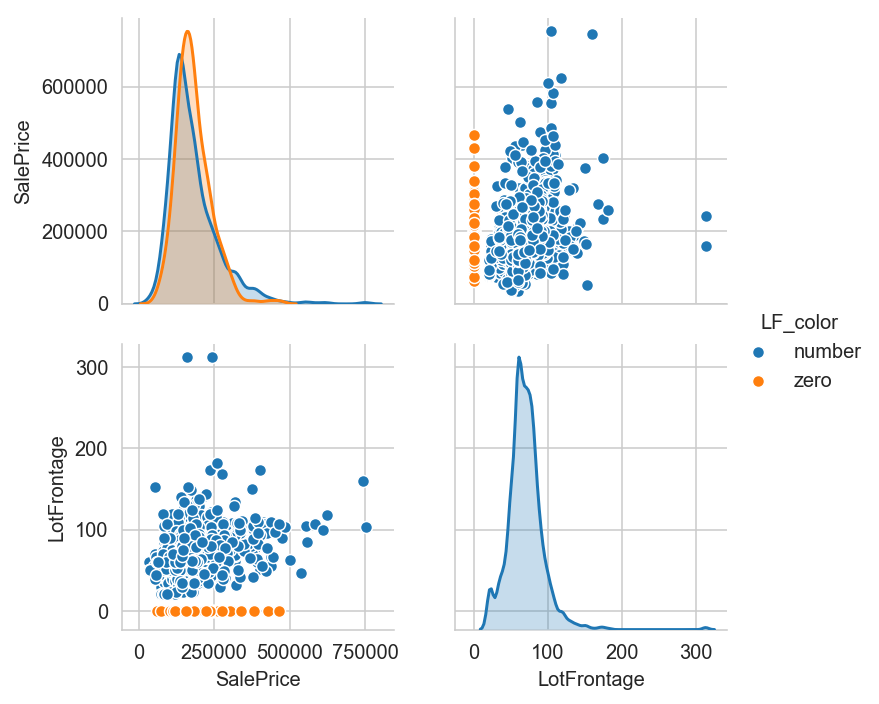

In [16]:
#checking for apparent relationships between no LotFrontage info and price
LF = house[['SalePrice','LotFrontage']]
LF['LotFrontage'].fillna(0,inplace=True)
LF.isna().sum()

LF['LF_color']=LF.LotFrontage.map(lambda x: 'number' if x > 0 else 'zero')

plt.figure(figsize=(10,12))
sns.pairplot(LF, hue='LF_color')

In [17]:
#looks like the missing values are spread across all prices
#Some linear relationship with price, but not particularly strong, so dropping column
house.drop(columns=['LotFrontage'],axis=1, inplace=True)

house.loc[:,house.isna().sum() > 0].isna().sum()

MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

### Splitting options on missing values
Will remove rows with small numbers missing, including basement options <br>
Will impute zero for Garage columns, as building a garage could be a valid option for part 2, so want to retain those <br>
Will leave FireplaceQu as nan, as would want to model with and without Fireplace separately, as the option for improvement would be to improve the fireplace, not add one

In [18]:
#remaining columns with significant null values have meaning as "none present" (basement, fireplace, garage)
#
#will drop other rows with missing values

house_na_small = house.loc[:,(house.isna().sum() > 0) & (house.isna().sum() < 40)]
house_na_small.dropna(inplace=True)
house_na_small.isna().sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
dtype: int64

In [19]:
house = house.iloc[house_na_small.index]


In [20]:
house.loc[:,house.isna().sum() > 0].isna().sum()

FireplaceQu     657
GarageType       74
GarageYrBlt      74
GarageFinish     74
GarageQual       74
GarageCond       74
dtype: int64

In [21]:
#adding zeros for Garage columns
garage_columns = [column for column in house.columns if 'Garage' in column]
house[garage_columns] = house[garage_columns].fillna(0)

#for FireplaceQu, will imput np.nan as a double check
house.FireplaceQu = house.FireplaceQu.fillna(np.nan)


house.loc[:,house.isna().sum() > 0].isna().sum()

FireplaceQu    657
dtype: int64

In [22]:
house.shape

(1412, 75)

In [23]:
#looking at correlations
#maintaining awareness that this calculation may not be relevant for categoricals represented as numbers
#for example: MSSubClass, time variables
house_corrs_init = house.drop('SalePrice', axis=1).corrwith(house.SalePrice).sort_values(ascending=False)
test = pd.DataFrame(house_corrs_init)
test.columns = ['correlation']
test

correlation
OverallQual          0.787
GrLivArea            0.711
GarageCars           0.642
GarageArea           0.621
1stFlrSF             0.615
TotalBsmtSF          0.611
FullBath             0.576
TotRmsAbvGrd         0.546
YearBuilt            0.519
YearRemodAdd         0.500
MasVnrArea           0.475
Fireplaces           0.463
BsmtFinSF1           0.369
2ndFlrSF             0.318
WoodDeckSF           0.317
OpenPorchSF          0.305
HalfBath             0.270
LotArea              0.265
GarageYrBlt          0.253
BsmtFullBath         0.209
BsmtUnfSF            0.189
BedroomAbvGr         0.170
ScreenPorch          0.108
PoolArea             0.093
3SsnPorch            0.047
MoSold               0.042
MiscVal             -0.013
BsmtFinSF2          -0.020
BsmtHalfBath        -0.022
YrSold              -0.023
LowQualFinSF        -0.028
MSSubClass          -0.082
OverallCond         -0.094
KitchenAbvGr        -0.106
EnclosedPorch       -0.134

In [24]:
test_low_corr_columns = list(test[test.correlation < 0.3].index)
for x in ['MSSubClass','MoSold','YrSold']:
    test_low_corr_columns.remove(x)

test_low_corr_columns

['HalfBath',
 'LotArea',
 'GarageYrBlt',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'ScreenPorch',
 'PoolArea',
 '3SsnPorch',
 'MiscVal',
 'BsmtFinSF2',
 'BsmtHalfBath',
 'LowQualFinSF',
 'OverallCond',
 'KitchenAbvGr',
 'EnclosedPorch']

In [25]:
house.drop(columns=test_low_corr_columns,axis=1,inplace=True)
house.shape

(1412, 59)

__Selecting Fixed Columns__

The three cells below were run once, to create a saved set of selected columns

In [26]:
#pulling out column names for use in sorting features

# fixed = pd.DataFrame(house.columns)
# fixed.columns = ['Features']
# fixed

In [27]:
#Generating file to store which variables are fixed
#Commenting out, as will not need to run multiple times
#Will make any revisions to assignments directly in text file

#fix_var = []
# for index in range(len(fixed['Features'])):
#     print (fixed.Features.loc[index])
#     index_val = input("Fixed or not? Enter 1 for fixed or 0 for not")
#     fix_var.append(index_val)

In [28]:
# fixed['fix_var']=fix_var
# fixed
# fixed.to_csv('./fixed_vars.csv')

In [5]:
#in fixed_variable file, 1=fixed, 0=renovatable
fixed_variables = pd.read_csv('./datasets/fixed_vars.csv')
fixed_variables.head()

Features  fix_var
0   MSSubClass        1
1     MSZoning        1
2       Street        1
3     LotShape        1
4  LandContour        1

In [30]:
#pull the fixed columns out of house dataframe
fixed_house = house[list(fixed_variables.Features[(fixed_variables.fix_var==1)])]
fixed_house.head()

MSSubClass MSZoning Street LotShape LandContour Utilities LotConfig  \
0          60       RL   Pave      Reg         Lvl    AllPub    Inside   
1          20       RL   Pave      Reg         Lvl    AllPub       FR2   
2          60       RL   Pave      IR1         Lvl    AllPub    Inside   
3          70       RL   Pave      IR1         Lvl    AllPub    Corner   
4          60       RL   Pave      IR1         Lvl    AllPub       FR2   

  LandSlope Neighborhood Condition1  ... GrLivArea TotRmsAbvGrd Fireplaces  \
0       Gtl      CollgCr       Norm  ...      1710            8          0   
1       Gtl      Veenker      Feedr  ...      1262            6          1   
2       Gtl      CollgCr       Norm  ...      1786            6          1   
3       Gtl      Crawfor       Norm  ...      1717            7          1   
4       Gtl      NoRidge       Norm  ...      2198            9          1   

   GarageType  GarageCars GarageArea SaleType YrSold SaleCondition  SalePrice  
0      Attchd           2        548       WD   2008        Normal     208500  
1      Attchd           2        460       WD   2007        Normal     181500  
2      Attchd           2        608       WD   2008        Normal     223500  
3      Detchd           3        642       WD   2006       Abnorml     140000  
4      Attchd           3        836       WD   2008        Normal     250000  

[5 rows x 32 columns]

In [31]:
#what type of features are the numeric variables?
fixed_house._get_numeric_data().columns

Index(['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'YrSold', 'SalePrice'],
      dtype='object')

__Categorical:__ 'MSSubClass'

__Years/Months:__ 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'

__Continuous:__ 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GrLivArea', 'GarageArea','SalePrice','MiscVal', 'Fireplaces', 'GarageCars', 'GarageArea'

Included counters (how many fireplaces, cars in the garage, etc) as continuous because there is a true numeric distance between the values.

In [32]:
#creatiing list of time variables
fixed_times = ['YearBuilt', 'YrSold', 'YearRemodAdd']

#creating list of continuous variables
fixed_continuous = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces',
                    'GarageCars', 'GarageArea', 'SalePrice']

#object variables are categorical of some sort
fixed_categorical = list(fixed_house.select_dtypes('object').columns)
fixed_categorical.append('MSSubClass')

## Looking into continuous variables
What is the data like for these features?<br>
What is the distribuation/skew?<br>
Are there significant outliers?<br>


 mu = 182507.02 and sigma = 79242.34



<>:13: DeprecationWarning: invalid escape sequence \m


Text(0.5, 1.0, 'SalePrice distribution')

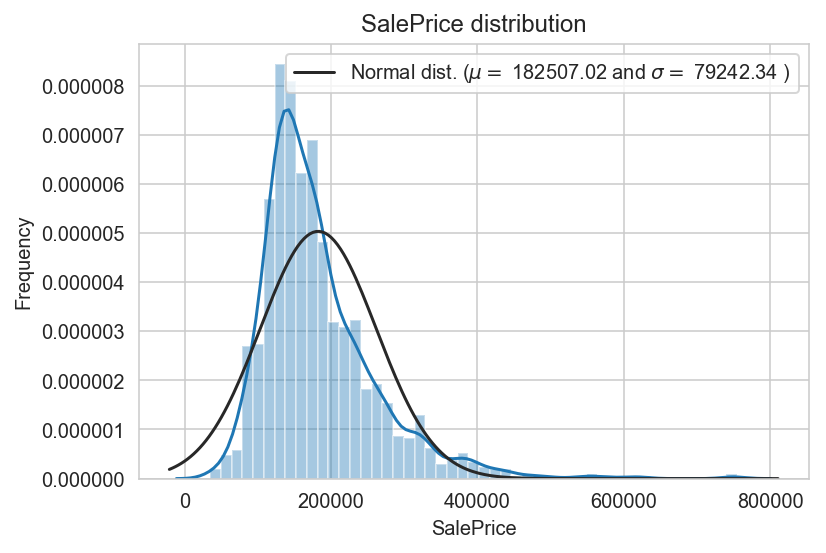

In [33]:
#first checking target (SalePrice)

target = fixed_house.SalePrice

sns.distplot(target , fit=stats.norm);


# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


In [34]:
#looks like there are very few high value houses - may be worth removing them 
#may not have enough data to extend model into this region accurately
fixed_house['SalePrice'].nlargest(10)

691     755000
1182    745000
1169    625000
898     611657
803     582933
1046    556581
440     555000
769     538000
178     501837
798     485000
Name: SalePrice, dtype: int64

In [35]:
fixed_house[fixed_house['SalePrice'] > fixed_house['SalePrice'].quantile(.99)].shape[0]

15

In [36]:
fixed_house[np.abs(fixed_house.SalePrice-fixed_house.SalePrice.mean()) 
            >= (3*fixed_house.SalePrice.std())].SalePrice.sort_values()


664     423000
1142    424870
389     426000
496     430000
349     437154
58      438780
473     440000
527     446261
591     451950
1373    466500
185     475000
798     485000
178     501837
769     538000
440     555000
1046    556581
803     582933
898     611657
1169    625000
1182    745000
691     755000
Name: SalePrice, dtype: int64


 mu = 182507.02 and sigma = 79242.34



Text(0.5, 1.0, 'SalePrice distribution')

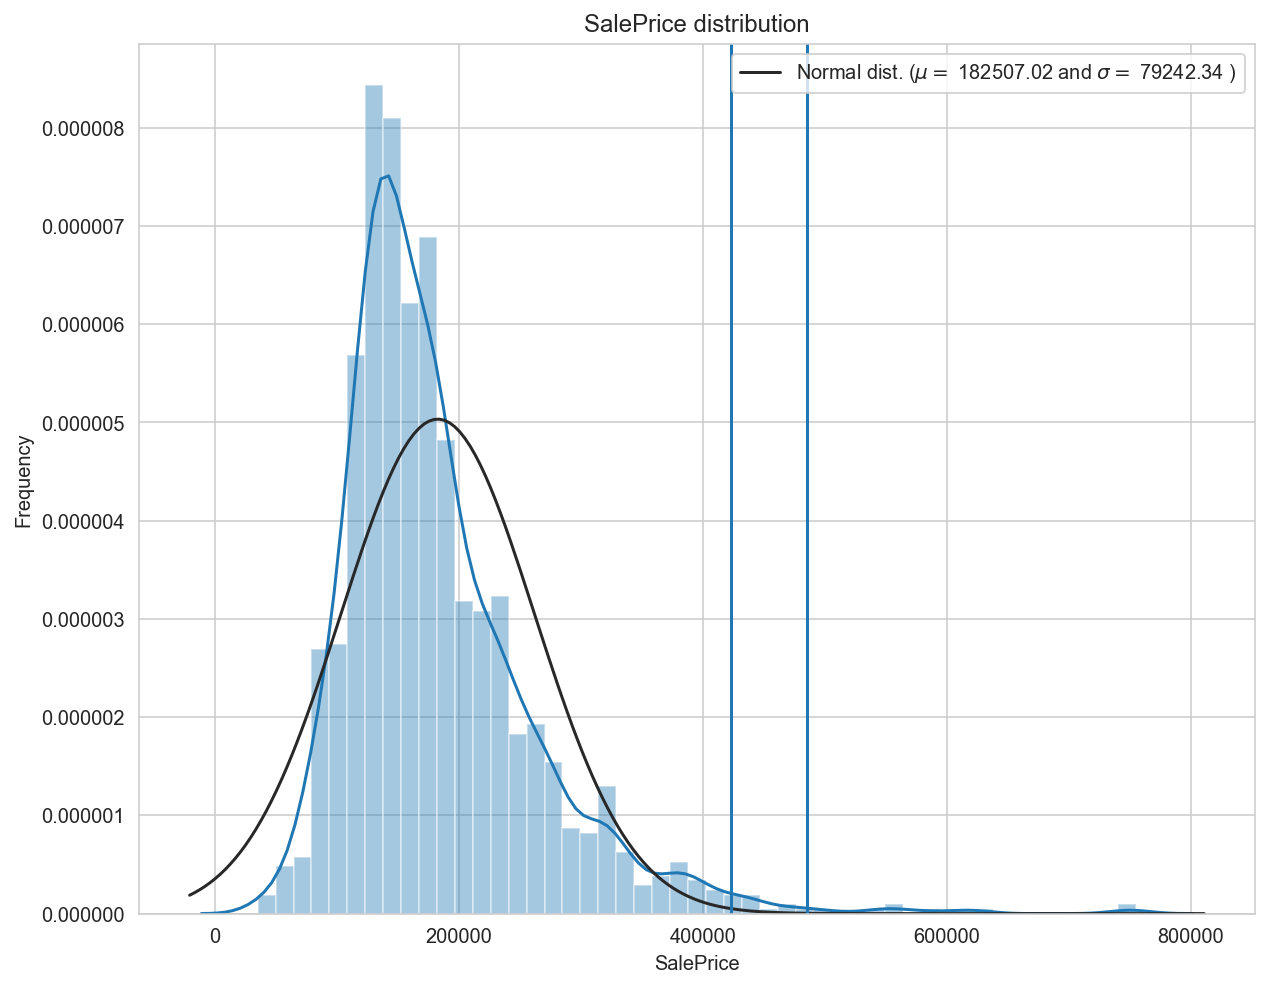

In [37]:
#There are 15 houses in the top 1% of SalePrice, and 21 outside 3 standard deviations
#Adding lines at the cutoff points on the histogram
target = fixed_house.SalePrice

plt.figure(figsize=(10,8))
sns.distplot(target , fit=stats.norm);
plt.axvline(x=485000)
plt.axvline(x=423000)


# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


In [38]:
indices = list(fixed_house[fixed_house['SalePrice'] > fixed_house['SalePrice'].quantile(.99)].index)

In [39]:
#removing values above the 99 percentile line, as the curve of the data is relatively contiuous through there
fixed_house.drop(indices,inplace=True)
house.drop(indices,inplace=True)

print(fixed_house.shape, house.shape)

(1397, 32) (1397, 59)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



 mu = 178571.36 and sigma = 69186.61



Text(0.5, 1.0, 'SalePrice distribution')

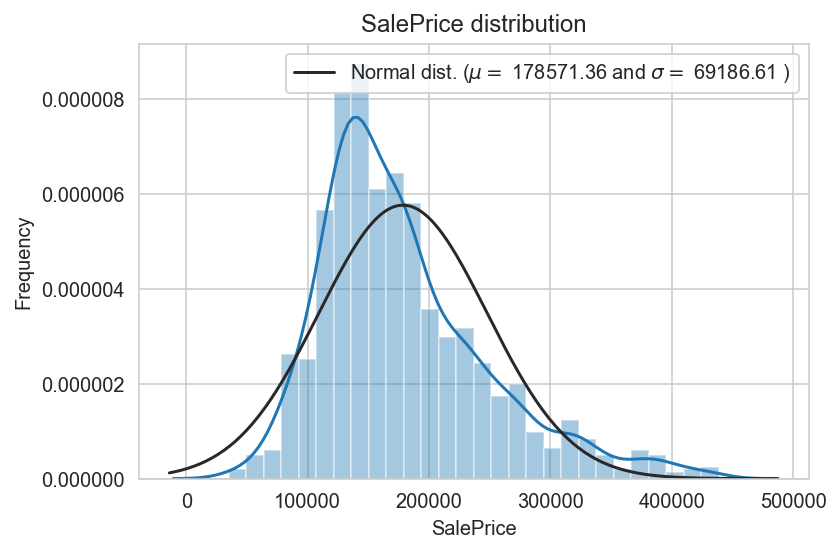

In [40]:
#first checking target (SalePrice)

target = fixed_house.SalePrice

sns.distplot(target , fit=stats.norm);


# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


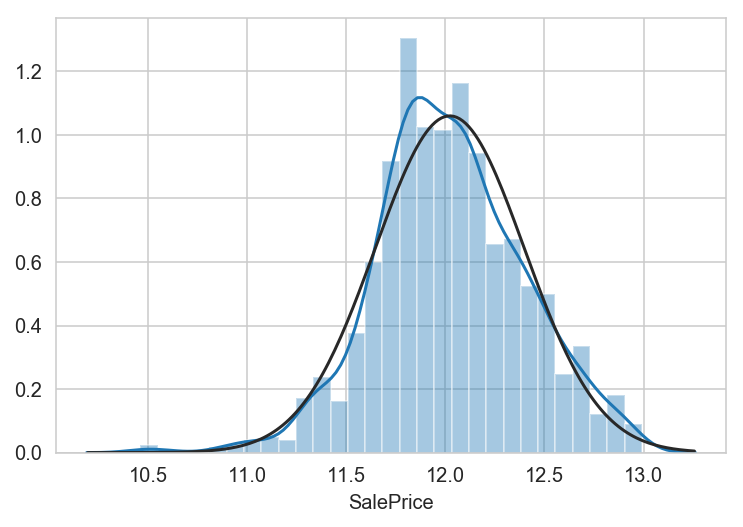

In [41]:
#target is clearly right skewed, much improved by using log(target)
#but price hard to interpret as log
sns.distplot(np.log(target) , fit=stats.norm)


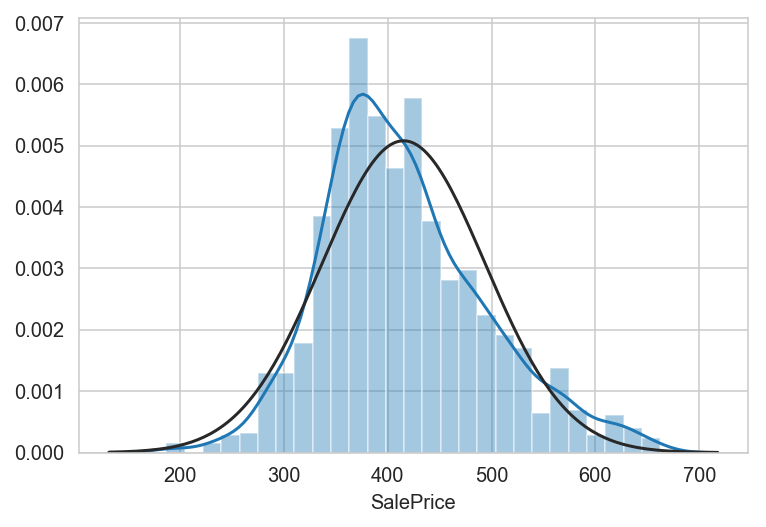

In [42]:
#sqrt also helps, but log looks better
sns.distplot(np.sqrt(target), fit=stats.norm)

In [43]:
#adding log(target) column to be able to test which works better in models
# fixed_house['LogSalePrice'] = np.log(target)
# fixed_continuous.append('LogSalePrice')


In [44]:
#looking at continuous features
fixed_house[fixed_continuous].columns

Index(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'SalePrice'],
      dtype='object')

In [45]:
#square footage is in multiple different features; adding total SF variable
fixed_house['Total_SF'] = (fixed_house['TotalBsmtSF'] 
                                + fixed_house['1stFlrSF'] + fixed_house['2ndFlrSF'])

#add new feature to continuous columns list
fixed_continuous.append('Total_SF')

fixed_house.columns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageType', 'GarageCars', 'GarageArea', 'SaleType', 'YrSold',
       'SaleCondition', 'SalePrice', 'Total_SF'],
      dtype='object')

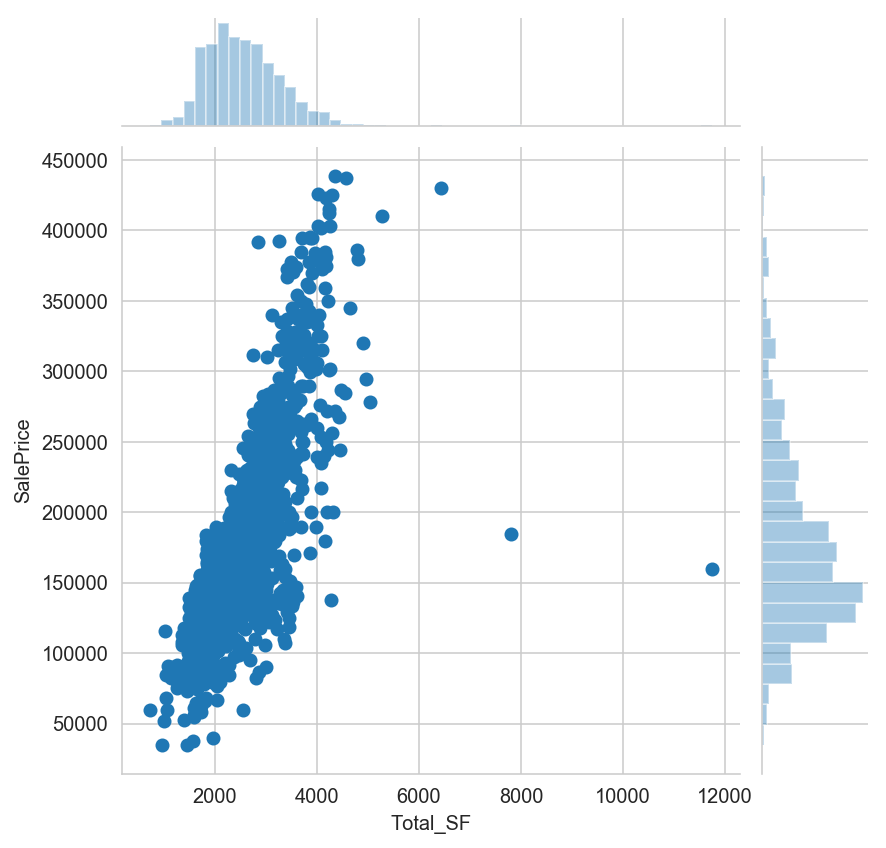

In [46]:
sns.jointplot(fixed_house['Total_SF'],fixed_house['SalePrice'])

In [47]:
#looking at two clear outliers with low values, high sale price
#plus looks like very few properties over 6000sqft
fixed_house[(fixed_house['Total_SF'] > 6000)]


MSSubClass MSZoning Street LotShape LandContour Utilities LotConfig  \
496           20       RL   Pave      IR1         Lvl    AllPub    Inside   
523           60       RL   Pave      IR1         Bnk    AllPub    Inside   
1298          60       RL   Pave      IR3         Bnk    AllPub    Corner   

     LandSlope Neighborhood Condition1  ... TotRmsAbvGrd Fireplaces  \
496        Gtl      NoRidge       Norm  ...           10          1   
523        Gtl      Edwards       PosN  ...           11          1   
1298       Gtl      Edwards      Feedr  ...           12          3   

     GarageType  GarageCars  GarageArea SaleType YrSold SaleCondition  \
496      Attchd           2         546       WD   2007        Normal   
523     BuiltIn           3         884      New   2007       Partial   
1298     Attchd           2        1418      New   2008       Partial   

     SalePrice  Total_SF  
496     430000      6428  
523     184750      7814  
1298    160000     11752  

[3 rows x 33 columns]

(1394, 33) (1394, 59)


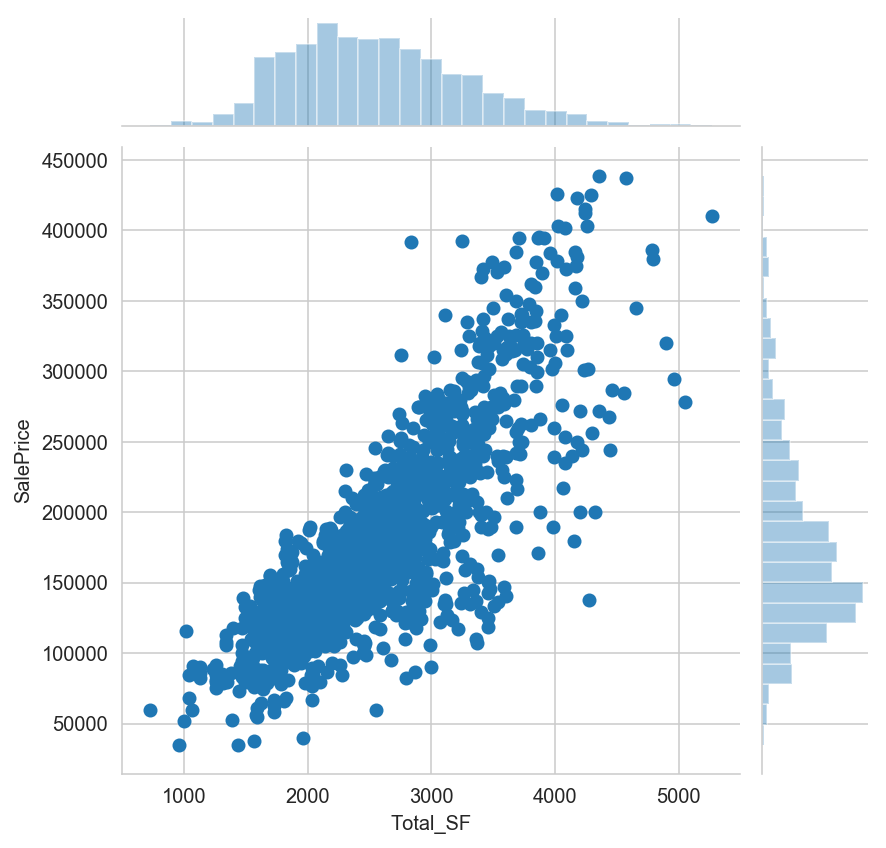

In [48]:
#romving all 5,too few values to model in this range
house.drop(fixed_house.loc[(fixed_house['Total_SF'] > 6000)].index,inplace=True)
fixed_house.drop(fixed_house.loc[(fixed_house['Total_SF'] > 6000)].index,inplace=True)

#number of rows should be the same
print(fixed_house.shape, house.shape)

sns.jointplot(fixed_house['Total_SF'],fixed_house['SalePrice'])

In [49]:
#checking skew for all categorical features
skew_list = [stats.skew(list(fixed_house[col])) for col in fixed_continuous]

counter = 0
for col in fixed_continuous:
    print (col,'\t', skew_list[counter])
    counter+=1

TotalBsmtSF 	 0.6601301608875502
1stFlrSF 	 0.7342424826080659
2ndFlrSF 	 0.7413254686205911
GrLivArea 	 0.7484359420054119
TotRmsAbvGrd 	 0.6253184826296874
Fireplaces 	 0.6247285795975308
GarageCars 	 -0.3243129326379309
GarageArea 	 0.13859281322003544
SalePrice 	 1.0732123594766758
Total_SF 	 0.5386425682448831


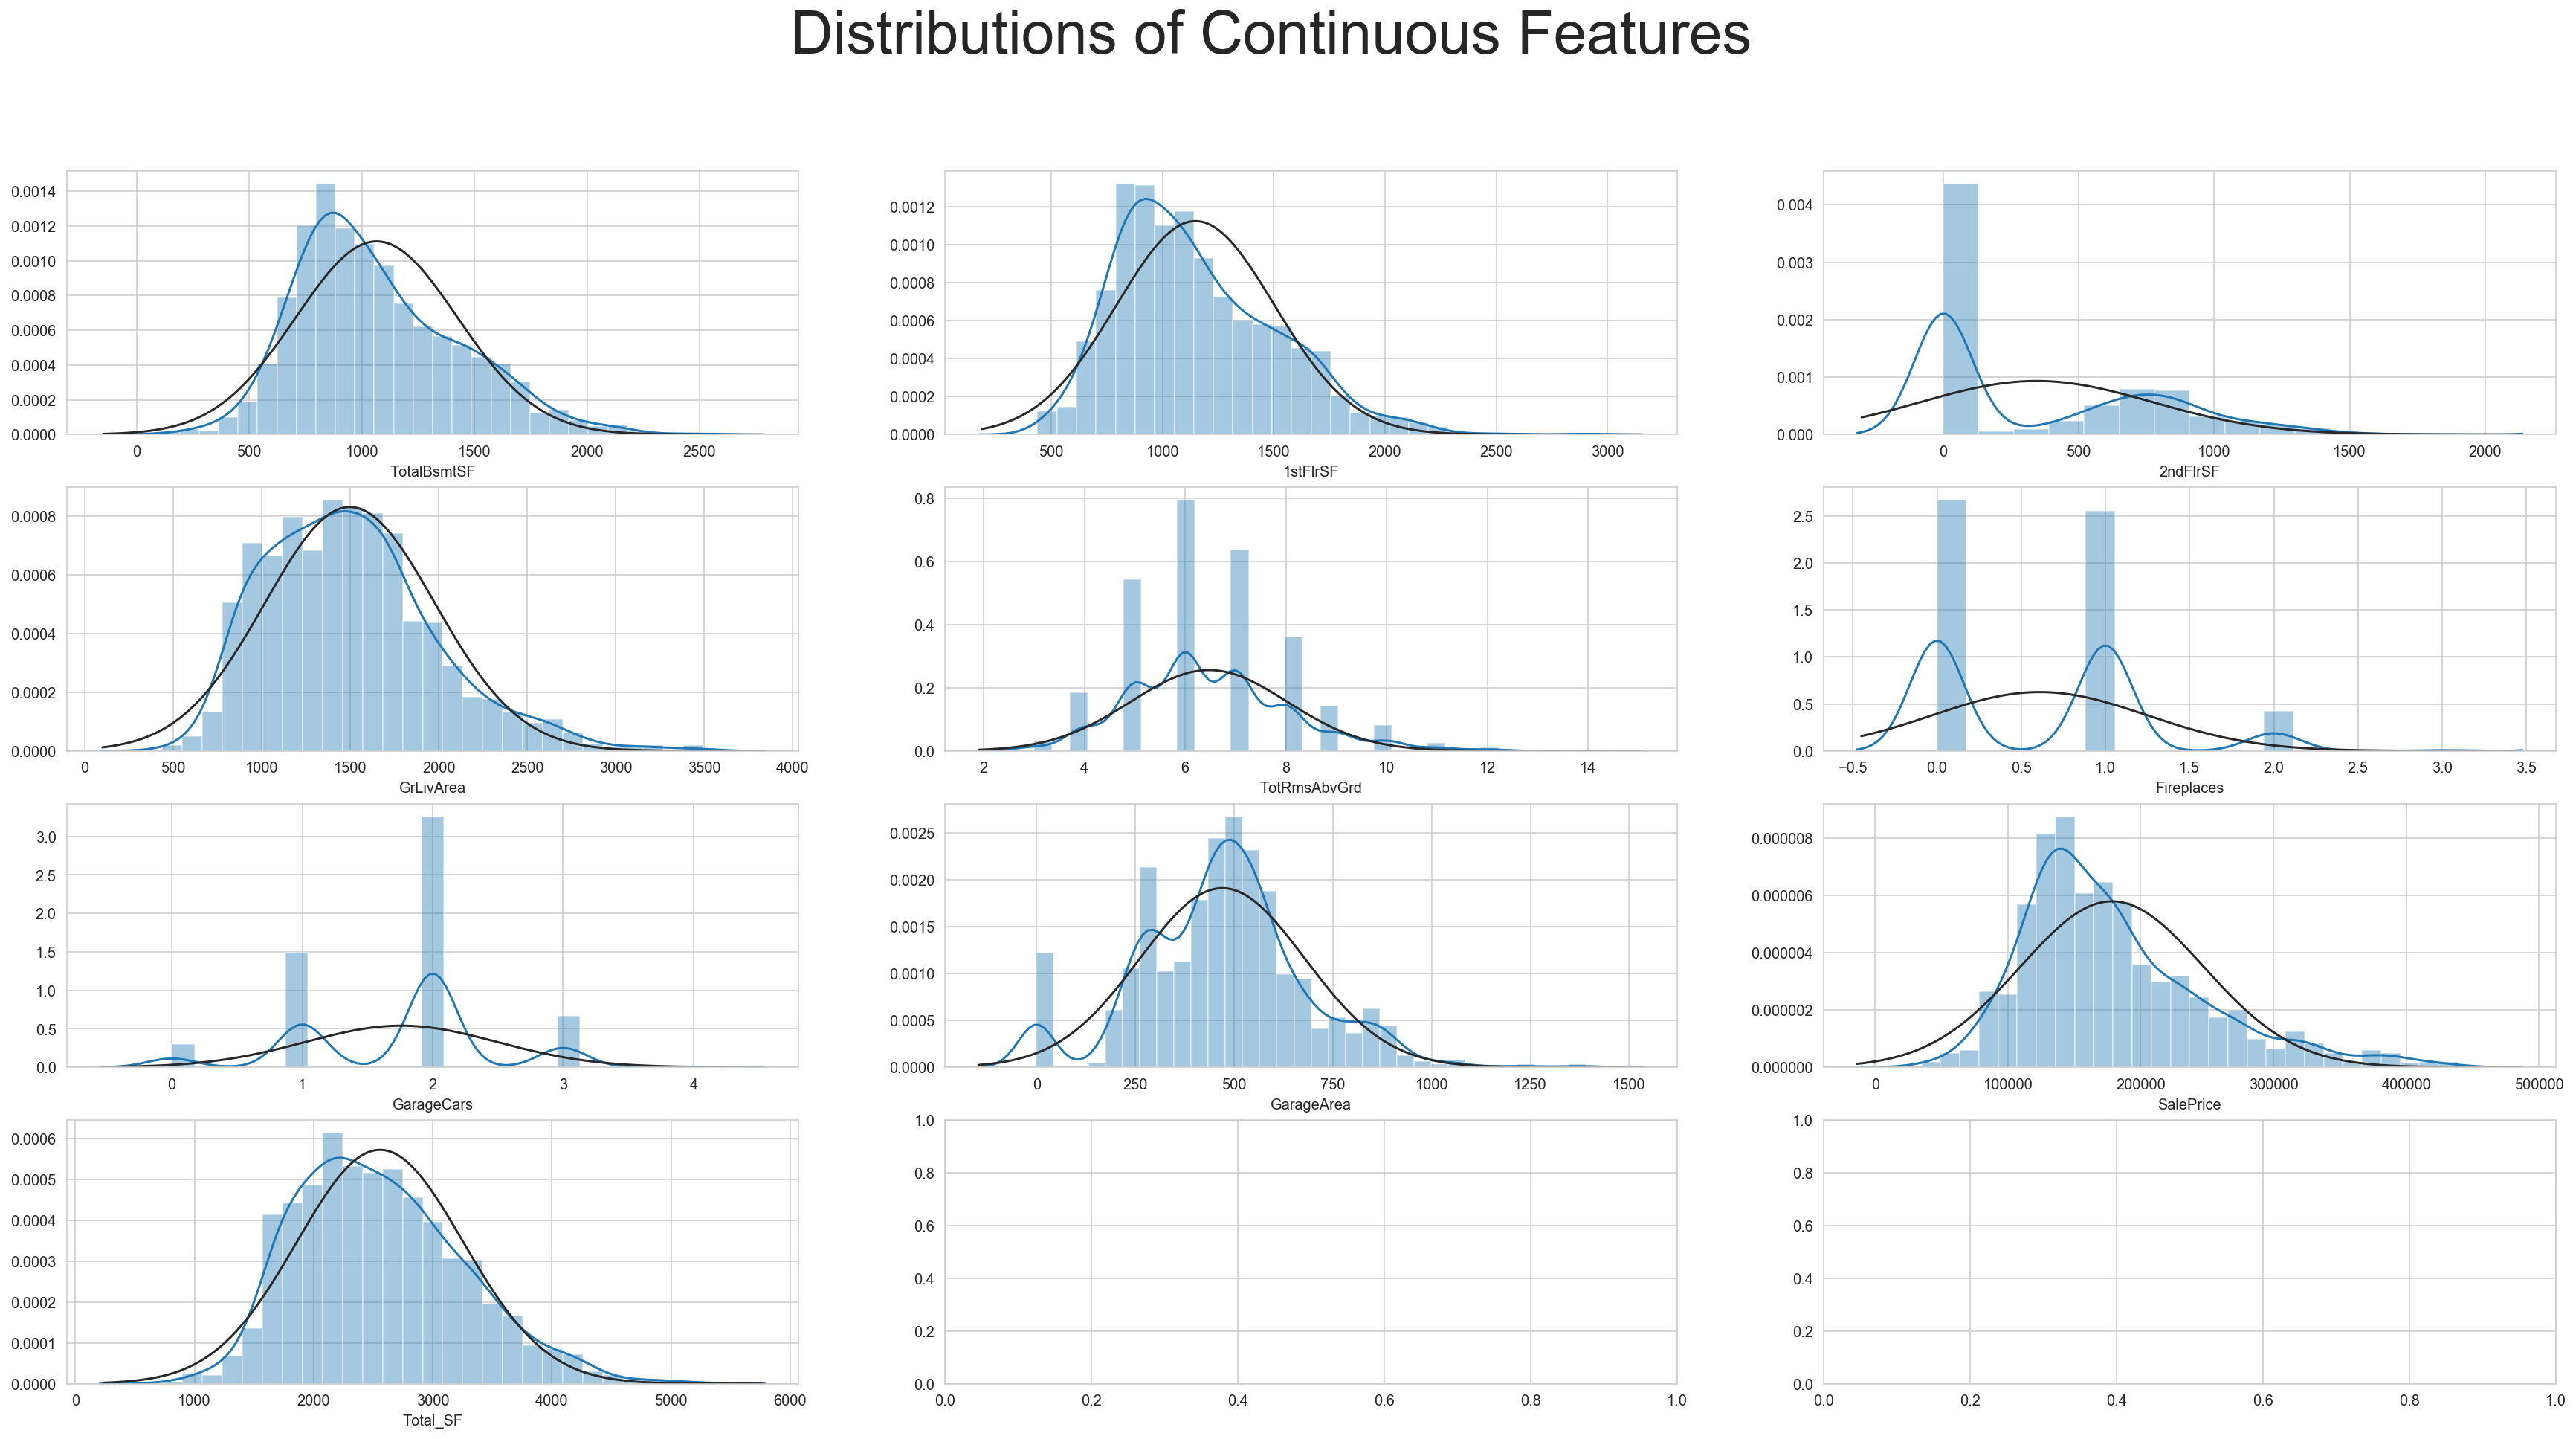

In [50]:
#looking at distributions for all continuous features
fig, axes = plt.subplots(4,3, figsize=(30,15))

fig.suptitle('Distributions of Continuous Features',fontsize=40)

col=0
row=0

for column in fixed_continuous:
    sns.distplot(fixed_house[column], fit=stats.norm, ax=axes[row][col])
    if col == 2:
        row +=1
        col = 0
    else:
        col += 1





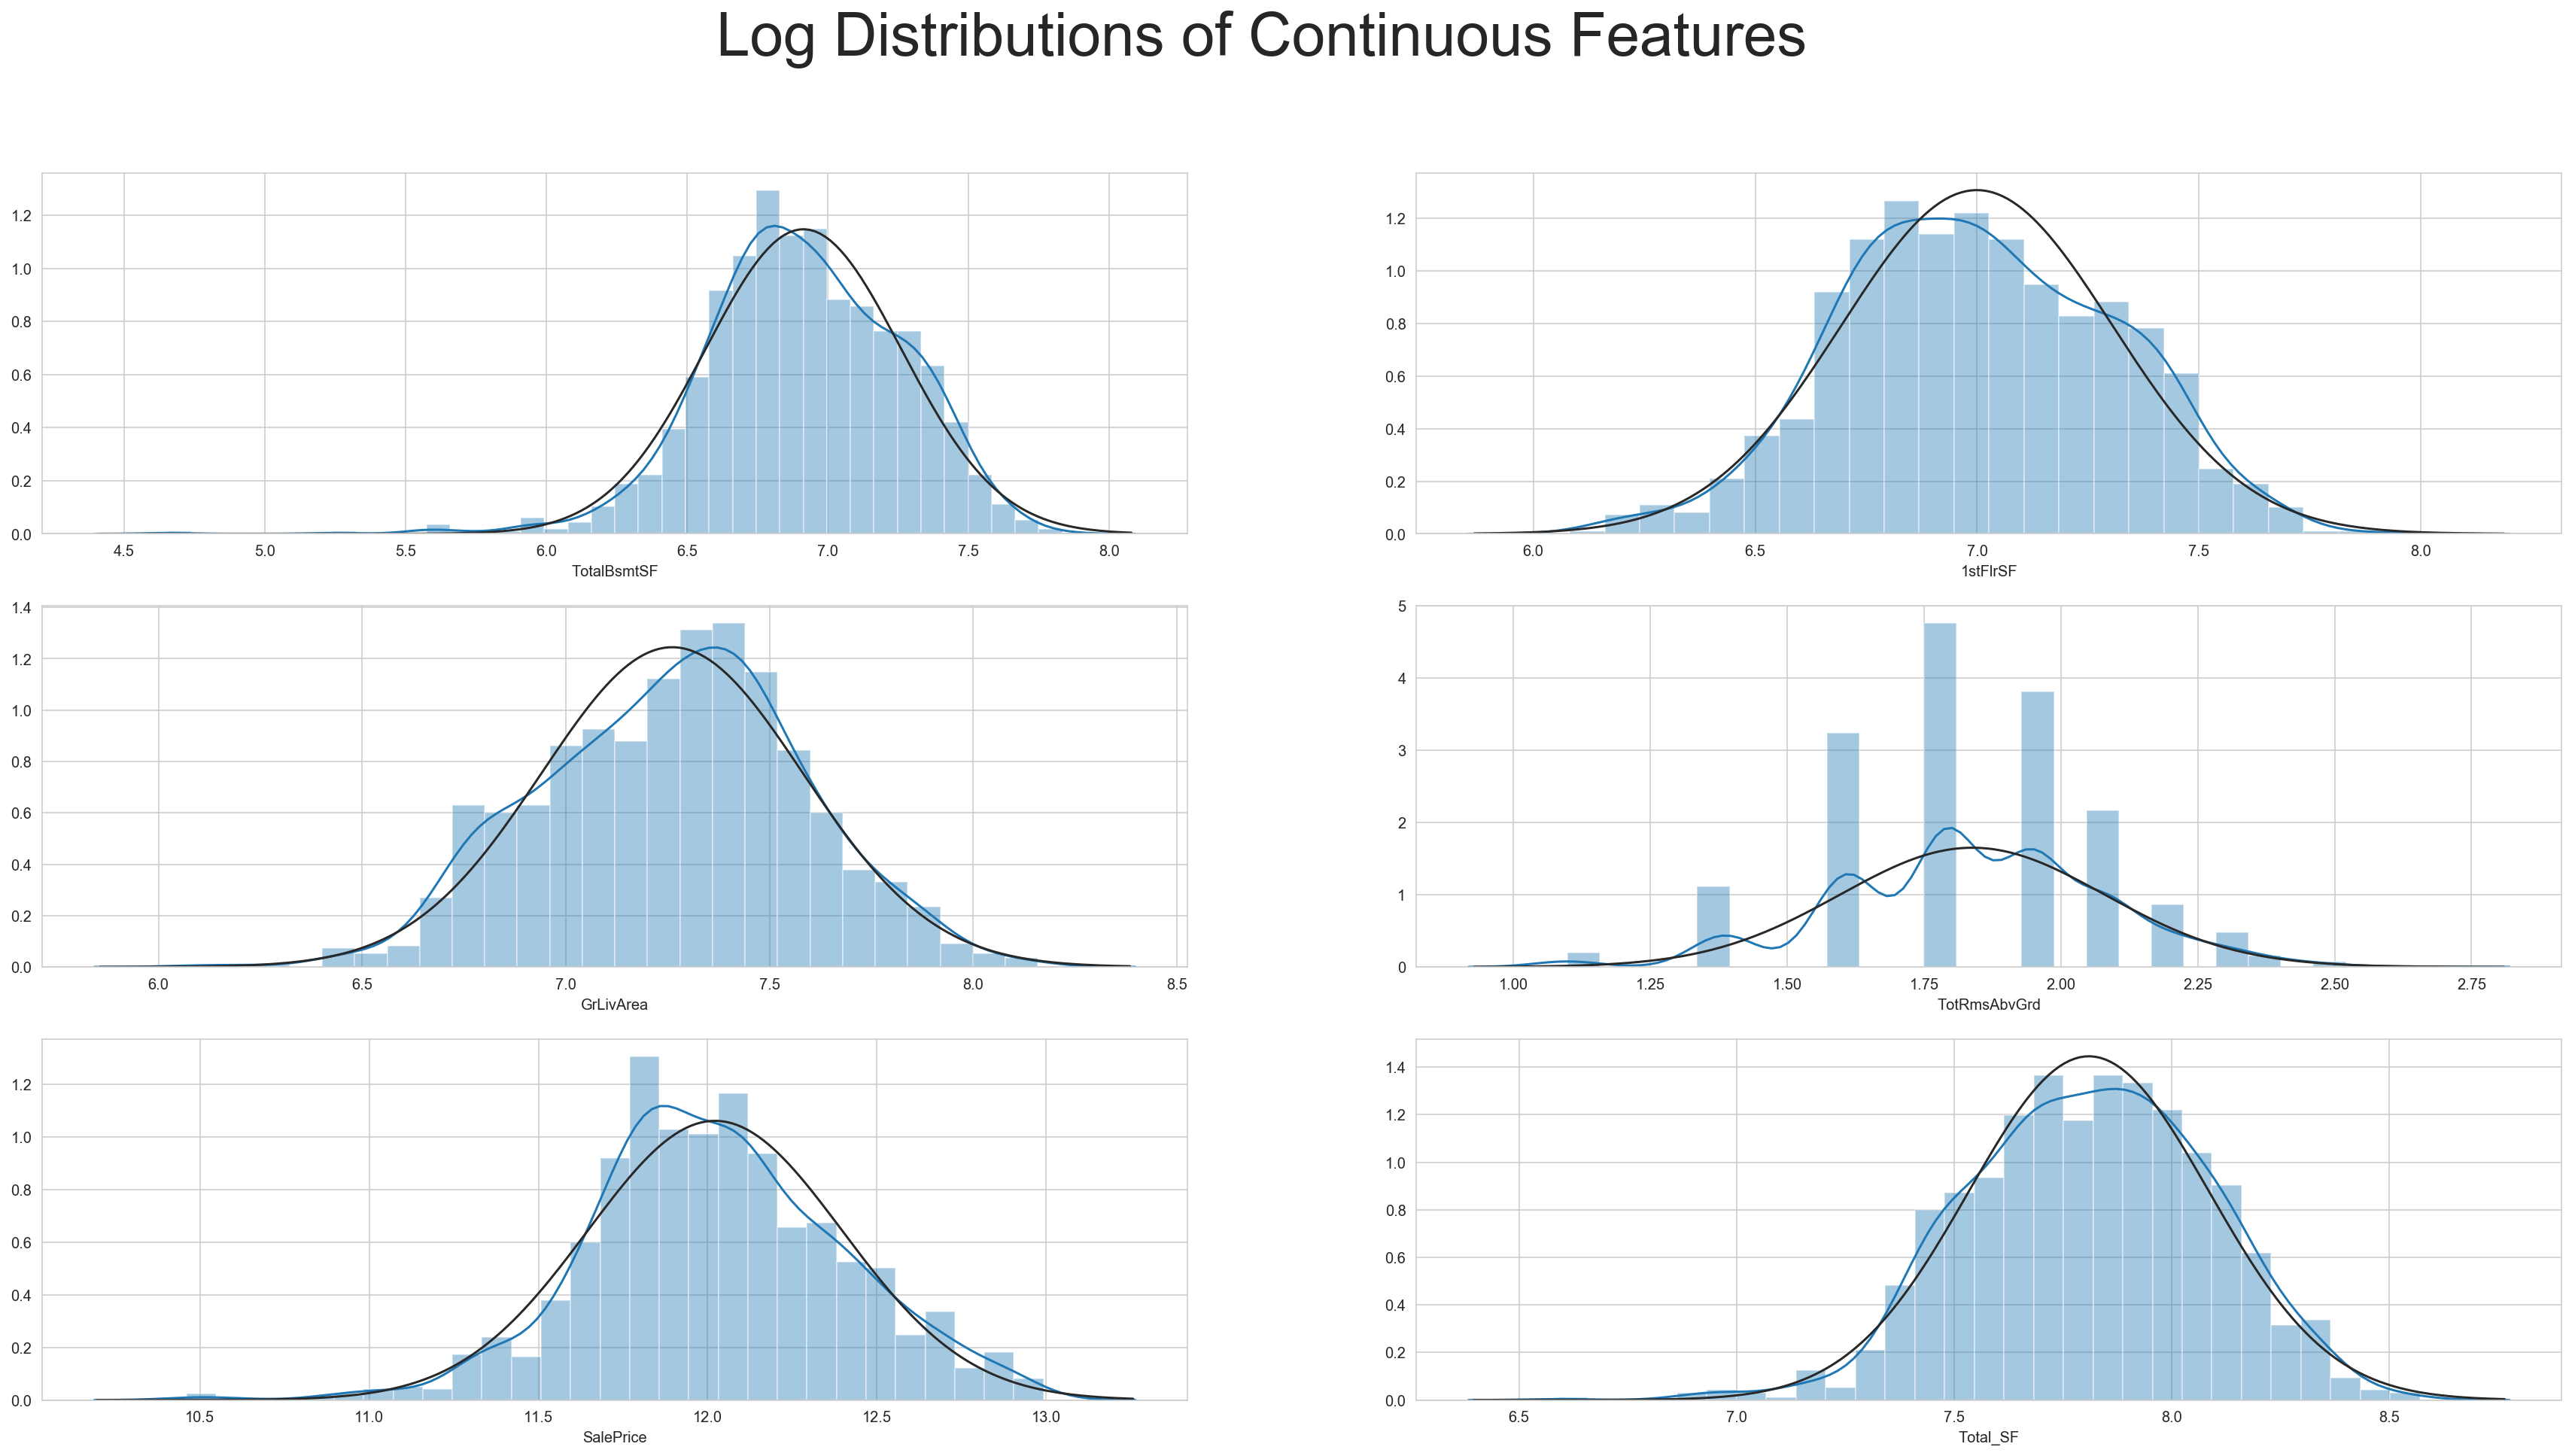

In [51]:
#2nd flr SF looks normally distributed when present
#lot frontage is not terrible

#checking log distributions for all continuous features without zero values
fig, axes = plt.subplots(3,2, figsize=(30,15))

fig.suptitle('Log Distributions of Continuous Features',fontsize=40)

col=0
row=0

for column in fixed_continuous:
    if (fixed_house[column]==0).sum() == 0:
        sns.distplot(np.log(fixed_house[column]), fit=stats.norm, ax=axes[row][col])
        if col == 1:
            row +=1
            col = 0
        else:
            col += 1
    else:
        pass

In [52]:
#checking log normalized skew values
#definitely at least somewhat better

counter = 0
print('Column', '\t', '\t', 'Skew', '\t', '\t', '\t', 'Log Skew')

for col in fixed_continuous:
    skew = stats.skew(fixed_house[col])
    
    if (fixed_house[col]==0).sum() == 0:
        col_log_skew = stats.skew([np.log(item) for item in fixed_house[col]])
        print (col,'\t', skew, '\t', col_log_skew)            
        
    else:
        print (col,'\t', skew, '\t', 'N/A')            



Column 	 	 Skew 	 	 	 Log Skew
TotalBsmtSF 	 0.6601301608875502 	 -0.49208422411689134
1stFlrSF 	 0.7342424826080659 	 0.0005612951366505826
2ndFlrSF 	 0.7413254686205911 	 N/A
GrLivArea 	 0.7484359420054119 	 -0.11837871684330005
TotRmsAbvGrd 	 0.6253184826296874 	 -0.18405350717087687
Fireplaces 	 0.6247285795975308 	 N/A
GarageCars 	 -0.3243129326379309 	 N/A
GarageArea 	 0.13859281322003544 	 N/A
SalePrice 	 1.0732123594766758 	 -0.08057284285888901
Total_SF 	 0.5386425682448831 	 -0.20370382223971803


In [53]:
#Total_SF does not look different - checking sqrt, given that it is a squared feature
stats.skew(np.sqrt(fixed_house['Total_SF']))


0.1826616050241117

__All calculable skews are improved by this method__

Total SF only improves marginally, but improves more via squareroot
The following variables are not able to be normalized by this method, due to not existing for all properties:
* TotalBsmtSF
* 2ndFlrSF
* Fireplaces
* GarageCars
* GarageArea

The first will likely to be dropped in favor of TotalSF
Will need to continue considering whether other management is needed for Fireplaces and Garage items


In [54]:
#adding log / sqrt variables & target as separate columns
new_cols = []
for col in fixed_continuous:
    if (fixed_house[col]==0).sum() == 0:
        if col == 'Total_SF':
            new_col = 'Sqrt_Total_SF'
            fixed_house[new_col] = [np.sqrt(item) for item in fixed_house[col]]
        else:
            new_col = 'Log' + col
            fixed_house[new_col] = [np.log(item) for item in fixed_house[col]]
        new_cols.append(new_col)    

fixed_continuous += new_cols
fixed_continuous

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


['TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'SalePrice',
 'Total_SF',
 'LogTotalBsmtSF',
 'Log1stFlrSF',
 'LogGrLivArea',
 'LogTotRmsAbvGrd',
 'LogSalePrice',
 'Sqrt_Total_SF']

In [55]:
#looking at heatmap of correlation of continous features
#separating log/sqrt & original versions 

targets = ['SalePrice','LogSalePrice']

altered_cont_vars = [col for col in fixed_continuous 
                                 if (((col.startswith('Log') == True) 
                                      or (col.startswith('Sqrt') == True)) 
                                     & ('Price' not in col))]

original_cont_vars = [col for col in fixed_continuous
                                 if ((col not in targets) & (col not in altered_cont_vars))]
print(altered_cont_vars)
print(original_cont_vars)

['LogTotalBsmtSF', 'Log1stFlrSF', 'LogGrLivArea', 'LogTotRmsAbvGrd', 'Sqrt_Total_SF']
['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'Total_SF']


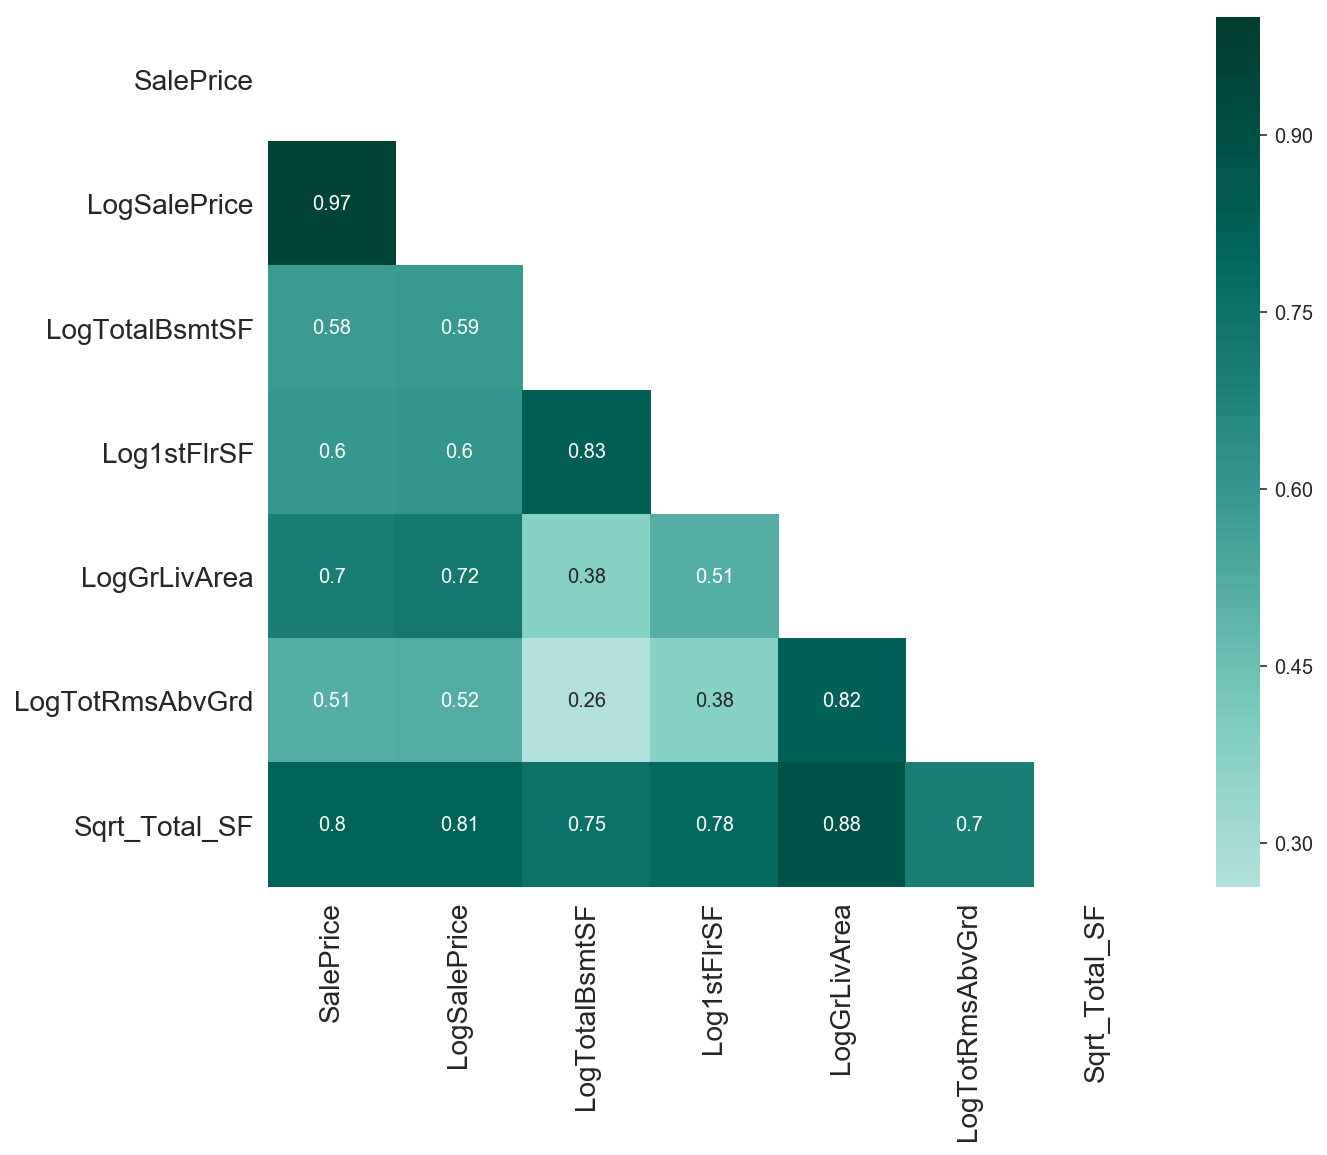

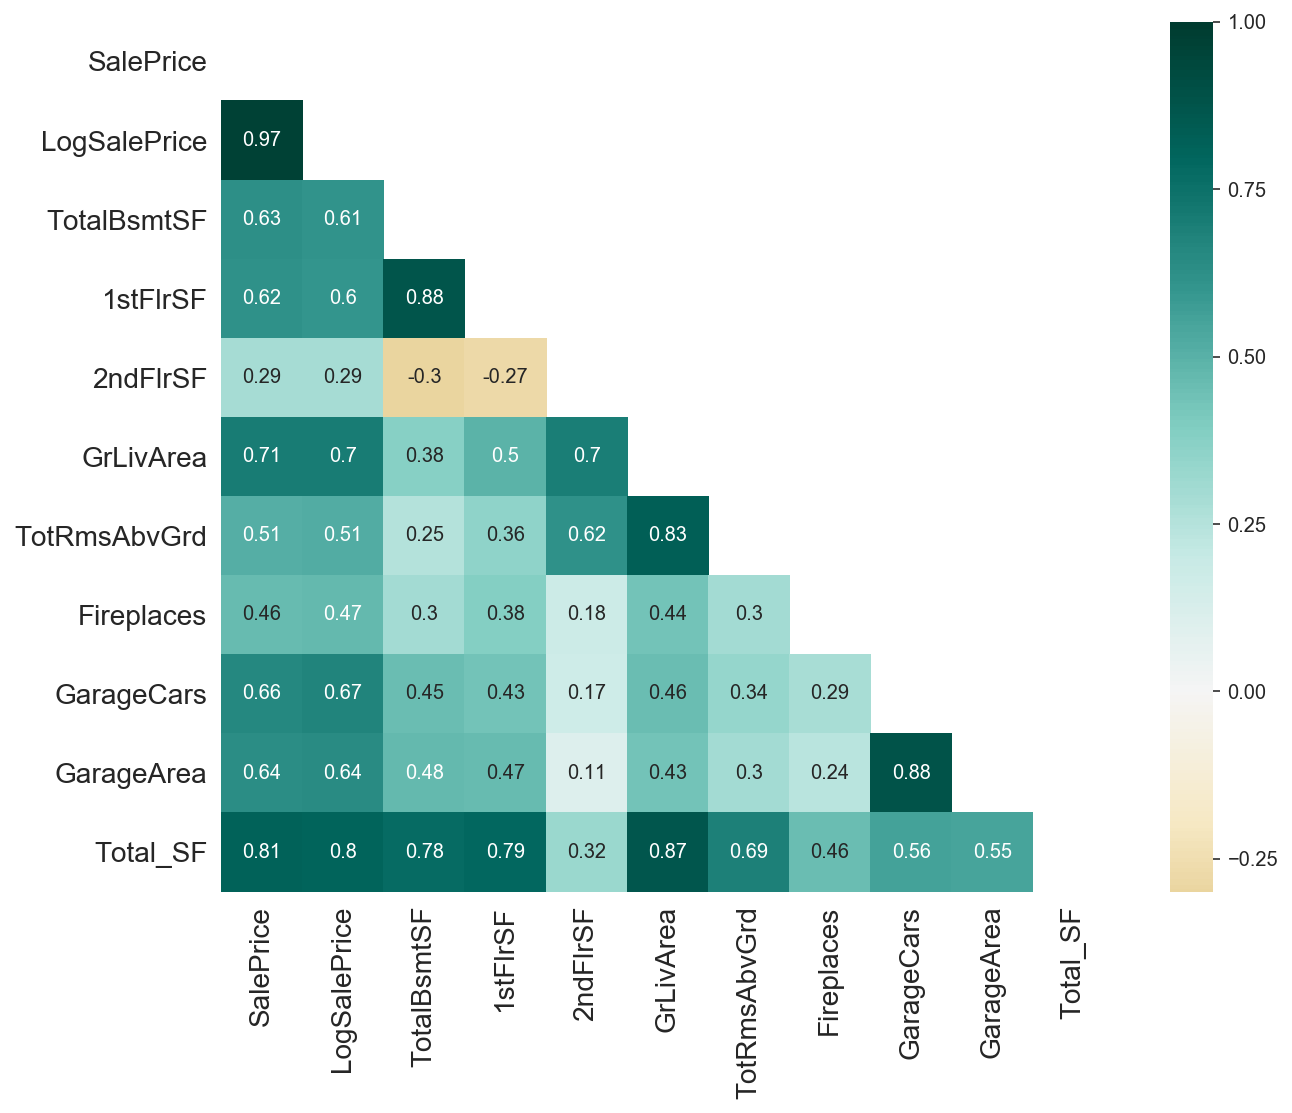

In [56]:
#plotting correlation heatmap for original & adjusted features with both targets

for variables in [altered_cont_vars, original_cont_vars]:
    columns = targets + variables
    data = fixed_house[columns]

    fix, ax = plt.subplots(figsize=(10,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(data.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    ax = sns.heatmap(data.corr(), annot=True, center=0, cmap='BrBG', mask=mask, ax=ax)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    plt.show()

### Observations
* Correlations are not significantly different between Log and non-Log correlations; maintaining SalePrice in dollars makes results easier to interpret, so may retain original
* Sale price is highly correlated with Total_SF; will drop other variables included in TotalSF (TotalBsmtSF, 1stFlrSF, 2ndFlrSF) in favor of combined feature
* Second highest correlation is GrLivArea - looks useful to include
* GarageArea and GarageCars are both strongly correlated with price, and not surprisingly, they are very strongly correlated with each other. GarageArea has a lower skew, and is truly continuous, GarageCars has slightly higher correlation so may test both.
* TotRmsAbvGrd & Fireplaces both show significant correlation, but for current purposes, unlikely to be included

In [57]:
#comparing results to feature selection functions
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [58]:
#removing SalePrice from variables column to try modelling all continuous variables
columns = original_cont_vars + altered_cont_vars

for target in targets: 
    X = fixed_house[columns]

    Xs= ss.fit_transform(X)
    y = fixed_house[target]

    f_regression_sel = SelectKBest(f_regression, k=5)
    f_regression_m = f_regression_sel.fit(Xs,y)

    kbest_continuous = pd.DataFrame([columns, list(f_regression_m.scores_)], 
                         index=['feature', 'f_regression score']).T.sort_values('f_regression score', ascending=False)
    print('Target:', target)
    print(kbest_continuous)
    print('----------------')
    print('----------------')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Target: SalePrice
            feature f_regression score
8          Total_SF           2715.432
13    Sqrt_Total_SF           2551.388
3         GrLivArea           1393.364
11     LogGrLivArea           1348.281
6        GarageCars           1059.586
7        GarageArea            943.753
0       TotalBsmtSF            899.641
1          1stFlrSF            849.528
10      Log1stFlrSF            774.390
9    LogTotalBsmtSF            723.354
4      TotRmsAbvGrd            495.330
12  LogTotRmsAbvGrd            488.815
5        Fireplaces            380.891
2          2ndFlrSF            127.706
----------------
----------------
Target: LogSalePrice
            feature f_regression score
13    Sqrt_Total_SF           2613.611
8          Total_SF           2514.259
11     LogGrLivArea           1513.816
3         GrLivArea           1358.020
6        GarageCars           1160.754
7        GarageArea            972.673
0       TotalBsmtSF            830.556
1          1stFlrSF           

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Observations
* Original variables rank slightly higher with original target; and adjusted with adjusted -> should choose one or the other, not a mix
* Rankings ae very similar - looks appropriate to move ahead with Total_SF, GrLivArea, and possibly one of the Garage options


In [59]:
continuous_columns = ['Total_SF','GrLivArea','GarageCars','GarageArea']

## Next up: time-based variables

In [60]:
fixed_times

['YearBuilt', 'YrSold', 'YearRemodAdd']

<Figure size 1080x864 with 0 Axes>

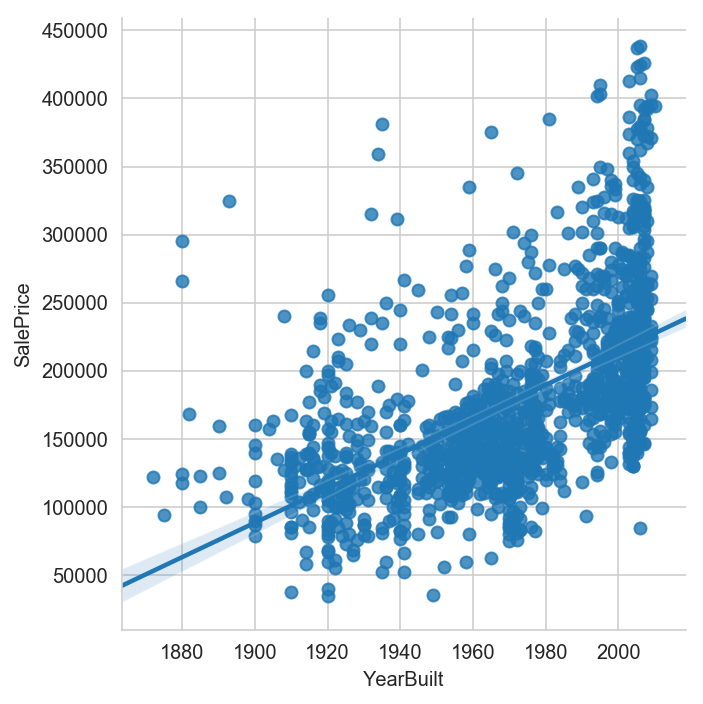

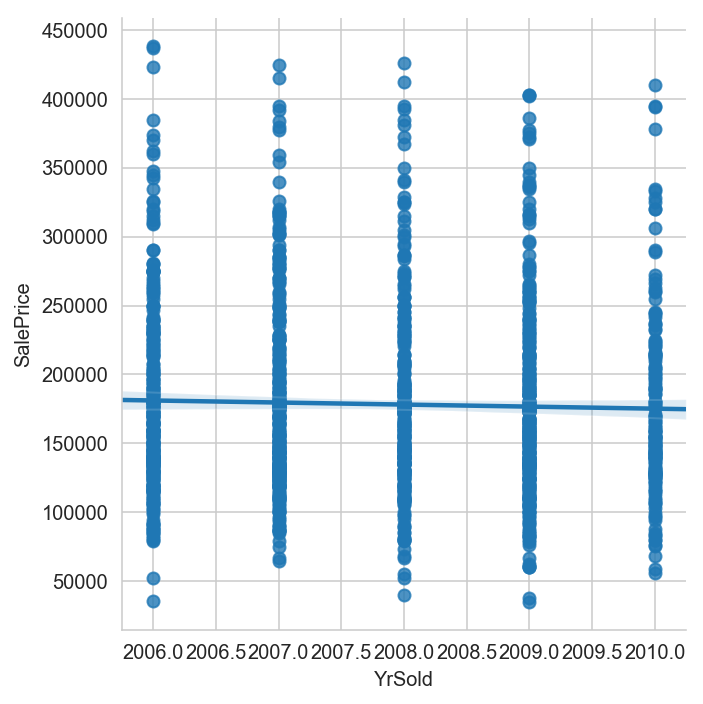

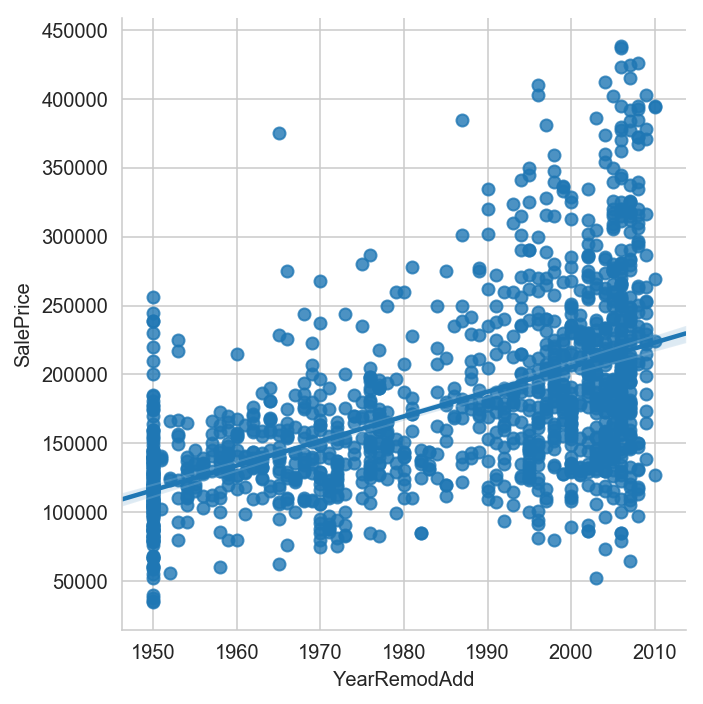

In [61]:
plt.figure(figsize=(15,12))
for time in fixed_times:
    sns.lmplot(x = time, y='SalePrice', data = fixed_house)


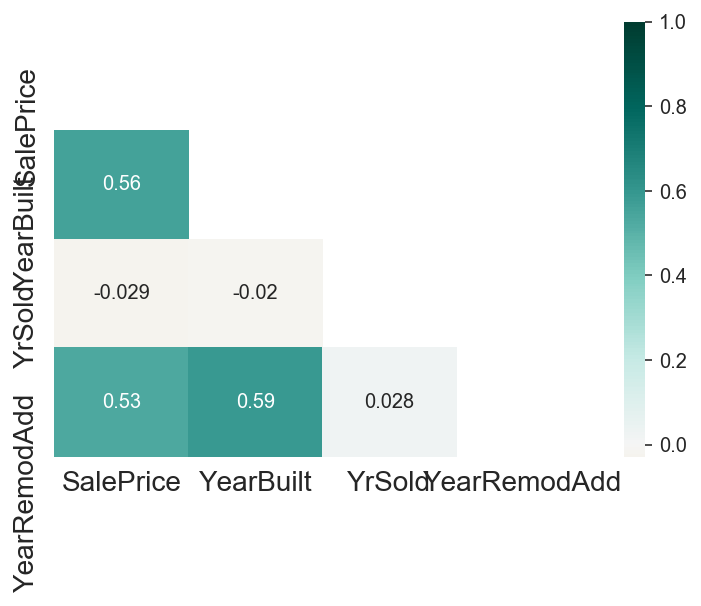

In [62]:
columns = ['SalePrice'] + fixed_times

fix, ax = plt.subplots()

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(fixed_house[columns].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
ax = sns.heatmap(fixed_house[columns].corr(), annot=True, center=0, cmap='BrBG', mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

### Initial Observations

* There is some linear relationship between sale price and the time features
* YearBuilt and GarageYrBlt are highly correlated (not surprising)
* GarageYearBuilt also has significant correlation with YearRemodAdd (potentially included garage)
* YrSold is showing very slight negative correlation - may be able to make something useful out of this, but not looking like a priority

Next will look into checking connections between years to avoid duplicity and shifting from year to age (current year - year included)

In [63]:
fixed_times.remove('YrSold')


In [64]:
for col in fixed_times:
    new_col = 'Age' + col
    fixed_house[new_col] = 2019 - fixed_house[col]

fixed_house.AgeYearBuilt.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0     16
1     43
2     18
3    104
4     19
Name: AgeYearBuilt, dtype: int64

In [65]:
ages = [col for col in fixed_house if col.startswith('Age') == True]
ages

['AgeYearBuilt', 'AgeYearRemodAdd']

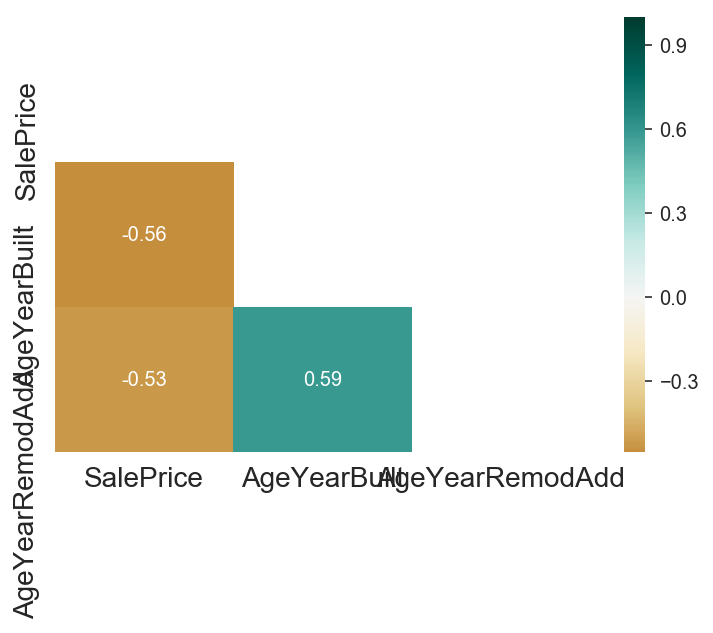

In [66]:
columns = ['SalePrice'] + ages

fix, ax = plt.subplots()

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(fixed_house[columns].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
ax = sns.heatmap(fixed_house[columns].corr(), annot=True, center=0, cmap='BrBG', mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

<Figure size 1080x864 with 0 Axes>

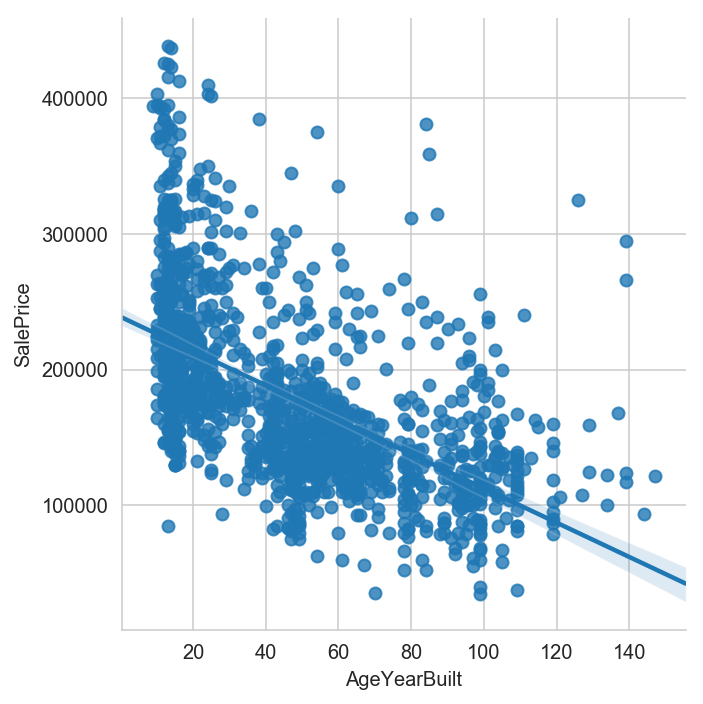

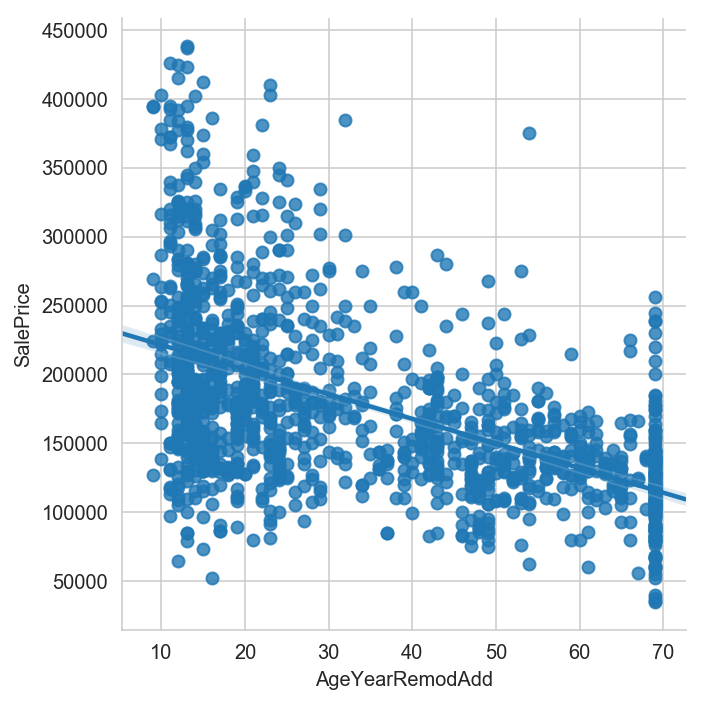

In [67]:
plt.figure(figsize=(15,12))
for age in ages:
    sns.lmplot(x = age, y='SalePrice', data = fixed_house)

Some linear correlation in these values, but lots of spread, particularly among the newer houses.<br>
Year built seems to be impacted by outliers of older expensive houses. <br>
Will look to include atleast one of AgeYearBuilt and AgeYearRemodAdd.<br>

In [68]:
time_columns = ['AgeYearBuilt','AgeYearRemodAdd']

## Now for Categorical Variables

In [69]:
print(fixed_categorical)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', 'GarageType', 'SaleType', 'SaleCondition', 'MSSubClass']


In [70]:
fixed_house['MSSubClass'] = fixed_house['MSSubClass'].apply(str)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
categoricals = fixed_house[fixed_categorical]
categoricals.describe().T


count unique     top  freq
MSZoning       1394      5      RL  1094
Street         1394      2    Pave  1388
LotShape       1394      4     Reg   882
LandContour    1394      4     Lvl  1252
Utilities      1394      2  AllPub  1393
LotConfig      1394      5  Inside  1004
LandSlope      1394      3     Gtl  1318
Neighborhood   1394     25   NAmes   215
Condition1     1394      9    Norm  1205
Condition2     1394      8    Norm  1380
BldgType       1394      5    1Fam  1171
HouseStyle     1394      8  1Story   687
RoofStyle      1394      6   Gable  1099
Foundation     1394      5  CBlock   625
BsmtQual       1394      4      TA   647
BsmtExposure   1394      4      No   941
GarageType     1394      7  Attchd   841
SaleType       1394      9      WD  1216
SaleCondition  1394      6  Normal  1151
MSSubClass     1394     15      20   509

In [72]:
#only one item has NoSeWa under Utilities - will drop this row as looking for connected houses
fixed_house.drop(fixed_house.loc[(fixed_house['Utilities'] == 'NoSeWa')].index,inplace=True)
house.drop(house.loc[(house['Utilities'] == 'NoSeWa')].index,inplace=True)

#focused on residential, so removing small number of properties zoned commercial
fixed_house.drop(fixed_house.loc[(fixed_house['MSZoning'] == 'C (all)')].index,inplace=True)
house.drop(house.loc[(house['MSZoning'] == 'C (all)')].index,inplace=True)

#number of rows should be the same
print(fixed_house.shape, house.shape)


#these variables have very few values that are not the dominant value,
#or primarily NaNs with no reason to believe remaining features would add value
#so droppping from consideration
for item in ['Street','Condition1','Condition2','Utilities','LandSlope','LandContour']:
    if item in fixed_categorical:
        fixed_categorical.remove(item)

print(fixed_categorical)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(1383, 41) (1383, 59)
['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', 'GarageType', 'SaleType', 'SaleCondition', 'MSSubClass']


In [73]:
fixed_categorical

['MSZoning',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'GarageType',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

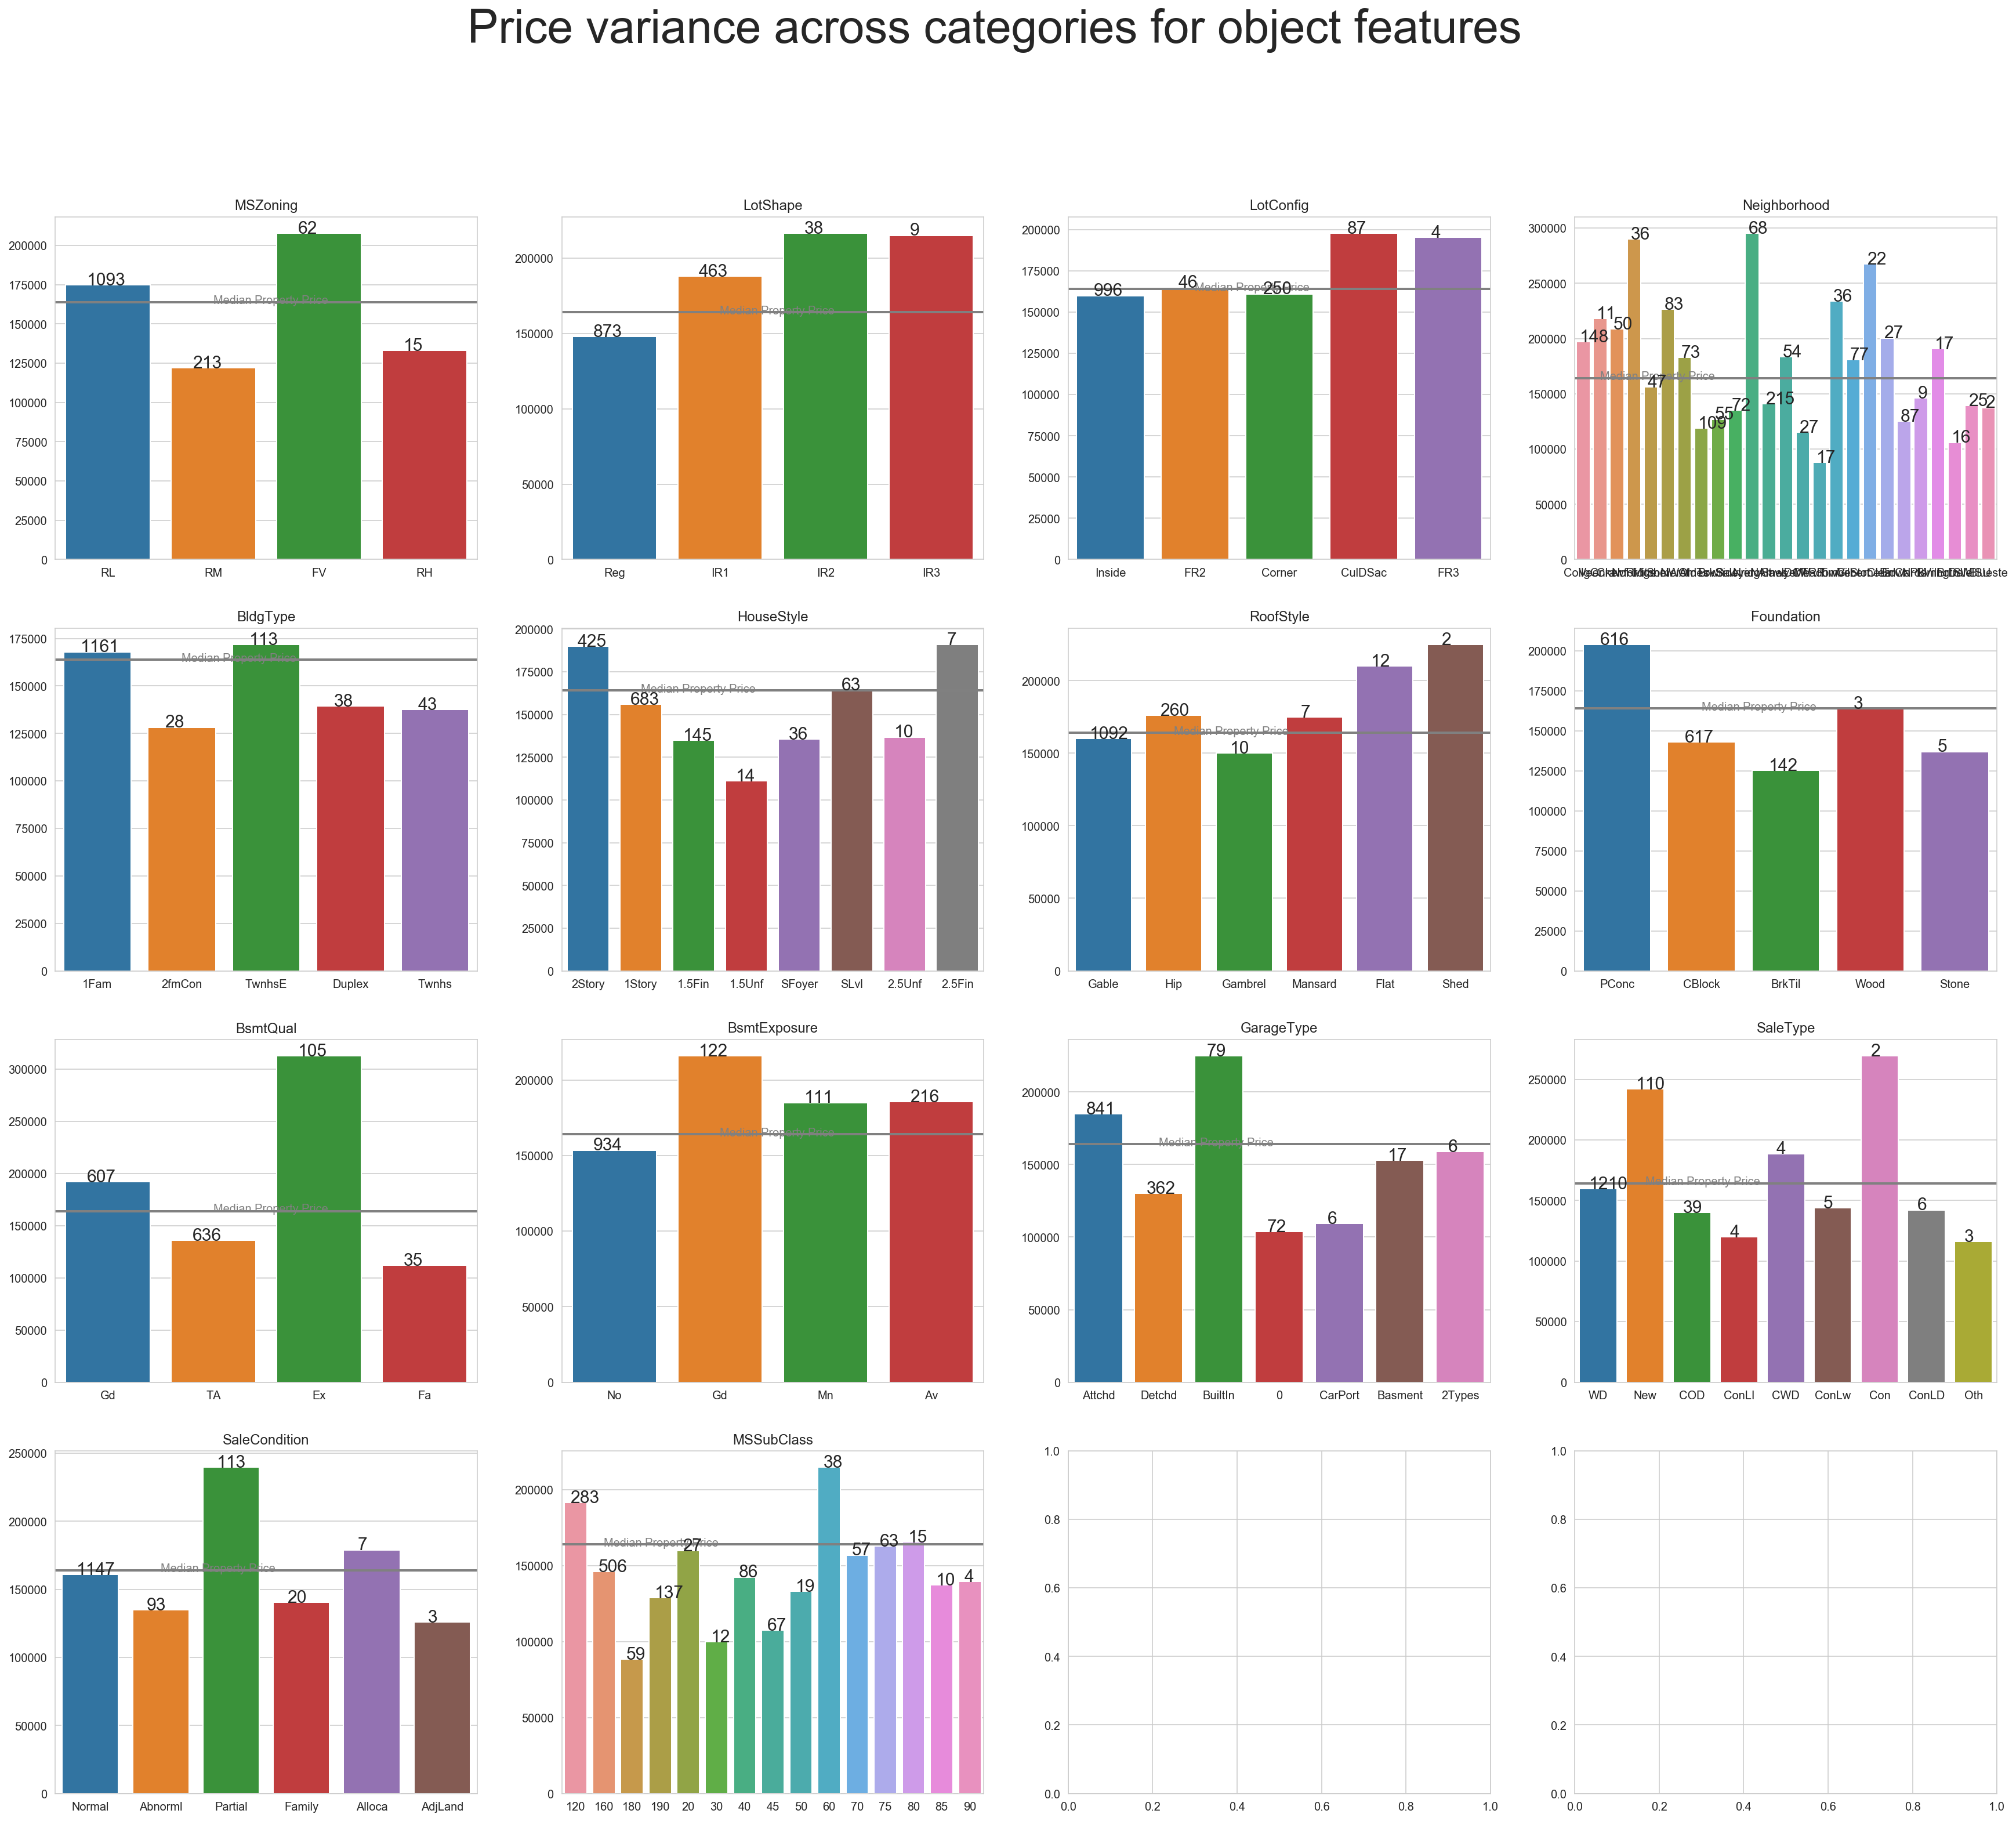

In [73]:
#for category in column
#calculate mean, median of SalePrice
#graph


fig, axes = plt.subplots(4,4, figsize=(30,25))

fig.suptitle('Price variance across categories for object features',fontsize=40)

graph = 1

for column in fixed_categorical:
    
    category_medians = []
    categories = []

    for category in fixed_house[column].unique():
        category_median_price = house[fixed_house[column] == category].SalePrice.median()
        category_medians.append(category_median_price)
        categories.append(category)
        
    ax1 = plt.subplot(4,4,graph)
    sns.barplot(x=fixed_house[column].unique(), y = category_medians, ax=ax1)
    
    #adding overall median house price for comparision
    ax1.axhline(house.SalePrice.median(), color='gray', linewidth=2)
    ax1.text(x=1, y=163000, s='Median Property Price', color='gray')
    
    ax1.set_title(str(column))

    #add count of values in category
    counter = 0
    for i in ax1.patches:
        cat = categories[counter]
        # get_x pulls left or right; get_height pushes up or down
        ax1.text(i.get_x()+0.2, i.get_height()+.5, \
                str((fixed_house[column] == cat).sum()), fontsize=15)
        counter += 1
        
    graph += 1

__Some features show considerable variation__

Neighborhood, HouseStyle, GarageType, MSZoning, BsmtQual <br>
MSSubClass (40 & 180 vs others) <br>
Foundation (particularly Stone vs others) <br>
SaleType (particularly New, Con vs all others) <br>
SaleCondition (particularly Partial vs all others) - removing from consideration given Q3 of project


In [74]:
#looking at the details of a few options
for col in ['GarageType','MSZoning','Foundation','SaleType','RoofStyle']:
    print(fixed_house[col].value_counts(dropna=False))
    print('----------------------------')

Attchd     841
Detchd     362
BuiltIn     79
0           72
Basment     17
2Types       6
CarPort      6
Name: GarageType, dtype: int64
----------------------------
RL    1093
RM     213
FV      62
RH      15
Name: MSZoning, dtype: int64
----------------------------
CBlock    617
PConc     616
BrkTil    142
Stone       5
Wood        3
Name: Foundation, dtype: int64
----------------------------
WD       1210
New       110
COD        39
ConLD       6
ConLw       5
CWD         4
ConLI       4
Oth         3
Con         2
Name: SaleType, dtype: int64
----------------------------
Gable      1092
Hip         260
Flat         12
Gambrel      10
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64
----------------------------


In [75]:
#For all of these categories with large numbers of rows do not show significant price variation

#Capturing remaining categorical columns of interest
interesting_cats = ['Neighborhood', 'HouseStyle', 'MSSubClass','BsmtQual']


<Figure size 432x288 with 0 Axes>

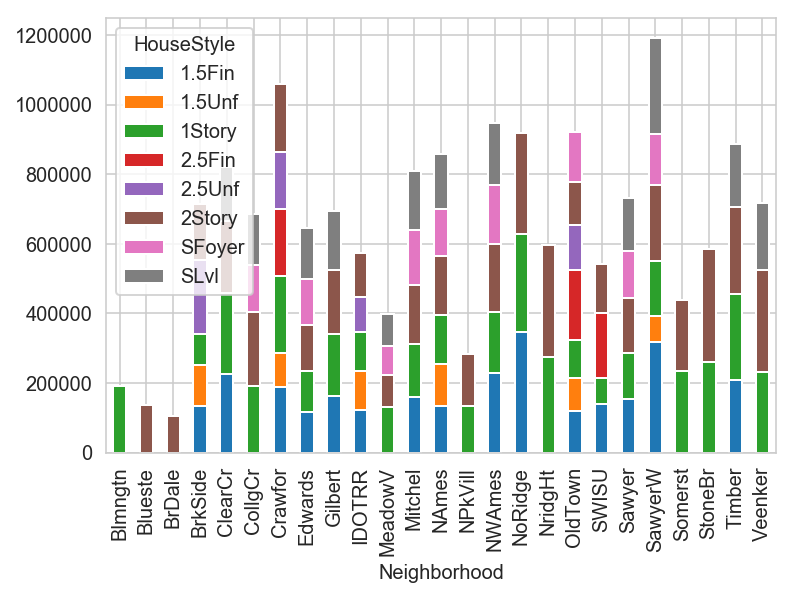

<Figure size 432x288 with 0 Axes>

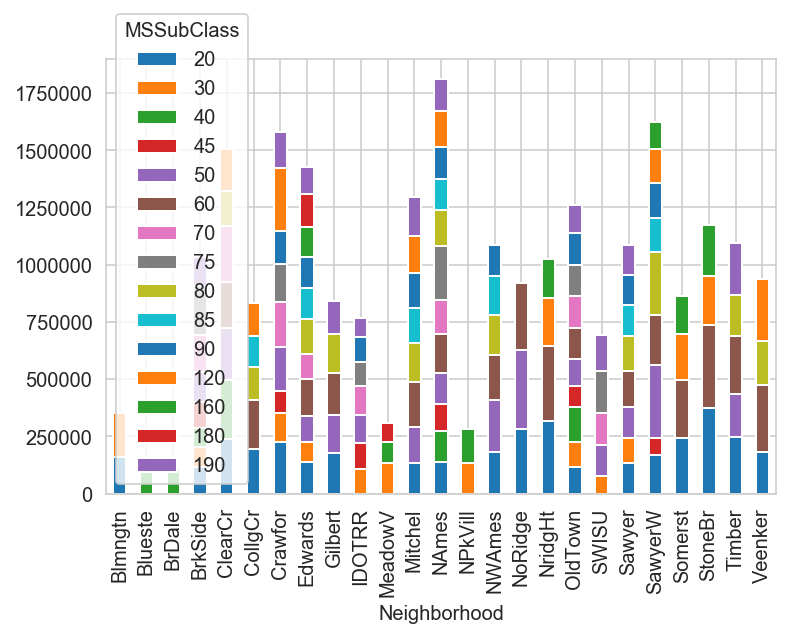

<Figure size 432x288 with 0 Axes>

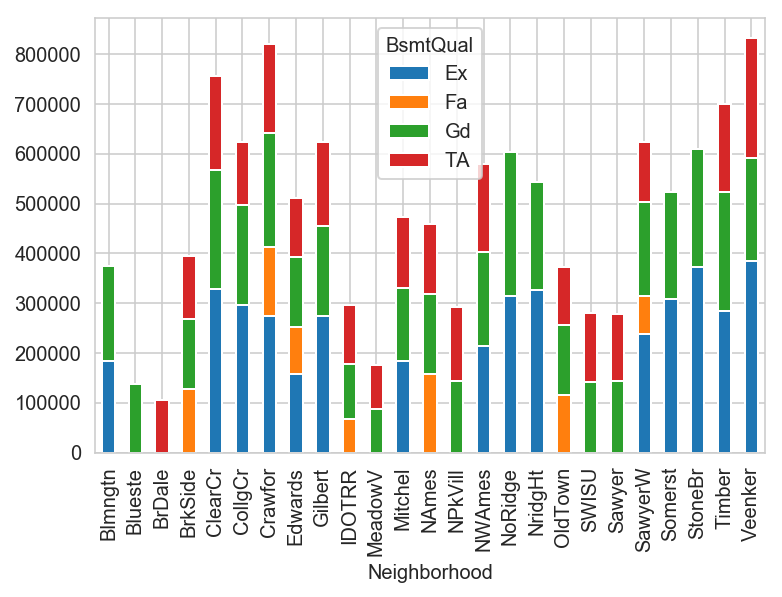

In [76]:
#given that neighborhoods often share housing characteristics, 
#how much do the other factors correlated with neighborhood?

for column in interesting_cats:
   
    if column != 'Neighborhood':
        plt.figure()
        n_zone = house.groupby(['Neighborhood', column])['SalePrice'].median().unstack()
        n_zone.plot(kind='bar', stacked=True)

# plt.figure()
# n_zone = house.groupby(['Neighborhood','MSSubClass'])['SalePrice'].median().unstack()
# n_zone.plot(kind='bar', stacked=True)


Basement quality looks potentially connected to Neighborhood. Will test inclusion of each.

In [77]:
#adding dummies for categorical features
categorical_features = pd.get_dummies(fixed_house[interesting_cats], drop_first=True)
categorical_features.columns

Index(['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer',
       'HouseStyle_SLvl', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
       'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       

In [78]:
#creating dataframe of numerical variables
num_column_list = continuous_columns + time_columns
num_column_list
numerical_features = fixed_house[num_column_list]
numerical_features.shape

(1383, 6)

### Creating X for modeling

In [79]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [80]:
scaled_numerical_f = pd.DataFrame(ss.fit_transform(numerical_features), 
                                  index=numerical_features.index.tolist(), columns=numerical_features.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [81]:
X = pd.concat([numerical_features, categorical_features], axis = 1)
X.shape


(1383, 54)

In [82]:
Xs = pd.concat([scaled_numerical_f, categorical_features], axis=1)
Xs.shape

(1383, 54)

__Setting up train and test sets__

In [83]:
test_rows = fixed_house[fixed_house.YrSold == 2010]
train_rows = fixed_house[fixed_house.YrSold < 2010]

print(fixed_house.shape, len(test_rows) + len(train_rows))

(1383, 41) 1383


In [84]:
Xs_test = Xs[fixed_house.YrSold == 2010]
Xs_train = Xs[fixed_house.YrSold < 2010]

X_test = X[fixed_house.YrSold == 2010]
X_train = X[fixed_house.YrSold < 2010]

y_test = fixed_house[fixed_house.YrSold == 2010].SalePrice
y_train = fixed_house[fixed_house.YrSold < 2010].SalePrice

print(Xs_test.shape, Xs_train.shape, X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(164, 54) (1219, 54) (164, 54) (1219, 54) (164,) (1219,)


In [85]:
#calculate baseline mean squared error
mean_y_train = np.mean(y_train)
mse_baseline = np.mean([(x - mean_y_train)**2 for x in y_train])


print("Baseline mean squared error:", mse_baseline)

Baseline mean squared error: 4730618968.003764


In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [87]:
lr = LinearRegression()

#Running model with both scaled and unscaled continuous variables
for options in [X_train, Xs_train]:

    scores_train_r2 = cross_val_score(lr, options, y_train, scoring = 'r2', cv=5)
    print('Rsquared')
    print(np.mean(scores_train_r2),np.std(scores_train_r2))

    scores_train_mse = cross_val_score(lr, options, y_train, scoring = 'neg_mean_squared_error', cv=5)
    print('mse')
    print(np.mean(scores_train_mse),np.std(scores_train_mse))
    print('-----------------')

    #adding contstand for stats_models
    options = sm.add_constant(options)
    model = sm.OLS(y_train, options)
    model = model.fit()
    print(model.summary())

Rsquared
0.8521136802517478 0.02989185610111958
mse
-695026874.2616572 159531169.71026635
-----------------
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     142.4
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:51:53   Log-Likelihood:                -14071.
No. Observations:                1219   AIC:                         2.825e+04
Df Residuals:                    1164   BIC:                         2.853e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)



-695026874.2616597 159531169.71026704
-----------------
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     142.4
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:51:53   Log-Likelihood:                -14071.
No. Observations:                1219   AIC:                         2.825e+04
Df Residuals:                    1164   BIC:                         2.853e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [88]:
#Running again, removing likely collinear garage & age variables showing lower importance
#Unclear if scaled or unscaled is better
X2 = X.drop(['GarageArea','AgeYearRemodAdd'], axis = 1)
Xs2 = Xs.drop(['GarageArea','AgeYearRemodAdd'], axis = 1)

In [89]:
Xs_test = Xs2[fixed_house.YrSold == 2010]
Xs_train = Xs2[fixed_house.YrSold < 2010]

X_test = X2[fixed_house.YrSold == 2010]
X_train = X2[fixed_house.YrSold < 2010]

y_test = fixed_house[fixed_house.YrSold == 2010].SalePrice
y_train = fixed_house[fixed_house.YrSold < 2010].SalePrice

print(Xs_test.shape, Xs_train.shape, X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(164, 52) (1219, 52) (164, 52) (1219, 52) (164,) (1219,)


In [90]:
for options in [X_train, Xs_train]:

    scores_train_r2 = cross_val_score(lr, options, y_train, scoring = 'r2', cv=5)
    print('Rsquared')
    print(np.mean(scores_train_r2),np.std(scores_train_r2))

    scores_train_mse = cross_val_score(lr, options, y_train, scoring = 'neg_mean_squared_error', cv=5)
    print('mse')
    print(np.mean(scores_train_mse),np.std(scores_train_mse))

    #adding contstand for stats_models
    options = sm.add_constant(options)
    model = sm.OLS(y_train, options)
    model = model.fit()
    print(model.summary())
    
    print('-----------------')


Rsquared
0.8433357538575279 0.027896035826723647
mse
-736143443.101583 160771016.71604037
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     138.4
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:51:54   Log-Likelihood:                -14107.
No. Observations:                1219   AIC:                         2.832e+04
Df Residuals:                    1166   BIC:                         2.859e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
-----------------


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Standardized model is looking better in terms of multicollinearity. Will just use it for final tweaks.

Some classes for MSSubClass are outside of signficance. My need to separate them somehow.

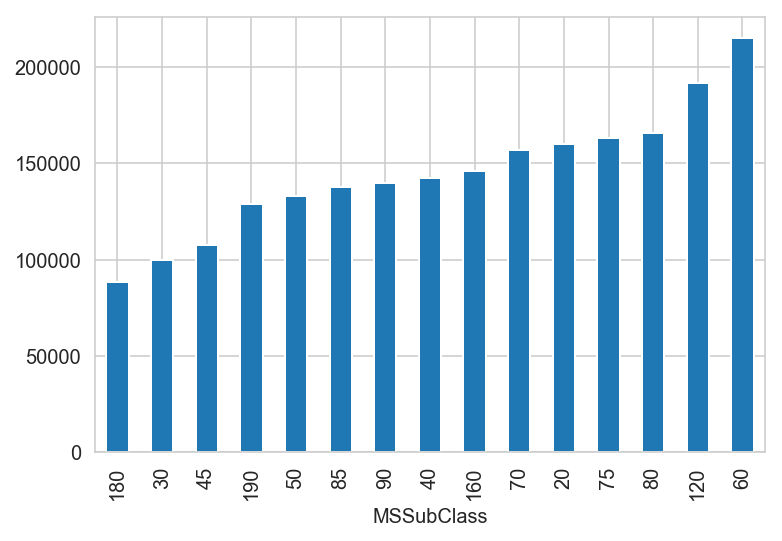

In [91]:
fixed_house.groupby('MSSubClass')['SalePrice'].median().sort_values().plot(kind='bar')

In [92]:
#non significant classes are mostly the lower values

Xs3_columns = [column for column in Xs2 if 'MSSubClass' not in column]
Xs3_columns

['Total_SF',
 'GrLivArea',
 'GarageCars',
 'AgeYearBuilt',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'BsmtQual_Fa',
 'BsmtQual_Gd',
 'BsmtQual_TA']

In [93]:
Xs3 = Xs2[Xs3_columns]

In [94]:
Xs_test = Xs3[fixed_house.YrSold == 2010]
Xs_train = Xs3[fixed_house.YrSold < 2010]

y_test = fixed_house[fixed_house.YrSold == 2010].SalePrice
y_train = fixed_house[fixed_house.YrSold < 2010].SalePrice

print(Xs_test.shape, Xs_train.shape, X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(164, 38) (1219, 38) (164, 52) (1219, 52) (164,) (1219,)


In [95]:
scores_train_r2 = cross_val_score(lr, Xs_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, Xs_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))

#adding contstand for stats_models
Xs_train = sm.add_constant(Xs_train)
model = sm.OLS(y_train, Xs_train)
model = model.fit()
print(model.summary())
    


Rsquared
0.8246589877624851 0.027416790335116716
mse
-820070208.6913857 152380881.7037649
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     164.7
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:51:54   Log-Likelihood:                -14185.
No. Observations:                1219   AIC:                         2.845e+04
Df Residuals:                    1180   BIC:                         2.865e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Removing MSSubClass mad the model worse on Rsquared and Skew values, and made Bsmt_Qual not significant. Going to move forward with Part 2 using the model including MSSubClasses.

In [96]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [97]:
Xs_test = Xs2[fixed_house.YrSold == 2010]
Xs_train = Xs2[fixed_house.YrSold < 2010]

X_test = X2[fixed_house.YrSold == 2010]
X_train = X2[fixed_house.YrSold < 2010]

y_test = fixed_house[fixed_house.YrSold == 2010].SalePrice
y_train = fixed_house[fixed_house.YrSold < 2010].SalePrice

print(Xs_test.shape, Xs_train.shape, X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(164, 52) (1219, 52) (164, 52) (1219, 52) (164,) (1219,)


In [98]:
#trying Ridge
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(Xs_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
r_scores = cross_val_score(ridge, Xs_train, y_train, scoring = 'r2', cv=5)
print(r_scores)
print(np.mean(r_scores),np.std(r_scores))


[0.87961387 0.85111311 0.82828672 0.8602884  0.80122139]
0.8441046976570782 0.027059629496414807


In [99]:
#and Lasso
lasso = Lasso()

l_scores = cross_val_score(lasso, Xs_train, y_train, scoring = 'r2', cv=5)
print(l_scores)
print(np.mean(l_scores),np.std(r_scores))

[0.87944498 0.85078579 0.82663388 0.86082508 0.79954154]
0.8434462554895568 0.027059629496414807


Both are showing very similar results <br>
Running with Ridge on test data to looking at residuals now

In [100]:
ridge.fit(Xs_train, y_train)
ridge.score(Xs_test,y_test)

0.8802331042832259

In [101]:
predictions = ridge.predict(Xs_test)
y_hat = y_test - predictions

### Let's see how it looks!!

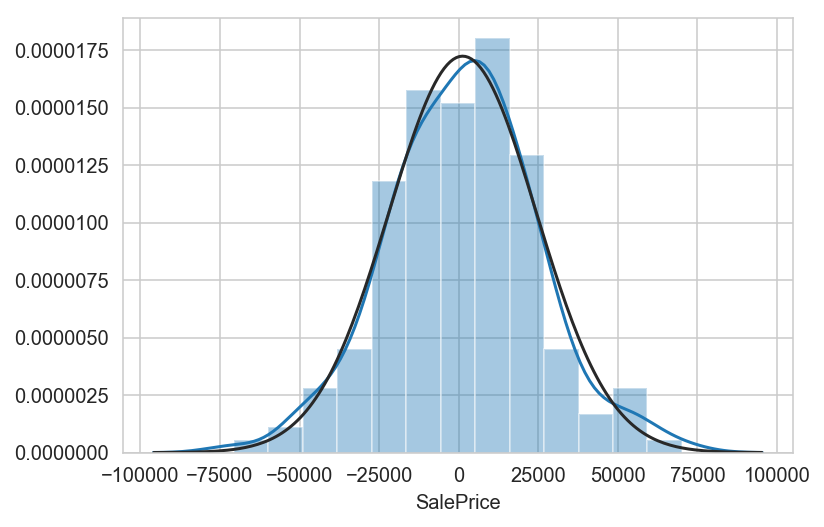

In [102]:
#Are the residuals normally distributed?
#Not quite, but given that we've skipped half the features, it's not too bad
sns.distplot(y_hat, fit=stats.norm)

Text(0, 0.5, 'Predicted Price')

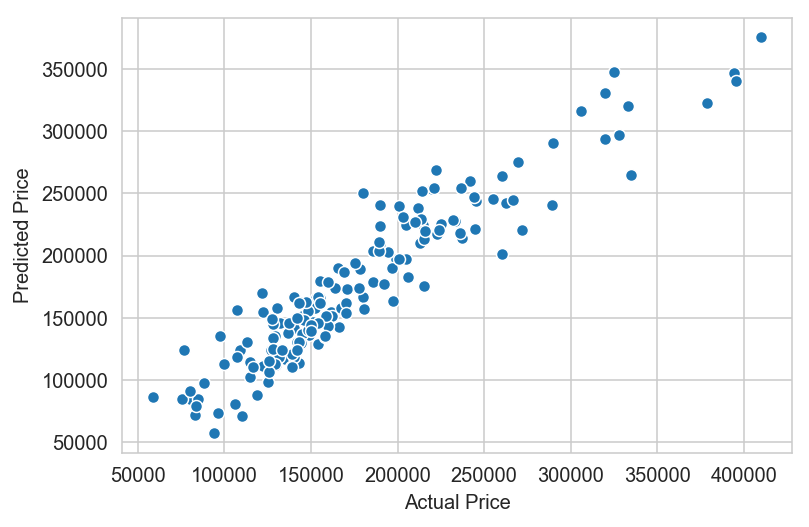

In [103]:
#How does our linear relationship look?
fig, ax = plt.subplots()
sns.scatterplot(y_test,predictions)

ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')

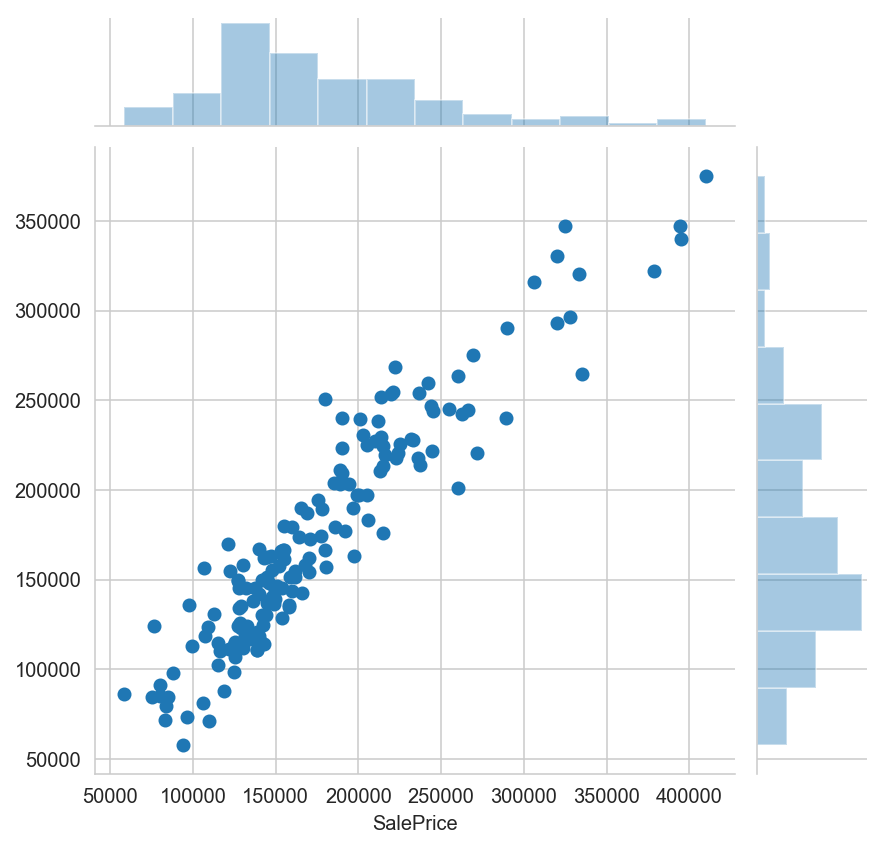

In [104]:
#Our target wasn't normally distributed - is this related to what we're seeing?
sns.jointplot(y_test,predictions)

#Maybe...

Text(0, 0.5, 'Error')

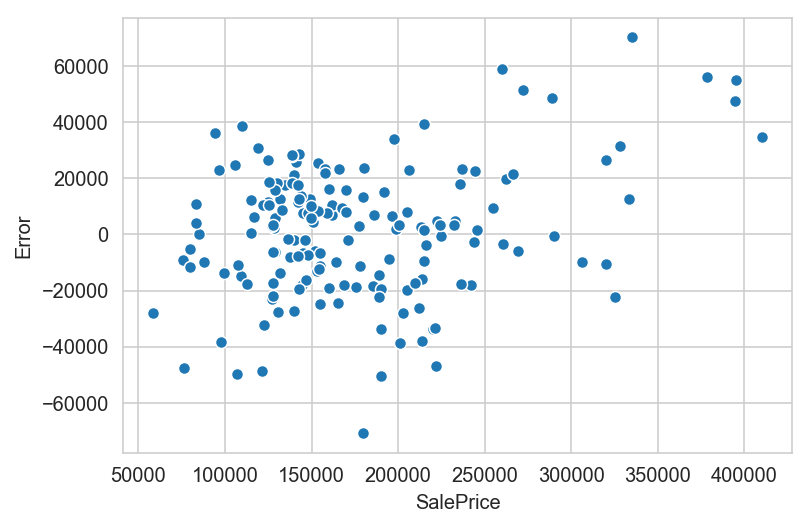

In [105]:
#Do our residuals show a relationship with our target?
ax = sns.scatterplot(x = y_test, y = y_hat)
ax.set_ylabel('Error')


There is still some issue here - our model underestimates sale price for expensive properties, but...

## Good enough!
Let's create a column to store residuals to be the target for part 2

In [106]:
predications_all = ridge.predict(Xs2)
y_hat_all = fixed_house.SalePrice - predications_all


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [107]:
#collecting features
change_house = house[list(fixed_variables.Features[(fixed_variables.fix_var==0)])]
change_house['Remainder'] = y_hat_all
change_house.columns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Index(['OverallQual', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'FullBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'MoSold', 'Remainder'],
      dtype='object')

## Initial sanity check on columns
OverallQual
* This is likely predictive of price, but not a renovatable feature
* It is possible that a correlation with OverallQual will be predictive of a useful feature

Everything else looks like it could be worth considering, although ExterQual, BsmtQual could have the same issue to lesser degrees.

In [108]:
change_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1383 entries, 0 to 1459
Data columns (total 28 columns):
OverallQual     1383 non-null int64
RoofMatl        1383 non-null object
Exterior1st     1383 non-null object
Exterior2nd     1383 non-null object
MasVnrType      1383 non-null object
MasVnrArea      1383 non-null float64
ExterQual       1383 non-null object
ExterCond       1383 non-null object
BsmtCond        1383 non-null object
BsmtFinType1    1383 non-null object
BsmtFinSF1      1383 non-null int64
BsmtFinType2    1383 non-null object
Heating         1383 non-null object
HeatingQC       1383 non-null object
CentralAir      1383 non-null object
Electrical      1383 non-null object
FullBath        1383 non-null int64
KitchenQual     1383 non-null object
Functional      1383 non-null object
FireplaceQu     735 non-null object
GarageFinish    1383 non-null object
GarageQual      1383 non-null object
GarageCond      1383 non-null object
PavedDrive      1383 non-null object
WoodDeck

In [109]:
#ditching Functional, as it gives no indication of what would need to be fixed
change_house.drop('Functional', axis = 1, inplace=True)
change_house.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(1383, 27)

In [110]:
#adding an outdoor sf column combining porch and deck to see if it is useful
change_house['OutdoorSF'] = change_house['WoodDeckSF'] + change_house['OpenPorchSF']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [111]:
#only have a few remaining numerical features
#looking for any intitial correlations
change_house.corrwith(y_hat_all)

OverallQual    0.182
MasVnrArea     0.058
BsmtFinSF1     0.254
FullBath      -0.032
WoodDeckSF     0.120
OpenPorchSF    0.049
MoSold         0.017
Remainder      1.000
OutdoorSF      0.127
dtype: float64

As expected, OverallQual does seem to be indicative. Finished basement seems to be our initial leader, though. The new OutdoorSF variable may be useful. But how many properties actually include these features?

MoSold needs to be converted to categorical.


In [112]:
change_numeric_vars = list(change_house._get_numeric_data()) 
for f in change_numeric_vars:
    print(f, '\t', (change_house[f] == 0).sum(), '\t', ((change_house[f] == 0).sum() / change_house.shape[0]))

#For the two that show initial promise, BsmtFinSF1 has about 32% zeros, WoodDeckSF about 52%
#So both have at least some data for use to work with
#OverallQual is actually ordinal, but will keep with numerics for now

OverallQual 	 0 	 0.0
MasVnrArea 	 815 	 0.589298626174982
BsmtFinSF1 	 417 	 0.30151843817787416
FullBath 	 8 	 0.005784526391901663
WoodDeckSF 	 710 	 0.5133767172812725
OpenPorchSF 	 617 	 0.44613159797541574
MoSold 	 0 	 0.0
Remainder 	 0 	 0.0
OutdoorSF 	 362 	 0.26174981923355023


In [113]:
#changing month to categorical
def month_changer(month_int):
    months = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 
              6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
    return(months[month_int])

change_house.MoSold = change_house.MoSold.apply(lambda x: month_changer(x))
print(change_house.MoSold.unique())


['feb' 'may' 'sep' 'dec' 'oct' 'aug' 'nov' 'apr' 'jan' 'jul' 'mar' 'jun']


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [114]:
change_numeric_vars.remove('MoSold')

In [115]:
change_house[change_numeric_vars].isna().sum()

OverallQual    0
MasVnrArea     0
BsmtFinSF1     0
FullBath       0
WoodDeckSF     0
OpenPorchSF    0
Remainder      0
OutdoorSF      0
dtype: int64

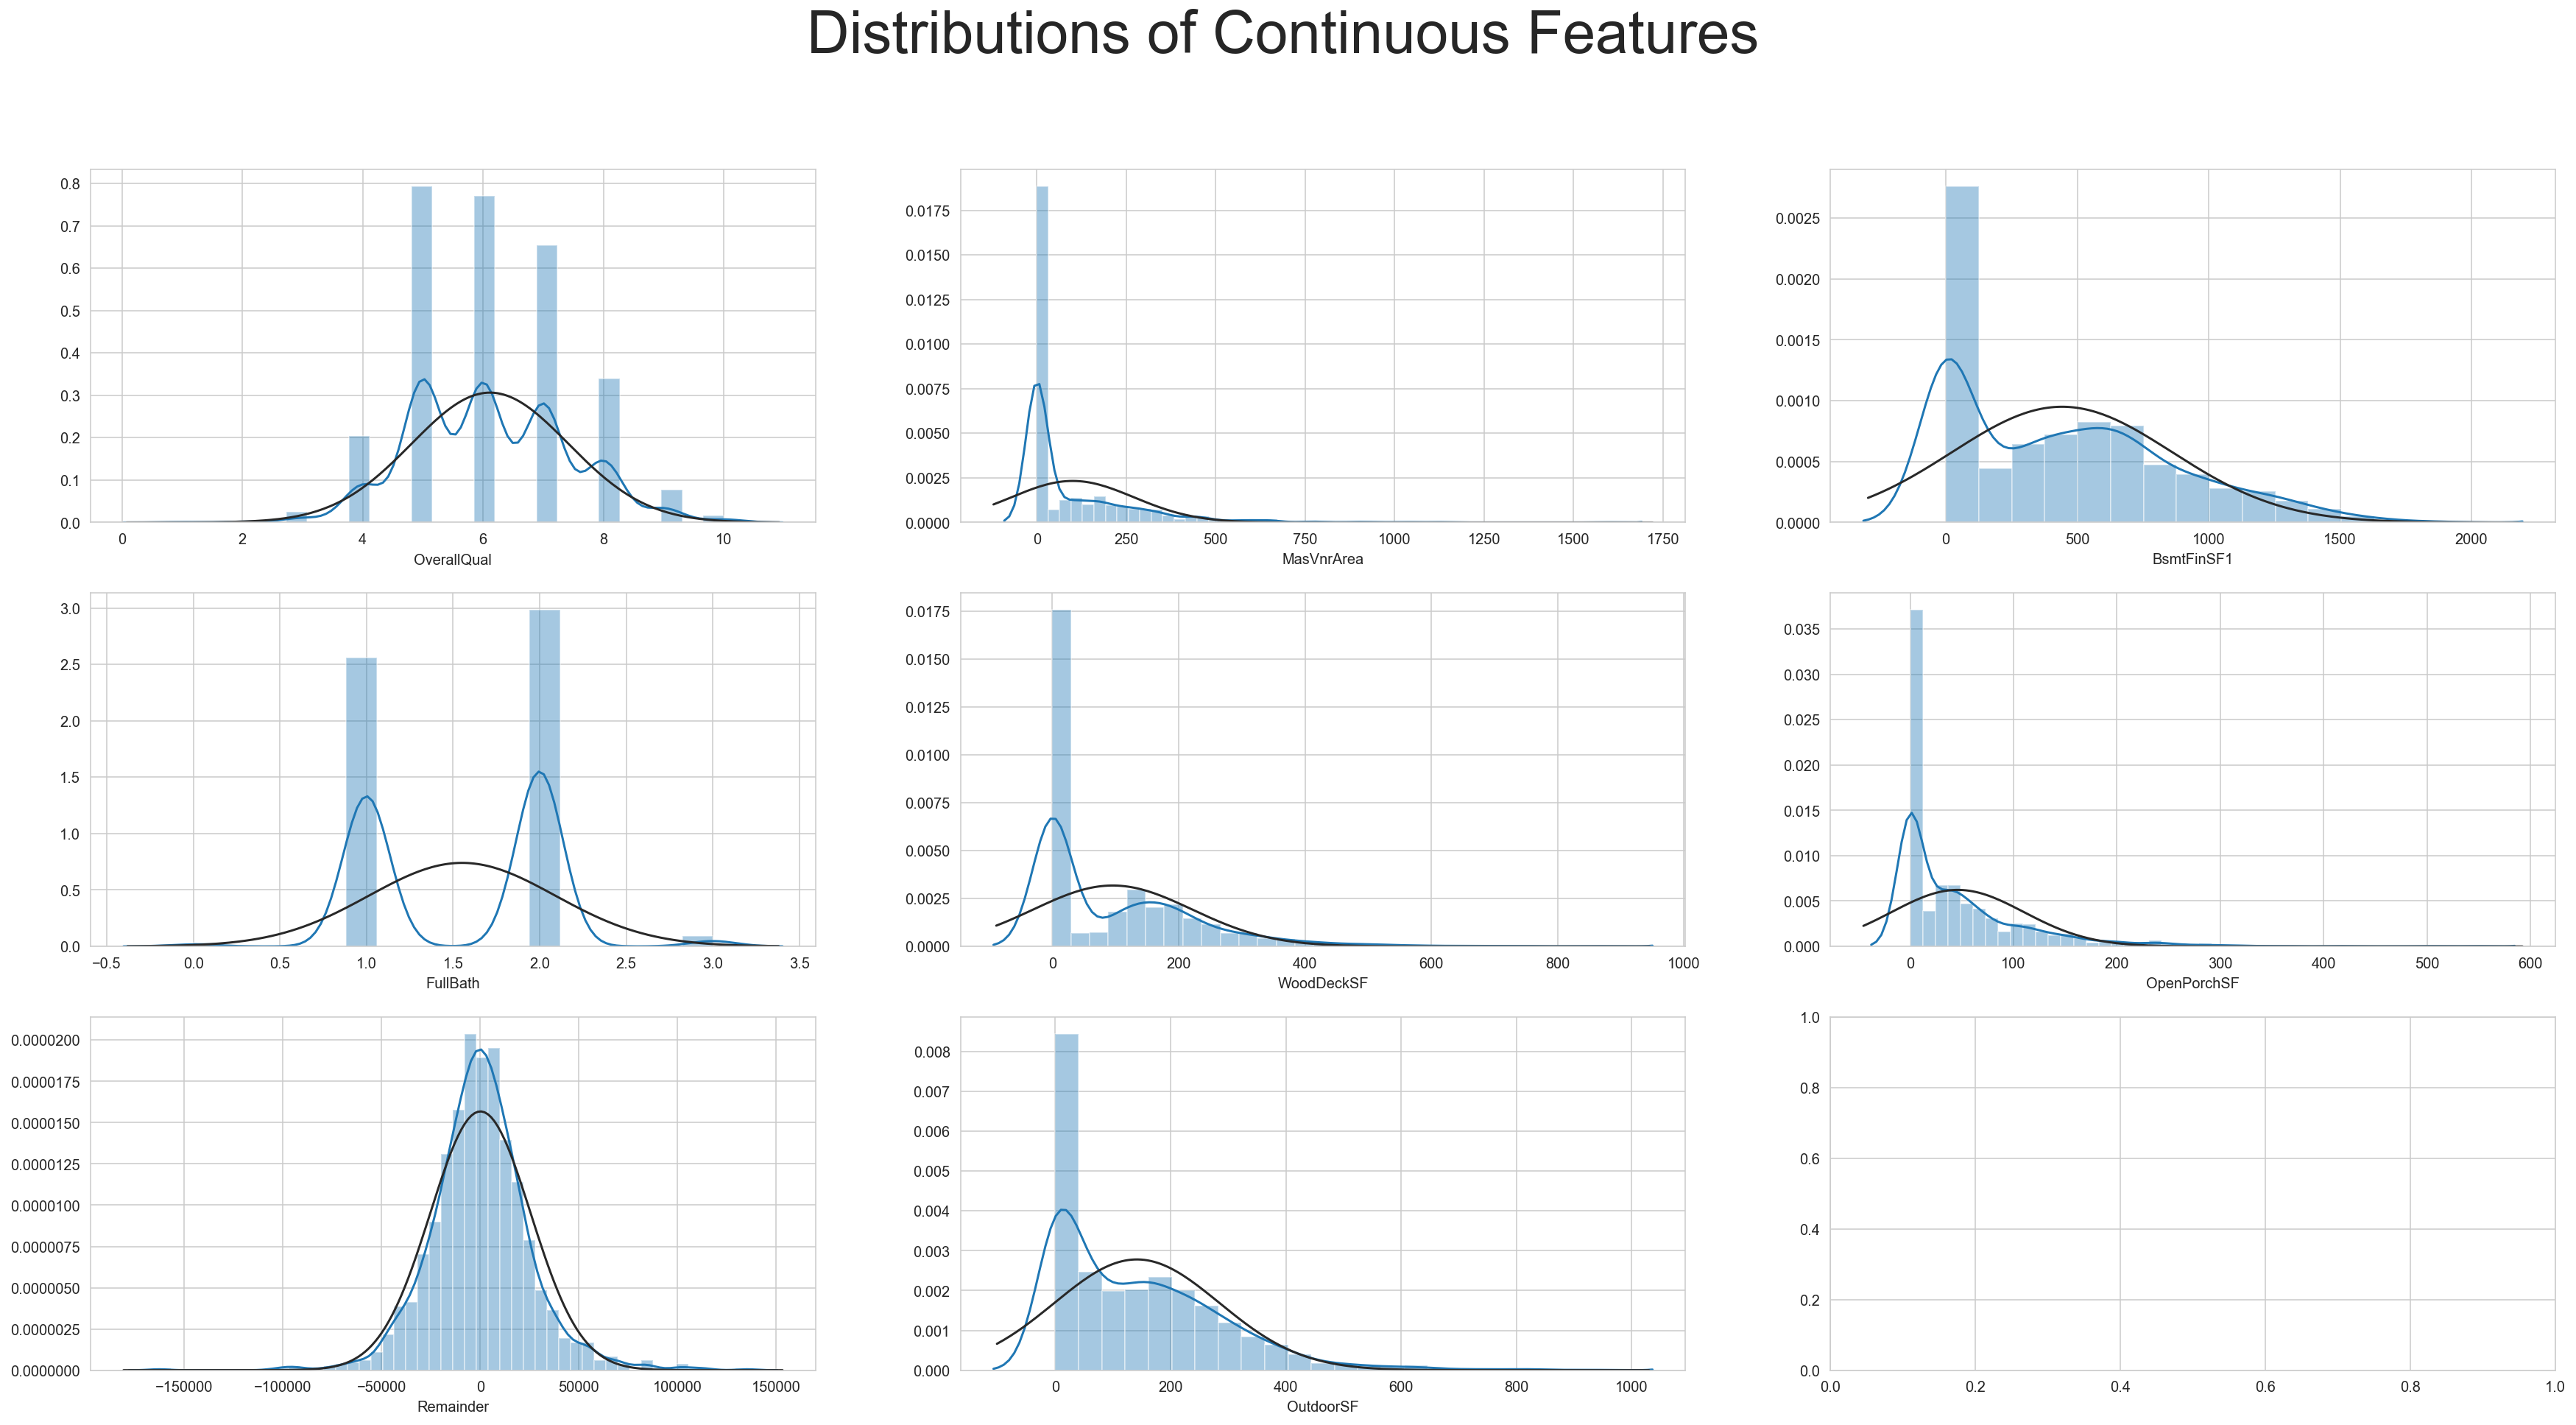

In [116]:
#looking at distributions for all continuous features
fig, axes = plt.subplots(3,3, figsize=(30,15))

fig.suptitle('Distributions of Continuous Features',fontsize=40)

col=0
row=0

for column in change_numeric_vars:
    sns.distplot(change_house[column], fit=stats.norm, ax=axes[row][col])
    if col == 2:
        row +=1
        col = 0
    else:
        col += 1

0.15728590867084652


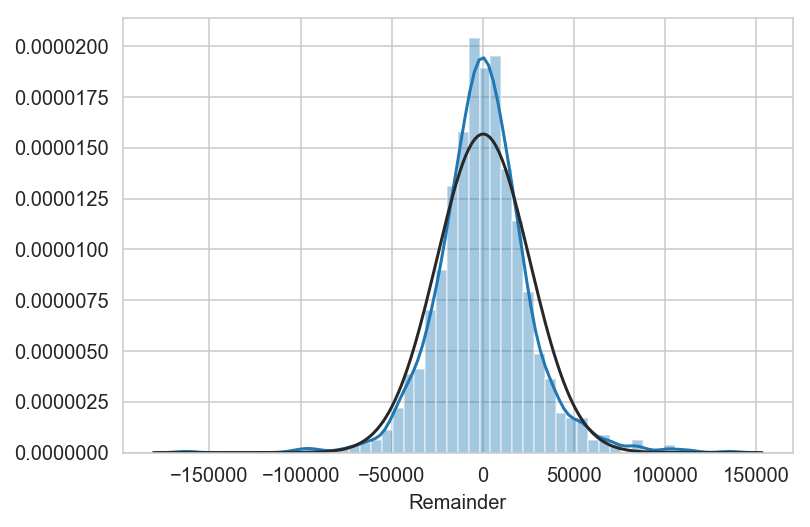

In [117]:
#Let's have a closer look at our target
print(stats.skew(change_house.Remainder))
sns.distplot(change_house.Remainder, fit=stats.norm)

In [118]:
#looking at potential outliers in our target, but given that we're trying to explain the 
#remaining variation, likely to leave them in until we see what other pieces look like
print(change_house[change_house['Remainder'] > change_house['Remainder'].quantile(.99)].shape[0])


14


In [119]:
change_house[np.abs(change_house.Remainder - change_house.Remainder.mean()) 
            >= (3*change_house.Remainder.std())].Remainder.count()


19

FullBath
0      8
1    625
2    728
3     22
Name: Remainder, dtype: int64


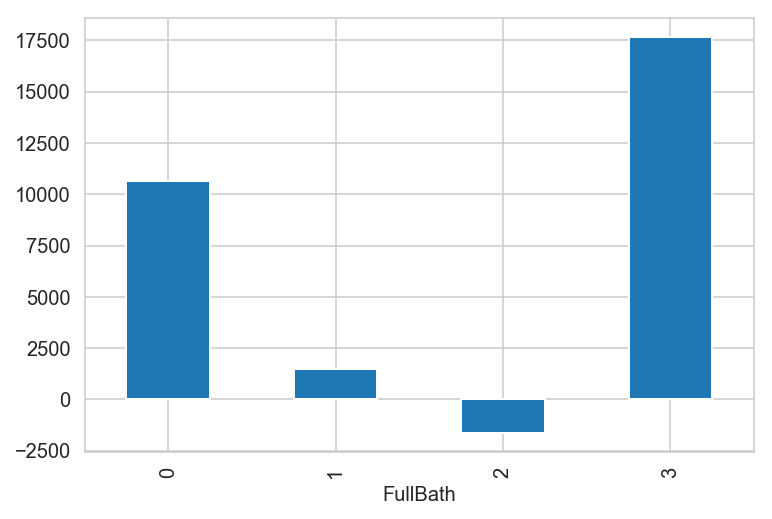

In [120]:
#If using FullBath as a feature, probably worth removing the small number of zeros, and maybe the 3s
#Interesting that having a second full bath negatively correlates with our target

change_house.groupby('FullBath')['Remainder'].mean().plot(kind='bar')
print(change_house.groupby('FullBath')['Remainder'].count())

In [121]:
plot_options = change_numeric_vars.copy()
plot_options.remove('Remainder')

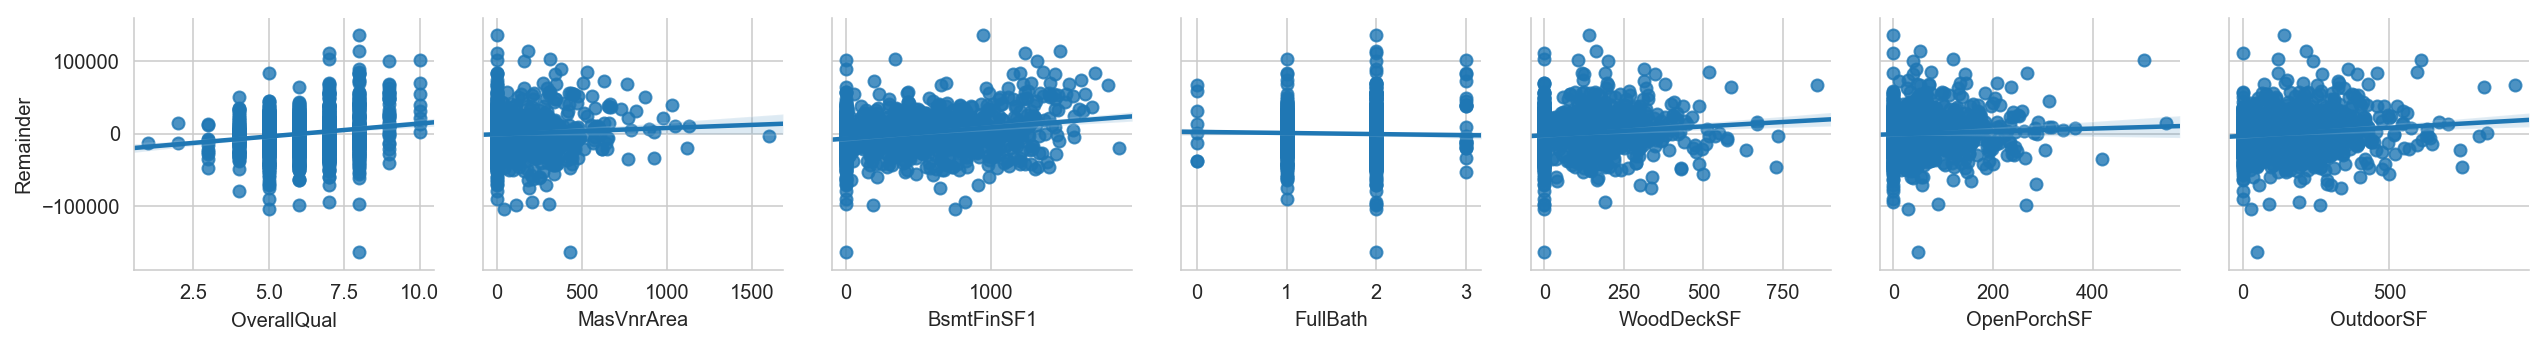

In [122]:
plot_data = change_house[change_numeric_vars]

sns.pairplot(y_vars='Remainder', x_vars=plot_options, data=plot_data, kind='reg')

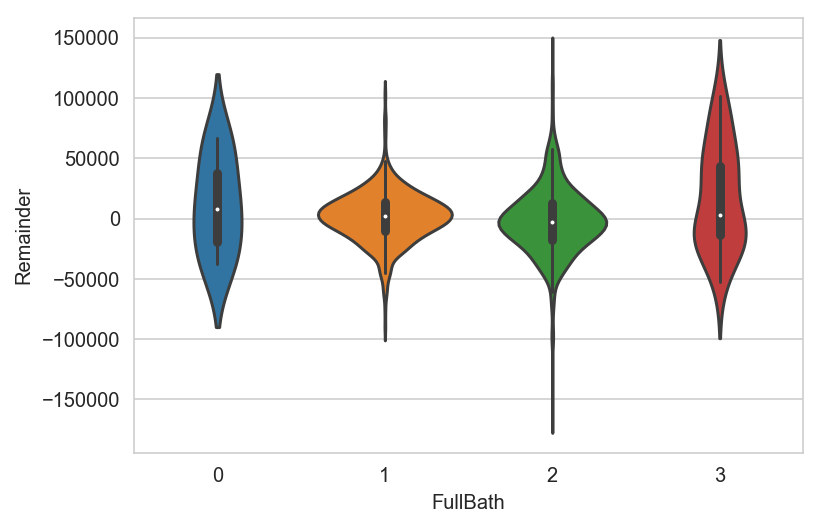

In [123]:
sns.violinplot(y = 'Remainder', x = 'FullBath', data=plot_data)


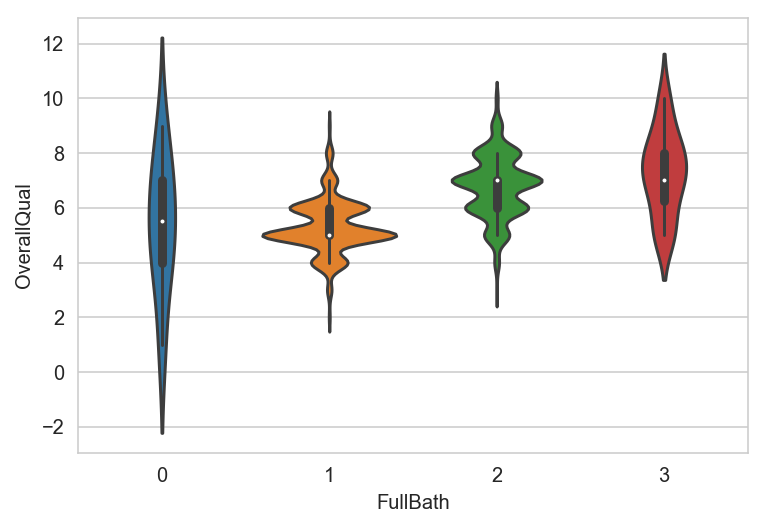

In [124]:
sns.violinplot(y = 'OverallQual', x = 'FullBath', data=plot_data)

In [125]:
print(house.shape)
print(change_house.shape)

#Number of full baths looks connected to overall quality, once zeros are removed, but not clearly connected to target
#Houses without bathrooms seem unlikely, so removing rows with zeros
house.drop(change_house[change_house.FullBath == 0].index, inplace=True)
change_house.drop(change_house[change_house.FullBath == 0].index, inplace=True)

print(house.shape)
print(change_house.shape)

(1383, 59)
(1383, 28)
(1375, 59)
(1375, 28)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


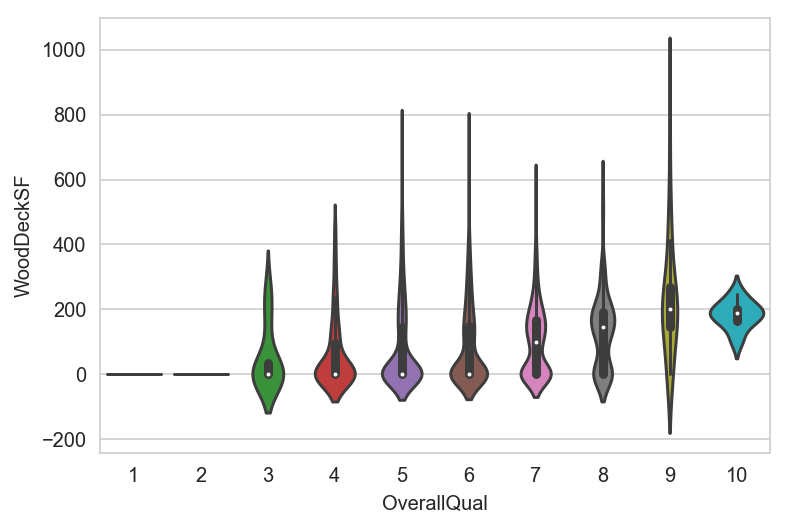

In [126]:
sns.violinplot(x = 'OverallQual', y = 'WoodDeckSF', data=plot_data)

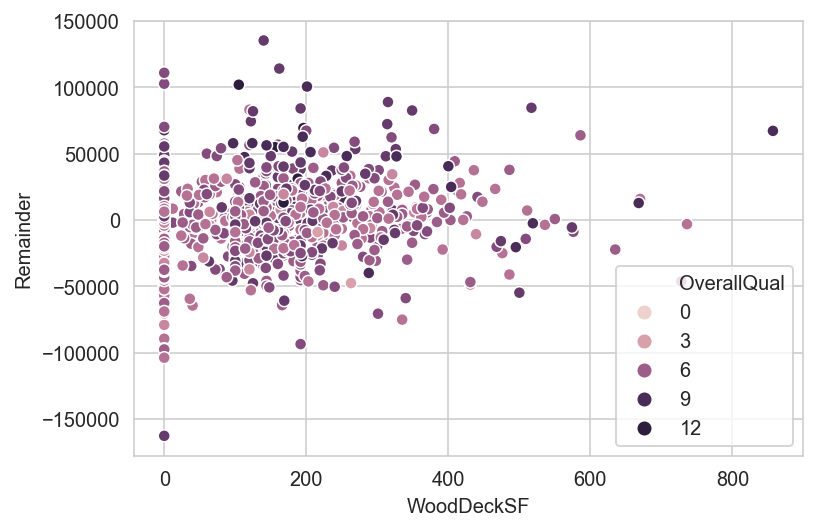

In [127]:
sns.scatterplot(x='WoodDeckSF', y='Remainder', hue = 'OverallQual', data=plot_data)

Unclear exactly what might be useful. Going to have an initial look at categorical variables.

In [128]:
change_obj_columns = change_house.select_dtypes(include='object').columns

In [129]:
change_house[change_obj_columns].describe().T

count unique      top  freq
RoofMatl      1375      7  CompShg  1355
Exterior1st   1375     14  VinylSd   491
Exterior2nd   1375     16  VinylSd   481
MasVnrType    1375      4     None   812
ExterQual     1375      4       TA   859
ExterCond     1375      5       TA  1209
BsmtCond      1375      4       TA  1268
BsmtFinType1  1375      6      Unf   416
BsmtFinType2  1375      6      Unf  1211
Heating       1375      4     GasA  1350
HeatingQC     1375      5       Ex   704
CentralAir    1375      2        Y  1301
Electrical    1375      5    SBrkr  1269
KitchenQual   1375      4       TA   693
FireplaceQu    731      5       Gd   356
GarageFinish  1375      4      Unf   570
GarageQual    1375      6       TA  1238
GarageCond    1375      6       TA  1254
PavedDrive    1375      3        Y  1271
MoSold        1375     12      jun   238

In [130]:
low_var_columns = [column for column in change_obj_columns 
                   if change_house[column].value_counts().max() > 1414*.75]

low_var_columns

['RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageQual',
 'GarageCond',
 'PavedDrive']

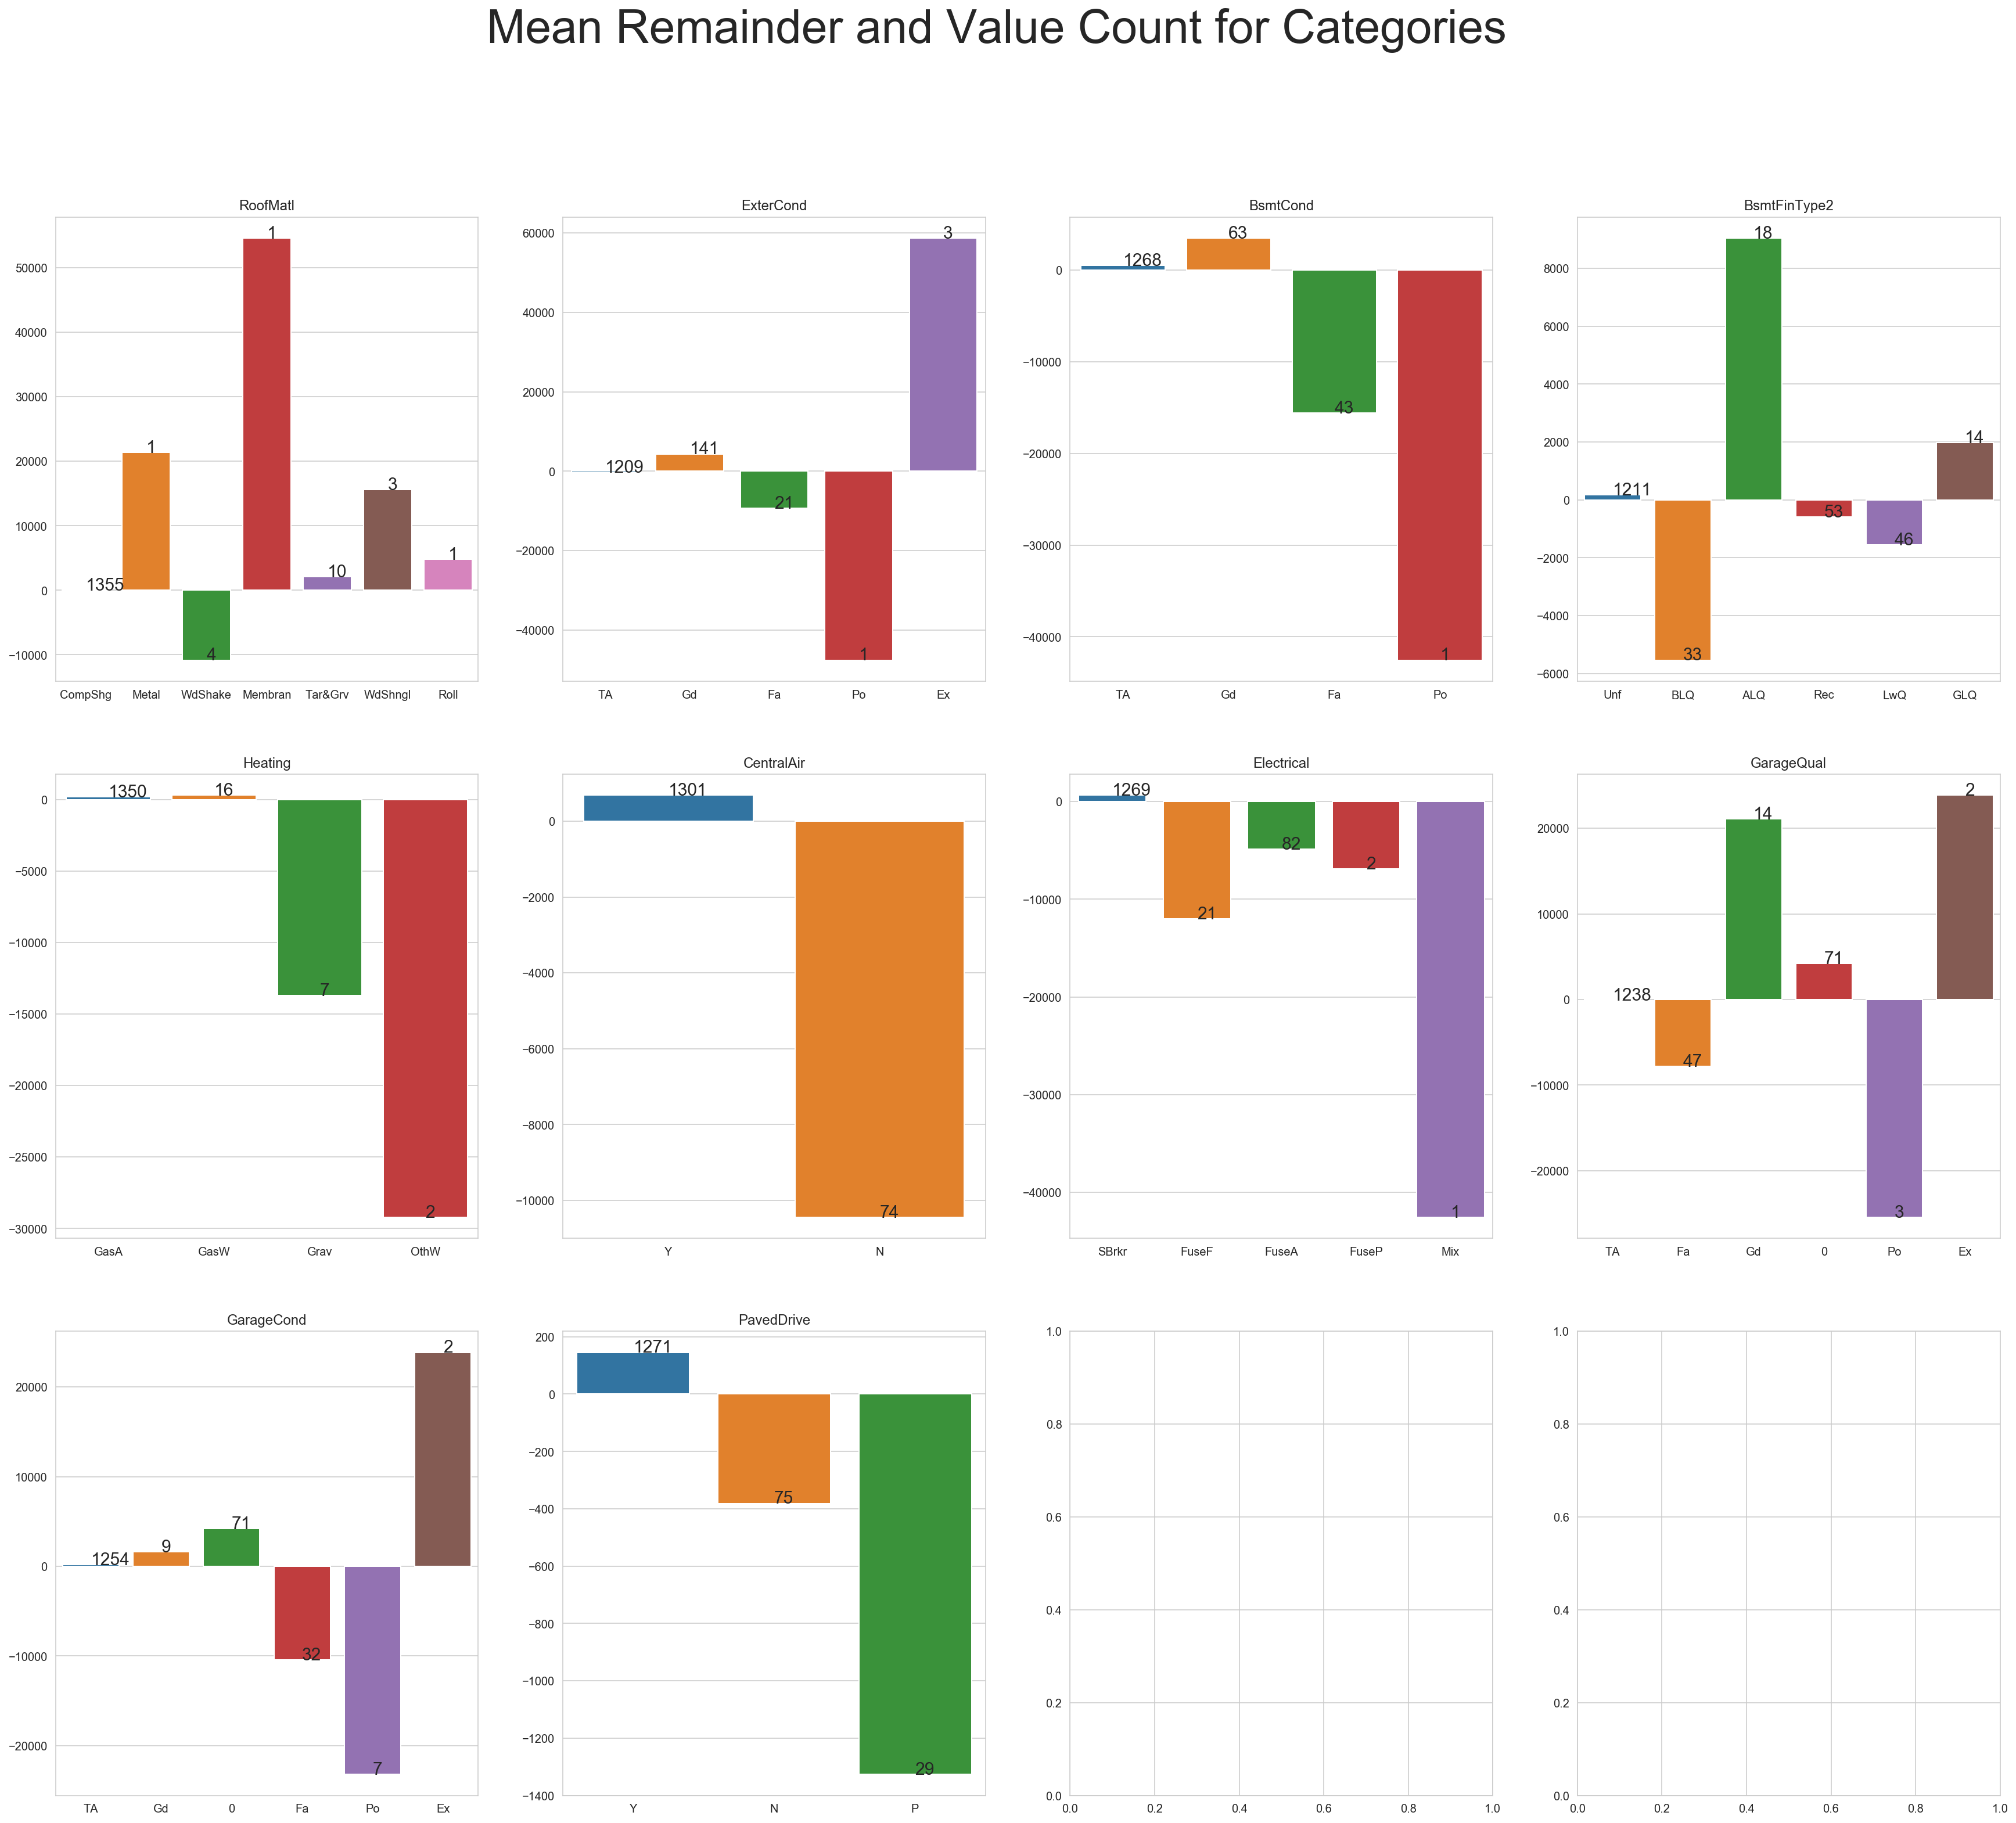

In [131]:
#for category in column
#calculate mean of Remainder
#graph


fig, axes = plt.subplots(3,4, figsize=(30,25))

fig.suptitle('Mean Remainder and Value Count for Categories',fontsize=40)

graph = 1

for column in low_var_columns:
    categories = []
    category_means = []

    for category in change_house[column].unique():
        category_mean = change_house[change_house[column] == category].Remainder.mean()
        category_means.append(category_mean)
        categories.append(category)
        
    ax1 = plt.subplot(3,4,graph)
    sns.barplot(x=change_house[column].unique(), y=category_means, ax=ax1)
    ax1.set_title(str(column))
    
    #add count of values in category
    counter = 0
    for i in ax1.patches:
        cat = categories[counter]
        # get_x pulls left or right; get_height pushes up or down
        ax1.text(i.get_x()+0.4, i.get_height()+.5, \
                str((change_house[column] == cat).sum()), fontsize=15)
        counter += 1

    graph += 1

These columns are low variance, but all show signficant variance relative to our target. In particular, the most common feature is often showing lower value, meaning it offers potential for renovations. As this question is about the impact of specific features, waiting on further investigation before choosing to discard features, although establishing stastical validity with most of these is unlikely GarageCond and GarageQual look to be highly correlated.

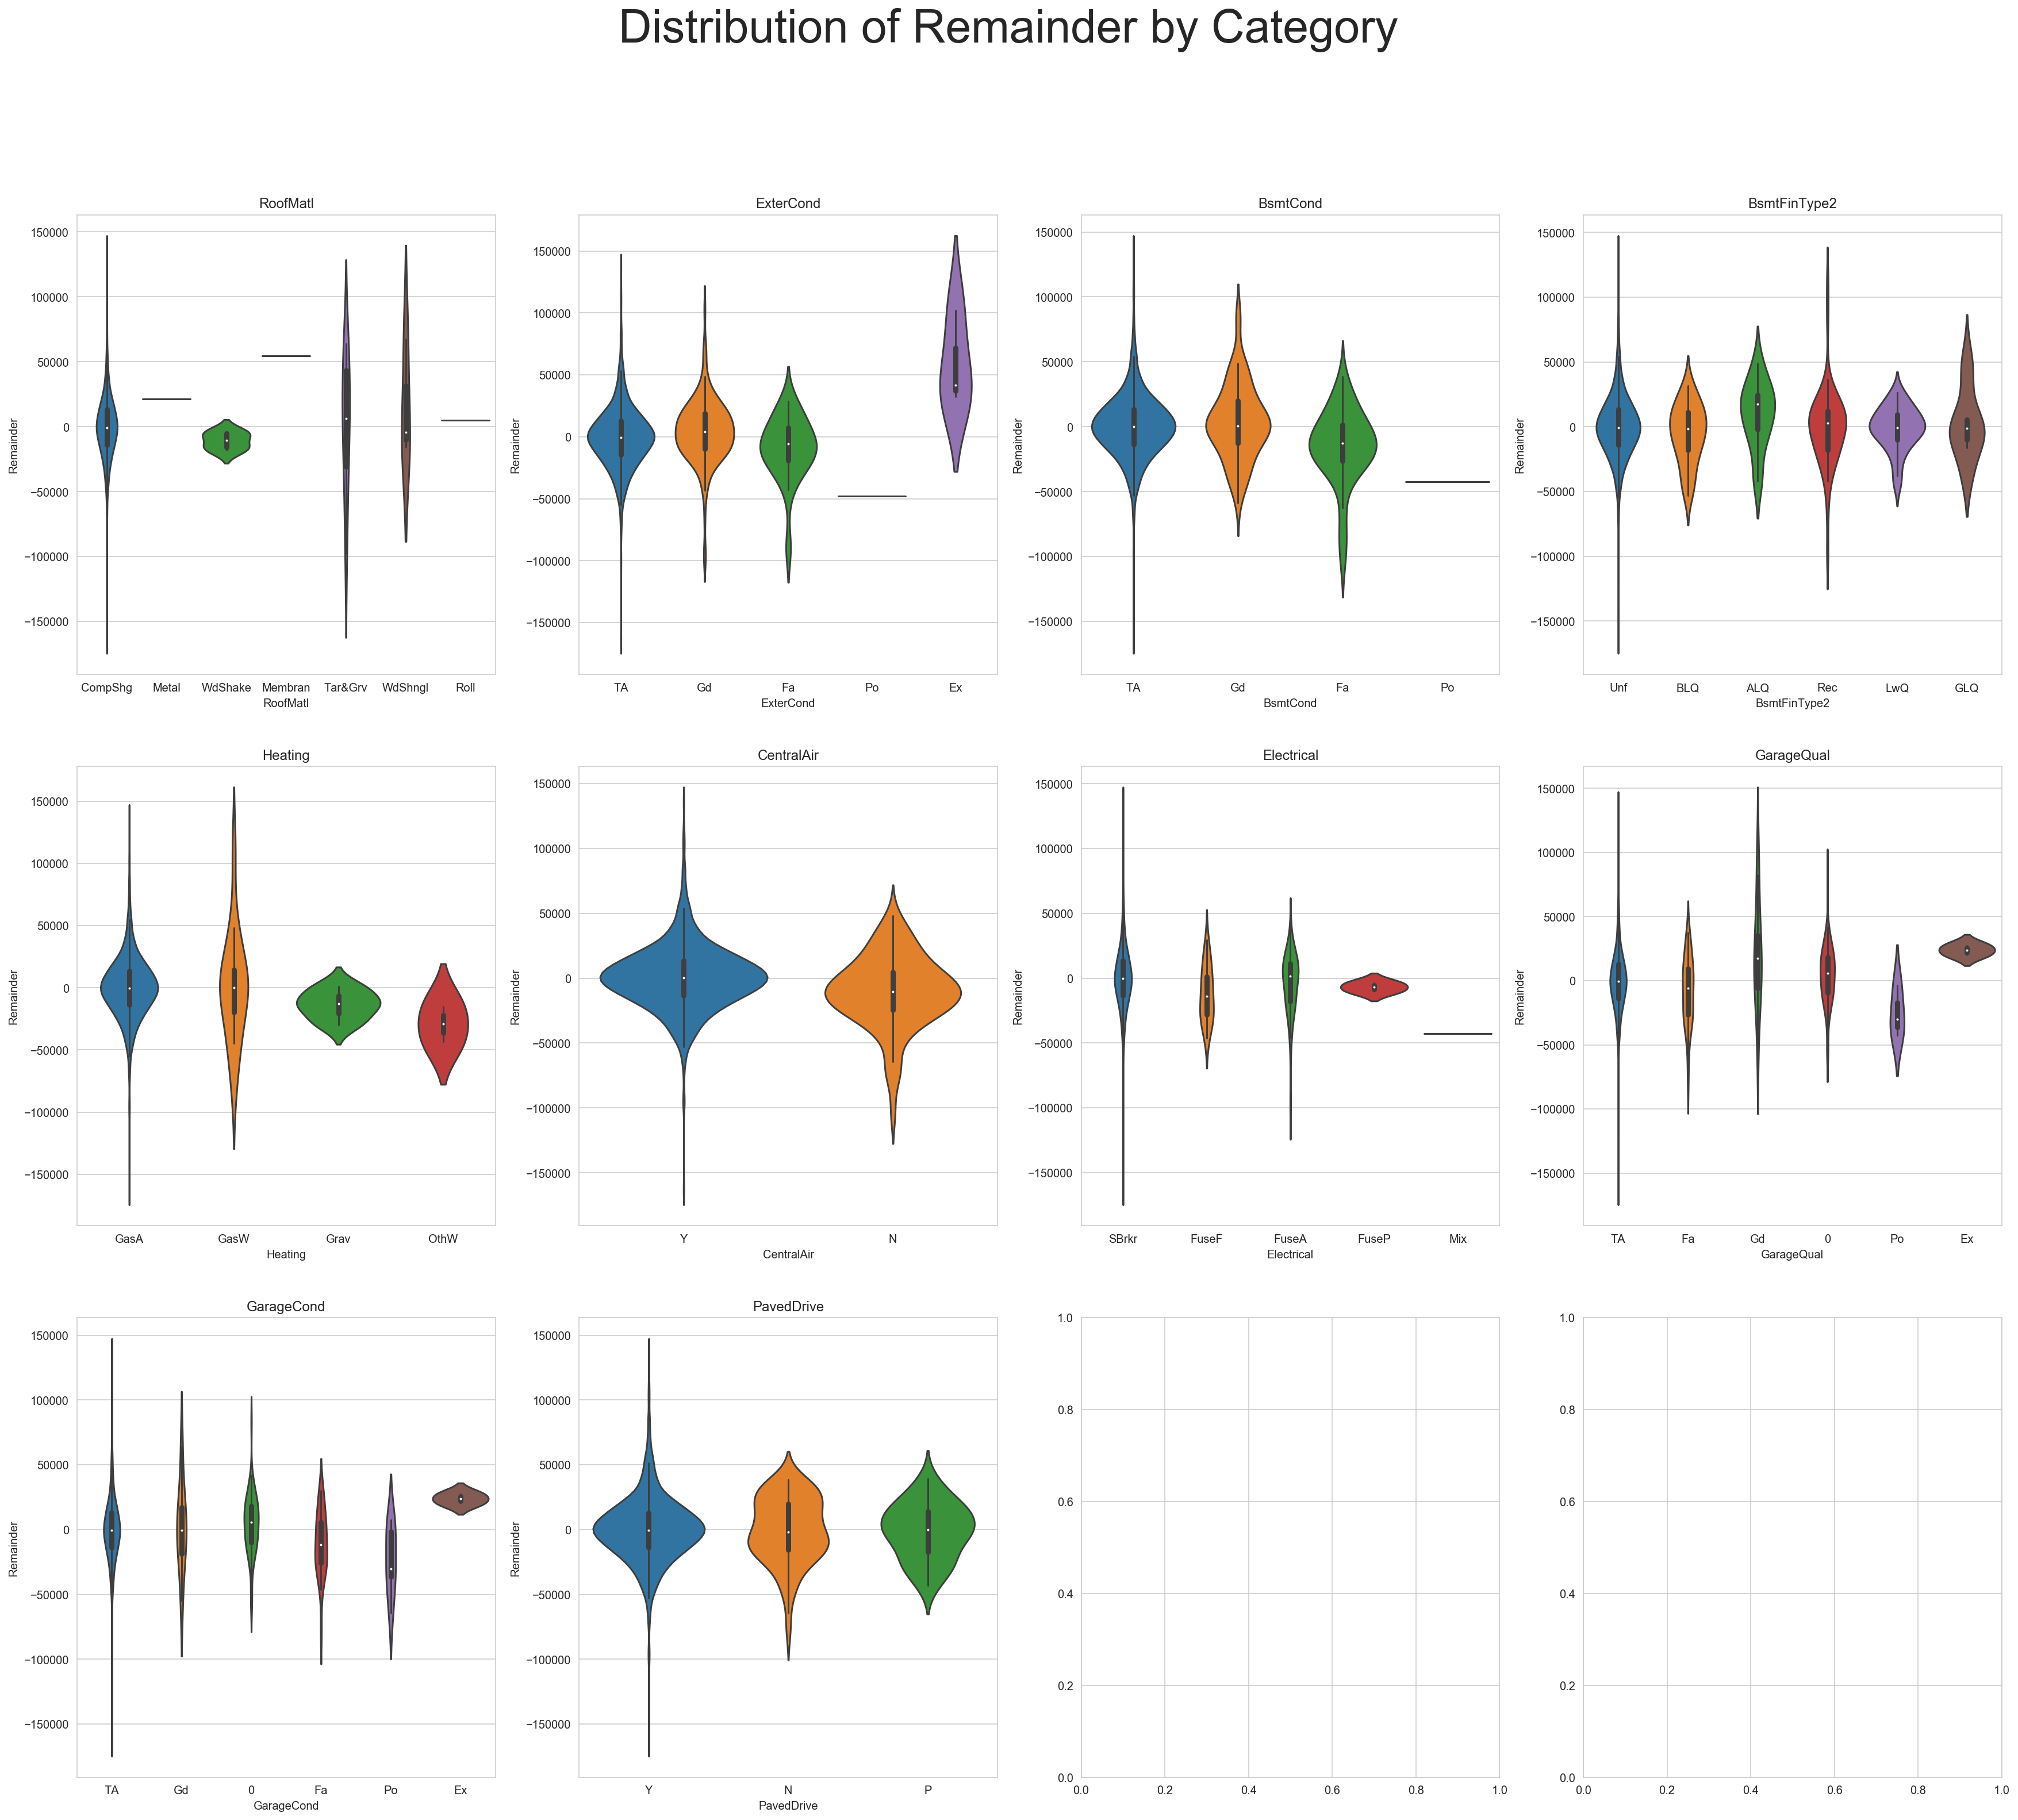

In [132]:
#for category in column
#calculate mean of Remainder
#graph

plot_data_columns = low_var_columns + ['Remainder']
plot_data = change_house[plot_data_columns]

fig, axes = plt.subplots(3,4, figsize=(30,25))

fig.suptitle('Distribution of Remainder by Category',fontsize=40)

graph = 1
                         
for column in low_var_columns:
    categories = []
    category_means = []

    for category in change_house[column].unique():
        category_mean = change_house[change_house[column] == category].Remainder.mean()
        category_means.append(category_mean)
        categories.append(category)
        
    sorted_means = sorted(category_means)

    ax1 = plt.subplot(3,4,graph)
    sns.violinplot(y = 'Remainder', x = column, data=plot_data)    
    
    ax1.set_title(str(column))
    
    #add count of values in category
    counter = 0
    for i in ax1.patches:
        cat = categories[counter]
        # get_x pulls left or right; get_height pushes up or down
        ax1.text(i.get_x()+0.4, i.get_height()+.5, \
                str((change_house[column] == cat).sum()), fontsize=15)
        counter += 1

    graph += 1


In [133]:
#separating into various types
change_time_cols = 'MoSold'

change_ordinal_cols = [column for column in change_obj_columns 
                        if (('Q' in column) or ('Cond' in column) or ('Fin' in column))]

change_categorical_cols = [column for column in change_obj_columns 
                            if ((column not in change_ordinal_cols) and (column not in change_time_cols))]



In [134]:
#checking column assignments as expected
print(change_time_cols)
print('---------------')

print(change_ordinal_cols)
print('---------------')

print(change_categorical_cols)

#checking numbers of columns match original list
print((1 + len(change_ordinal_cols) + len(change_categorical_cols)), change_house[change_obj_columns].shape[1])


MoSold
---------------
['ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']
---------------
['RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Heating', 'CentralAir', 'Electrical', 'PavedDrive']
20 20


In [135]:
#Need to remember FireplaceQu still has missing data, so can only be used in some sort of split model
change_house[change_ordinal_cols].isna().sum()

ExterQual         0
ExterCond         0
BsmtCond          0
BsmtFinType1      0
BsmtFinType2      0
HeatingQC         0
KitchenQual       0
FireplaceQu     644
GarageFinish      0
GarageQual        0
GarageCond        0
dtype: int64

In [136]:
#creating dictionary to change standard qual/cond variables to ordinal
def qual_converter(x):
    qualities = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
    bsmtfin_qualities = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':2, 'LwQ':1, 'Unf':0}
    GarageFin_qualities = {'Fin':2, 'RFn':1, 'Unf':0}
    try:
        quality = qualities[x]
    except:
        try:
            quality = bsmtfin_qualities[x]
        except:
            try:
                quality = GarageFin_qualities[x]
            except:
                quality = x
    return(quality)
 

In [137]:
unchanged_columns = []
for column in change_ordinal_cols:
    change_house[column] = change_house[column].map(lambda x: qual_converter(x))
    try:
        change_house[column].to_dtype('int32', inplace=True)
    except:
        if change_house[column].dtype == 'object':
            unchanged_columns.append(column)
        else:
            pass

print(unchanged_columns)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[]


In [138]:
change_house.dtypes

OverallQual       int64
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
ExterQual         int64
ExterCond         int64
BsmtCond          int64
BsmtFinType1      int64
BsmtFinSF1        int64
BsmtFinType2      int64
Heating          object
HeatingQC         int64
CentralAir       object
Electrical       object
FullBath          int64
KitchenQual       int64
FireplaceQu     float64
GarageFinish      int64
GarageQual        int64
GarageCond        int64
PavedDrive       object
WoodDeckSF        int64
OpenPorchSF       int64
MoSold           object
Remainder       float64
OutdoorSF         int64
dtype: object

In [139]:
print(change_numeric_vars)
print('------------------')

print(change_categorical_cols)
print('------------------')

print(change_ordinal_cols)


['OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'FullBath', 'WoodDeckSF', 'OpenPorchSF', 'Remainder', 'OutdoorSF']
------------------
['RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Heating', 'CentralAir', 'Electrical', 'PavedDrive']
------------------
['ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']


In [140]:
#adjusting column lists

#create continuous column list
change_continuous_cols = change_numeric_vars.copy()
change_continuous_cols.remove('OverallQual')

#collect continuous and ordinal together
change_numeric_vars.extend(change_ordinal_cols)

#add qual to ordinal
change_ordinal_cols.append('OverallQual')

print(change_numeric_vars)
print('------------------')

print(change_continuous_cols)
print('------------------')

print(change_ordinal_cols)
print('------------------')

print(change_categorical_cols)
print('------------------')

print(change_time_cols)


['OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'FullBath', 'WoodDeckSF', 'OpenPorchSF', 'Remainder', 'OutdoorSF', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']
------------------
['MasVnrArea', 'BsmtFinSF1', 'FullBath', 'WoodDeckSF', 'OpenPorchSF', 'Remainder', 'OutdoorSF']
------------------
['ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'OverallQual']
------------------
['RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Heating', 'CentralAir', 'Electrical', 'PavedDrive']
------------------
MoSold


In [141]:
#let's have another quick look at our initial correlations for numeric variables
change_house.corrwith(y_hat_all)

OverallQual     0.178
MasVnrArea      0.060
ExterQual       0.132
ExterCond       0.102
BsmtCond        0.099
BsmtFinType1    0.220
BsmtFinSF1      0.248
BsmtFinType2    0.002
HeatingQC       0.093
FullBath       -0.026
KitchenQual     0.190
FireplaceQu     0.091
GarageFinish    0.079
GarageQual      0.019
GarageCond      0.011
WoodDeckSF      0.108
OpenPorchSF     0.049
Remainder       1.000
OutdoorSF       0.117
dtype: float64

A few of our new ordinal features show some degree of correlation with target, particularly ExterQual, BsmtFinType1, and KitchenQual

Looking more closely at correlations among our continouous group to see if any can be removed from consideration.

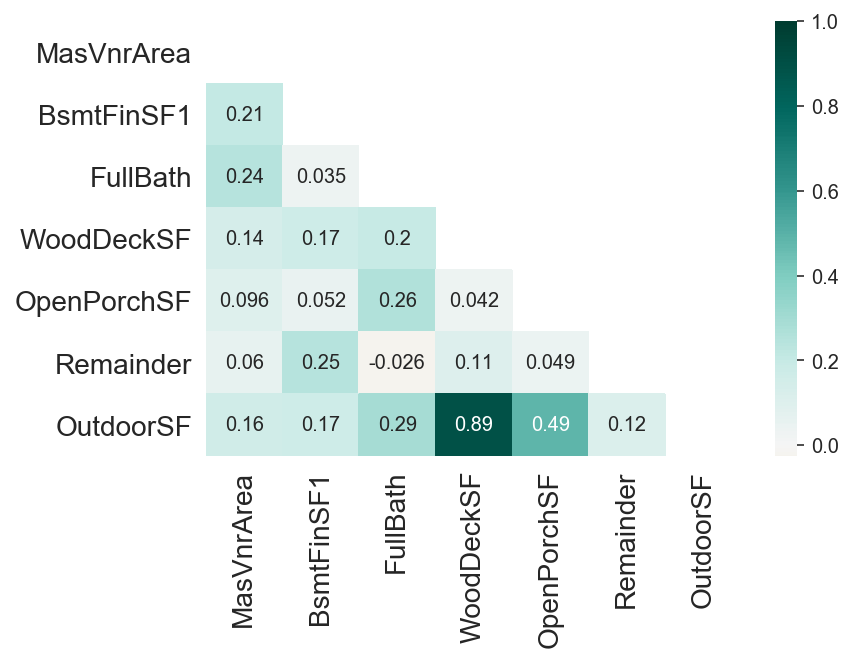

In [142]:
columns = change_continuous_cols

fix, ax = plt.subplots()

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(change_house[columns].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
ax = sns.heatmap(change_house[columns].corr(), annot=True, center=0, cmap='BrBG', mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

In [143]:
#All correlations are low, so setting the bar for consideration fairly low
#BsmtFinSF1, OutdoorSF, and maybe MasVnrArea could be worth trying
#Keeping OutdoorSF over Porth/WoodDeck & dropping FullBath from consideration

change_cont_features = ['BsmtFinSF1', 'OutdoorSF', 'MasVnrArea']

In [144]:
#removing overall quality from the viewing set
change_numeric_vars.remove('OverallQual')
change_ordinal_cols.remove('OverallQual')

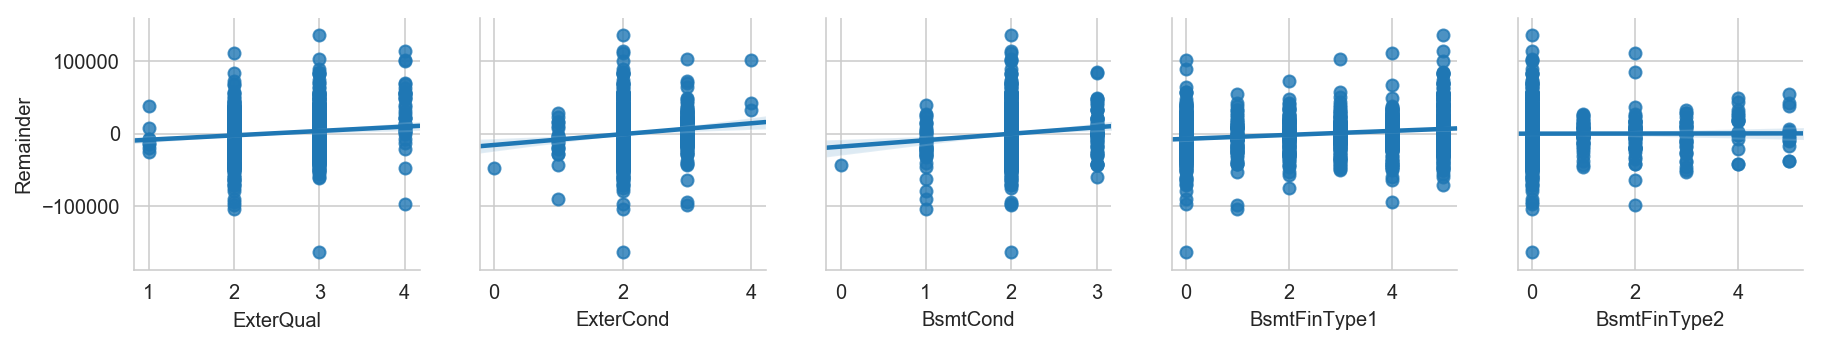

In [145]:
#How do our ordinal variables look when considered as continouous?


columns = change_ordinal_cols[0:5] + ['Remainder']
plot_data = change_house[columns]

sns.pairplot(y_vars='Remainder', x_vars=change_ordinal_cols[0:5], data=plot_data, kind='reg')

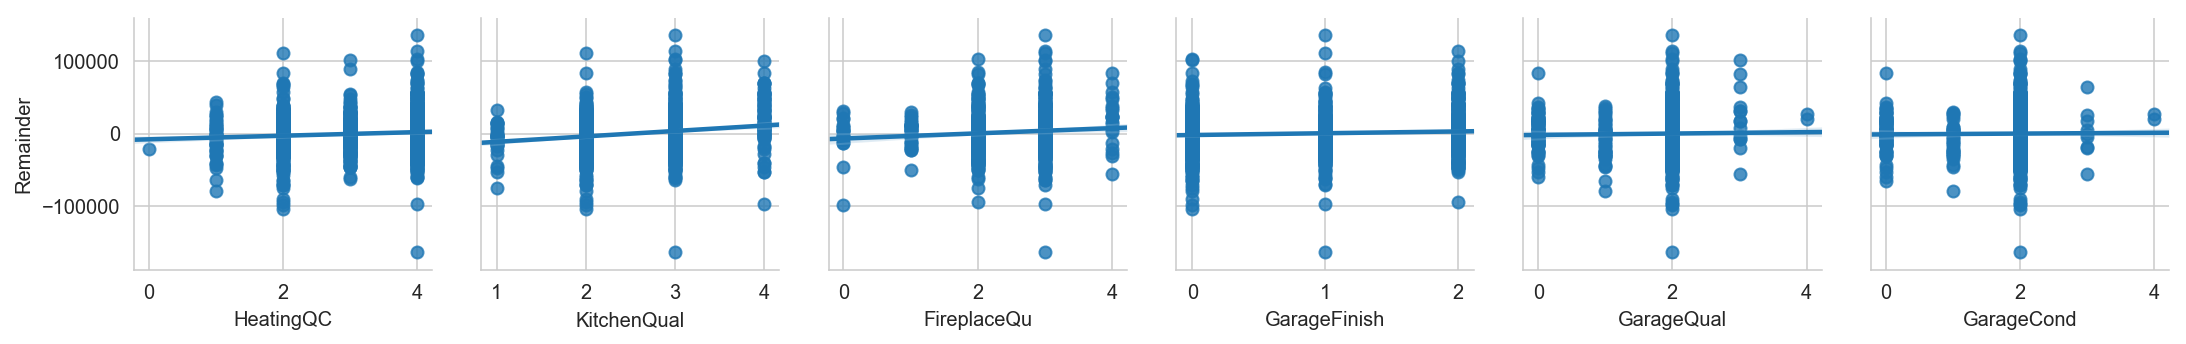

In [146]:
#How do our ordinal variables look when considered as continouous?
columns = change_ordinal_cols[5:] + ['Remainder']
plot_data = change_house[columns]

sns.pairplot(y_vars='Remainder', x_vars=change_ordinal_cols[5:], data=plot_data, kind='reg')

It looks like there are a few outliers visible in these, which have generally higher quality ratings, but price is well below the predicted price for our model.

In [147]:
change_house[(change_house.KitchenQual == 3) & (change_house.Remainder < -100000)]
change_house[(change_house.KitchenQual == 4) & (change_house.Remainder < -90000)]


OverallQual RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea  \
581            8  CompShg     VinylSd     VinylSd    BrkFace     306.000   

     ExterQual  ExterCond  BsmtCond  BsmtFinType1  ...  FireplaceQu  \
581          4          2         2             0  ...        3.000   

     GarageFinish GarageQual  GarageCond PavedDrive WoodDeckSF  OpenPorchSF  \
581             1          2           2          Y          0           90   

     MoSold  Remainder  OutdoorSF  
581     aug -97036.555         90  

[1 rows x 28 columns]

In [148]:
# this seems to have been removed elsewhere, no longer needed
# change_house[(change_house.ExterQual == 5) & (change_house.Remainder < -50000)]

In [149]:
#removing these rows and looking at the results
change_house.drop(change_house[(change_house.KitchenQual == 4) & (change_house.Remainder < -90000)].index, inplace=True)
# change_house.drop(change_house[(change_house.ExterQual == 5) & (change_house.Remainder < -50000)].index, inplace=True)
change_house.drop(change_house[(change_house.KitchenQual == 3) & (change_house.Remainder < -100000)].index, inplace=True)

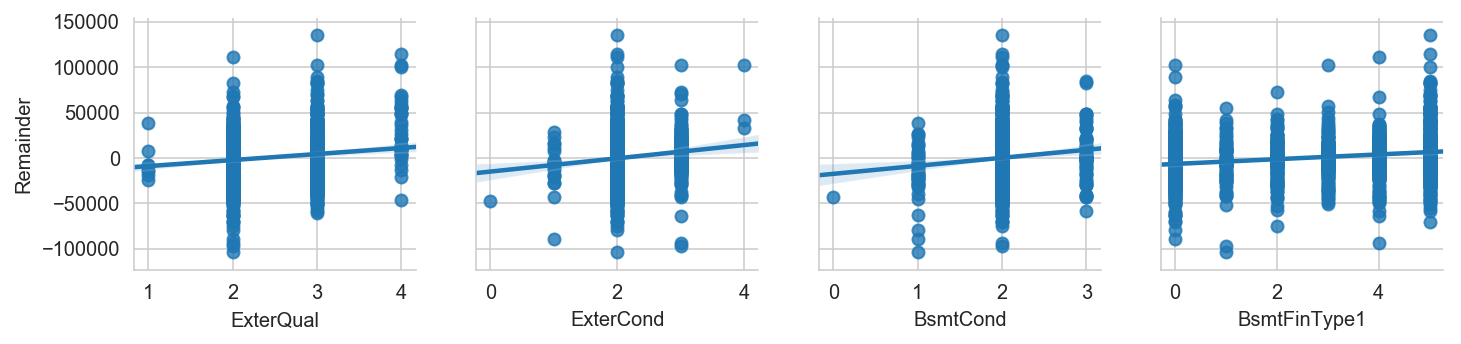

In [150]:
#How do our ordinal variables look when considered as continouous?
columns = change_ordinal_cols[0:4] + ['Remainder']
plot_data = change_house[columns]

sns.pairplot(y_vars='Remainder', x_vars=change_ordinal_cols[0:4], data=plot_data, kind='reg')

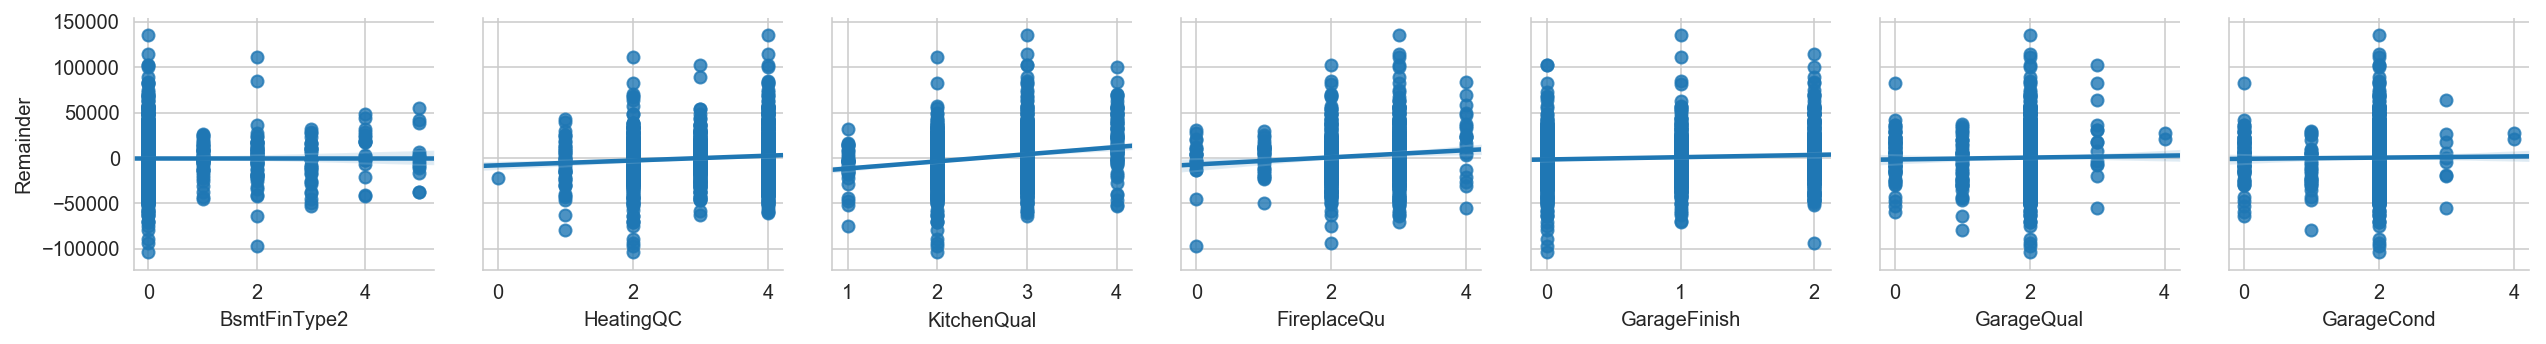

In [151]:
#How do our ordinal variables look when considered as continouous?
columns = change_ordinal_cols[4:] + ['Remainder']
plot_data = change_house[columns]

sns.pairplot(y_vars='Remainder', x_vars=change_ordinal_cols[4:], data=plot_data, kind='reg')

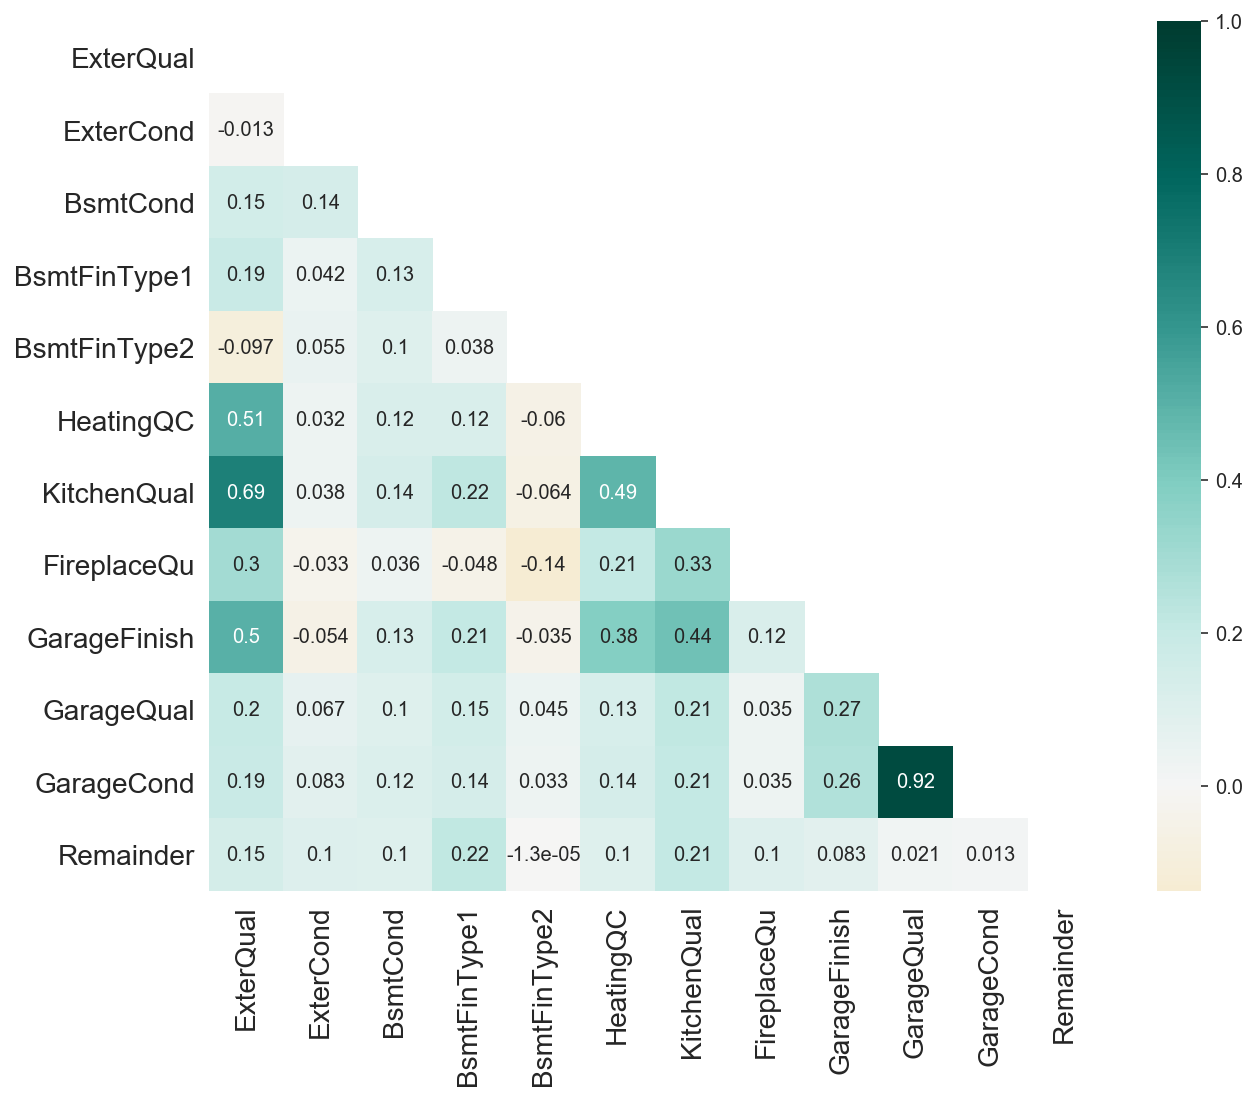

In [152]:
#let's try an ordinal heatmap
columns = change_ordinal_cols + ['Remainder']

fix, ax = plt.subplots(figsize=(10,8))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(change_house[columns].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
ax = sns.heatmap(change_house[columns].corr(), annot=True, center=0, cmap='BrBG', mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

__Strongest indicators are BsmtFinType1 & KitchenQual__

Looks like we can safely drop BsmtFinType2 from consideration

Wondering about creating features representing combined categories: 
* Basement - may need to model houses with basements separately to avoid the impace of the zeros/no basement
* Garage (possibly split into rebuild / finish), although GarageQual & GarageCond show no useful correlation
* Exterior
* Roof

To get the monetary information from our model, it would be cleaner to have features representing the overall impact of renovating each of these feature (e.g. a "renovating the basement" feature).

Other areas that could be separate include:
* Kitchen
* Fireplace - would likely need to model houses with Fireplace data separately, as it's about 50%, and the question is "what is the value of improving the quality of an existing fireplace", not whether or not to add a fireplace
* Bathroom - there is no bathroom quality metric, and simple numbers of bathrooms does not seem to be useful
* Heating / Cooling
* Outdoor 

In [153]:
change_ordinal_cols

['ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [154]:
#updating variables list
for column in ['BsmtFinType2','GarageQual','GarageCond']:
    change_ordinal_cols.remove(column)


In [155]:
#testing potential combined variables
new_col_df = pd.DataFrame()
new_col_df['ExterQC'] = change_house['ExterQual'] + change_house['ExterCond']
new_col_df['BsmtCombined1'] = change_house['BsmtFinSF1'] * change_house['BsmtFinType1']
new_col_df['BsmtCombined2'] = change_house['BsmtCond'] + change_house['BsmtFinType1']
new_col_df['BsmtCombined3'] = (change_house['BsmtCond'] + change_house['BsmtFinType1']) * change_house['BsmtFinSF1']
new_col_df['BsmtCombined4'] = change_house['BsmtCond'] * (change_house['BsmtFinType1'] * change_house['BsmtFinSF1'])

new_col_df['GarageCombined'] = change_house['GarageFinish'] * (change_house['GarageCond'] + change_house['GarageQual'])
new_col_df['Remainder'] = change_house['Remainder']

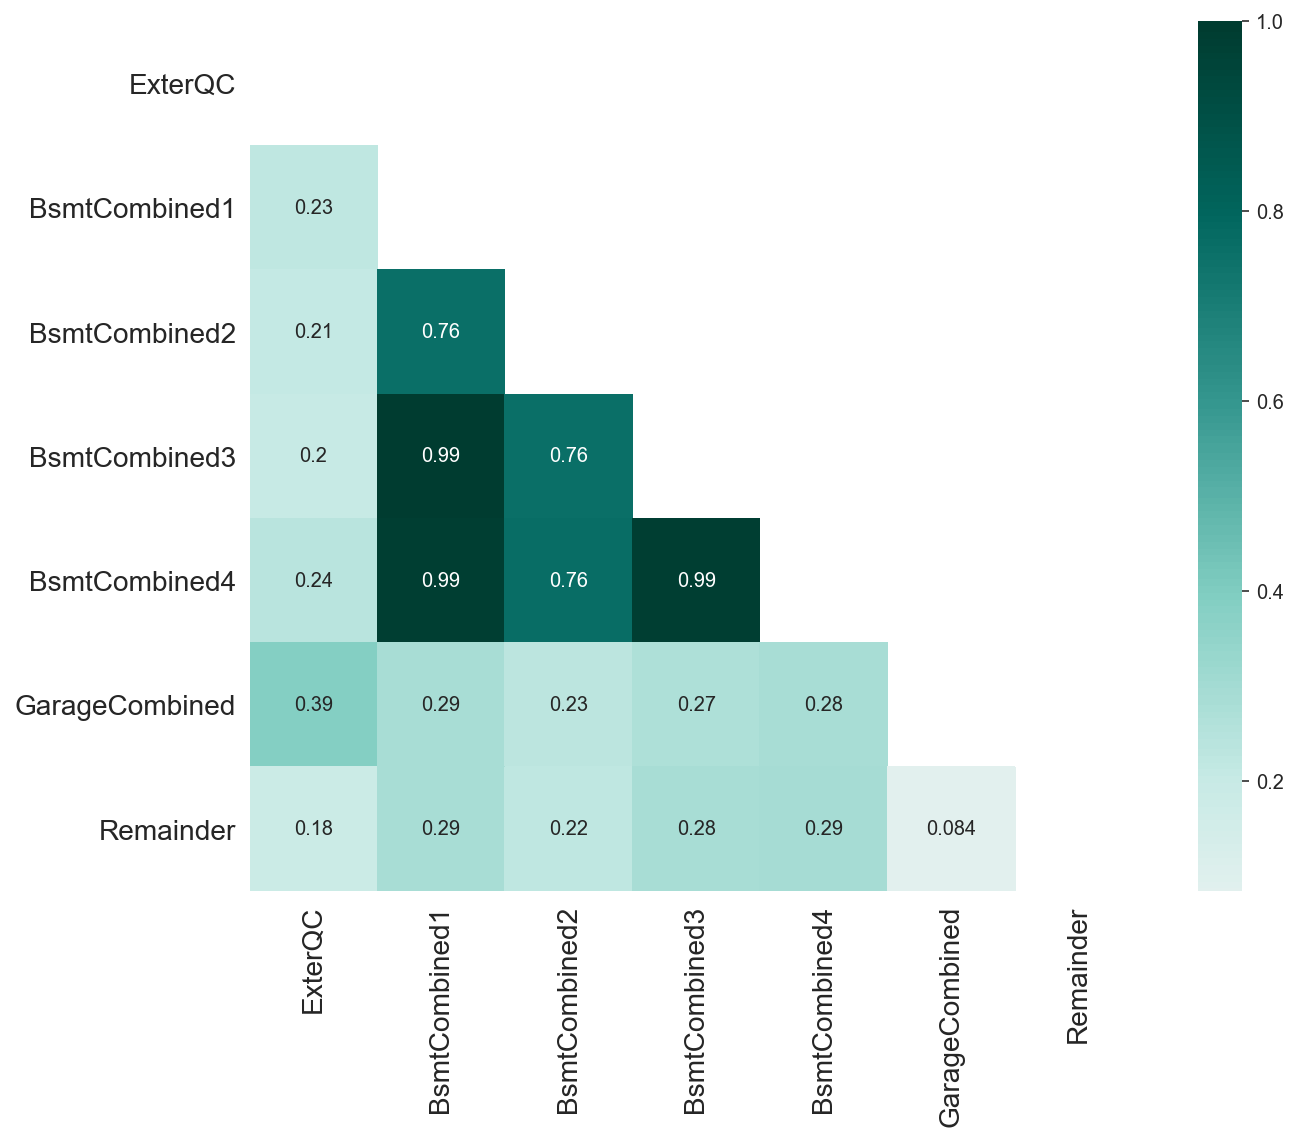

In [156]:
#any look useful?

fix, ax = plt.subplots(figsize=(10,8))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(new_col_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
ax = sns.heatmap(new_col_df.corr(), annot=True, center=0, cmap='BrBG', mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

### Well that's interesting...

__Garage looks useless__ Ditching consideration of adding/remodelling garage. 

__ExterQC could be useful, but how can it be interepreted?__

new_col_df['ExterQC'] = change_house['ExterQual'] + change_house['ExterCond'] - interpretation would be is there an improvment that would impact both of these measures equally? Not very specific, but possible

__Basement options__

The first is by far the easiest to interpret: adding a square feet of a certain, and has equal highest correlation, so will add this option for modelling 

new_col_df['BsmtCombined1'] = change_house['BsmtFinSF1'] * change_house['BsmtFinType1']


In [157]:
change_house['BsmtCombined'] = new_col_df['BsmtCombined1']
change_cont_features.append('BsmtCombined')
change_continuous_cols.append('BsmtCombined')

change_house['ExterQC'] = new_col_df['ExterQC']
change_ordinal_cols.append('ExterQC')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [158]:
print(change_house.columns)
print(change_continuous_cols)
print(change_ordinal_cols)
print(change_categorical_cols)

Index(['OverallQual', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'FullBath', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'MoSold', 'Remainder', 'OutdoorSF', 'BsmtCombined', 'ExterQC'],
      dtype='object')
['MasVnrArea', 'BsmtFinSF1', 'FullBath', 'WoodDeckSF', 'OpenPorchSF', 'Remainder', 'OutdoorSF', 'BsmtCombined']
['ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'ExterQC']
['RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Heating', 'CentralAir', 'Electrical', 'PavedDrive']


In [159]:
change_ordinal_features = ['BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'ExterQC']
print(change_ordinal_features)
print(change_cont_features)

['BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'ExterQC']
['BsmtFinSF1', 'OutdoorSF', 'MasVnrArea', 'BsmtCombined']


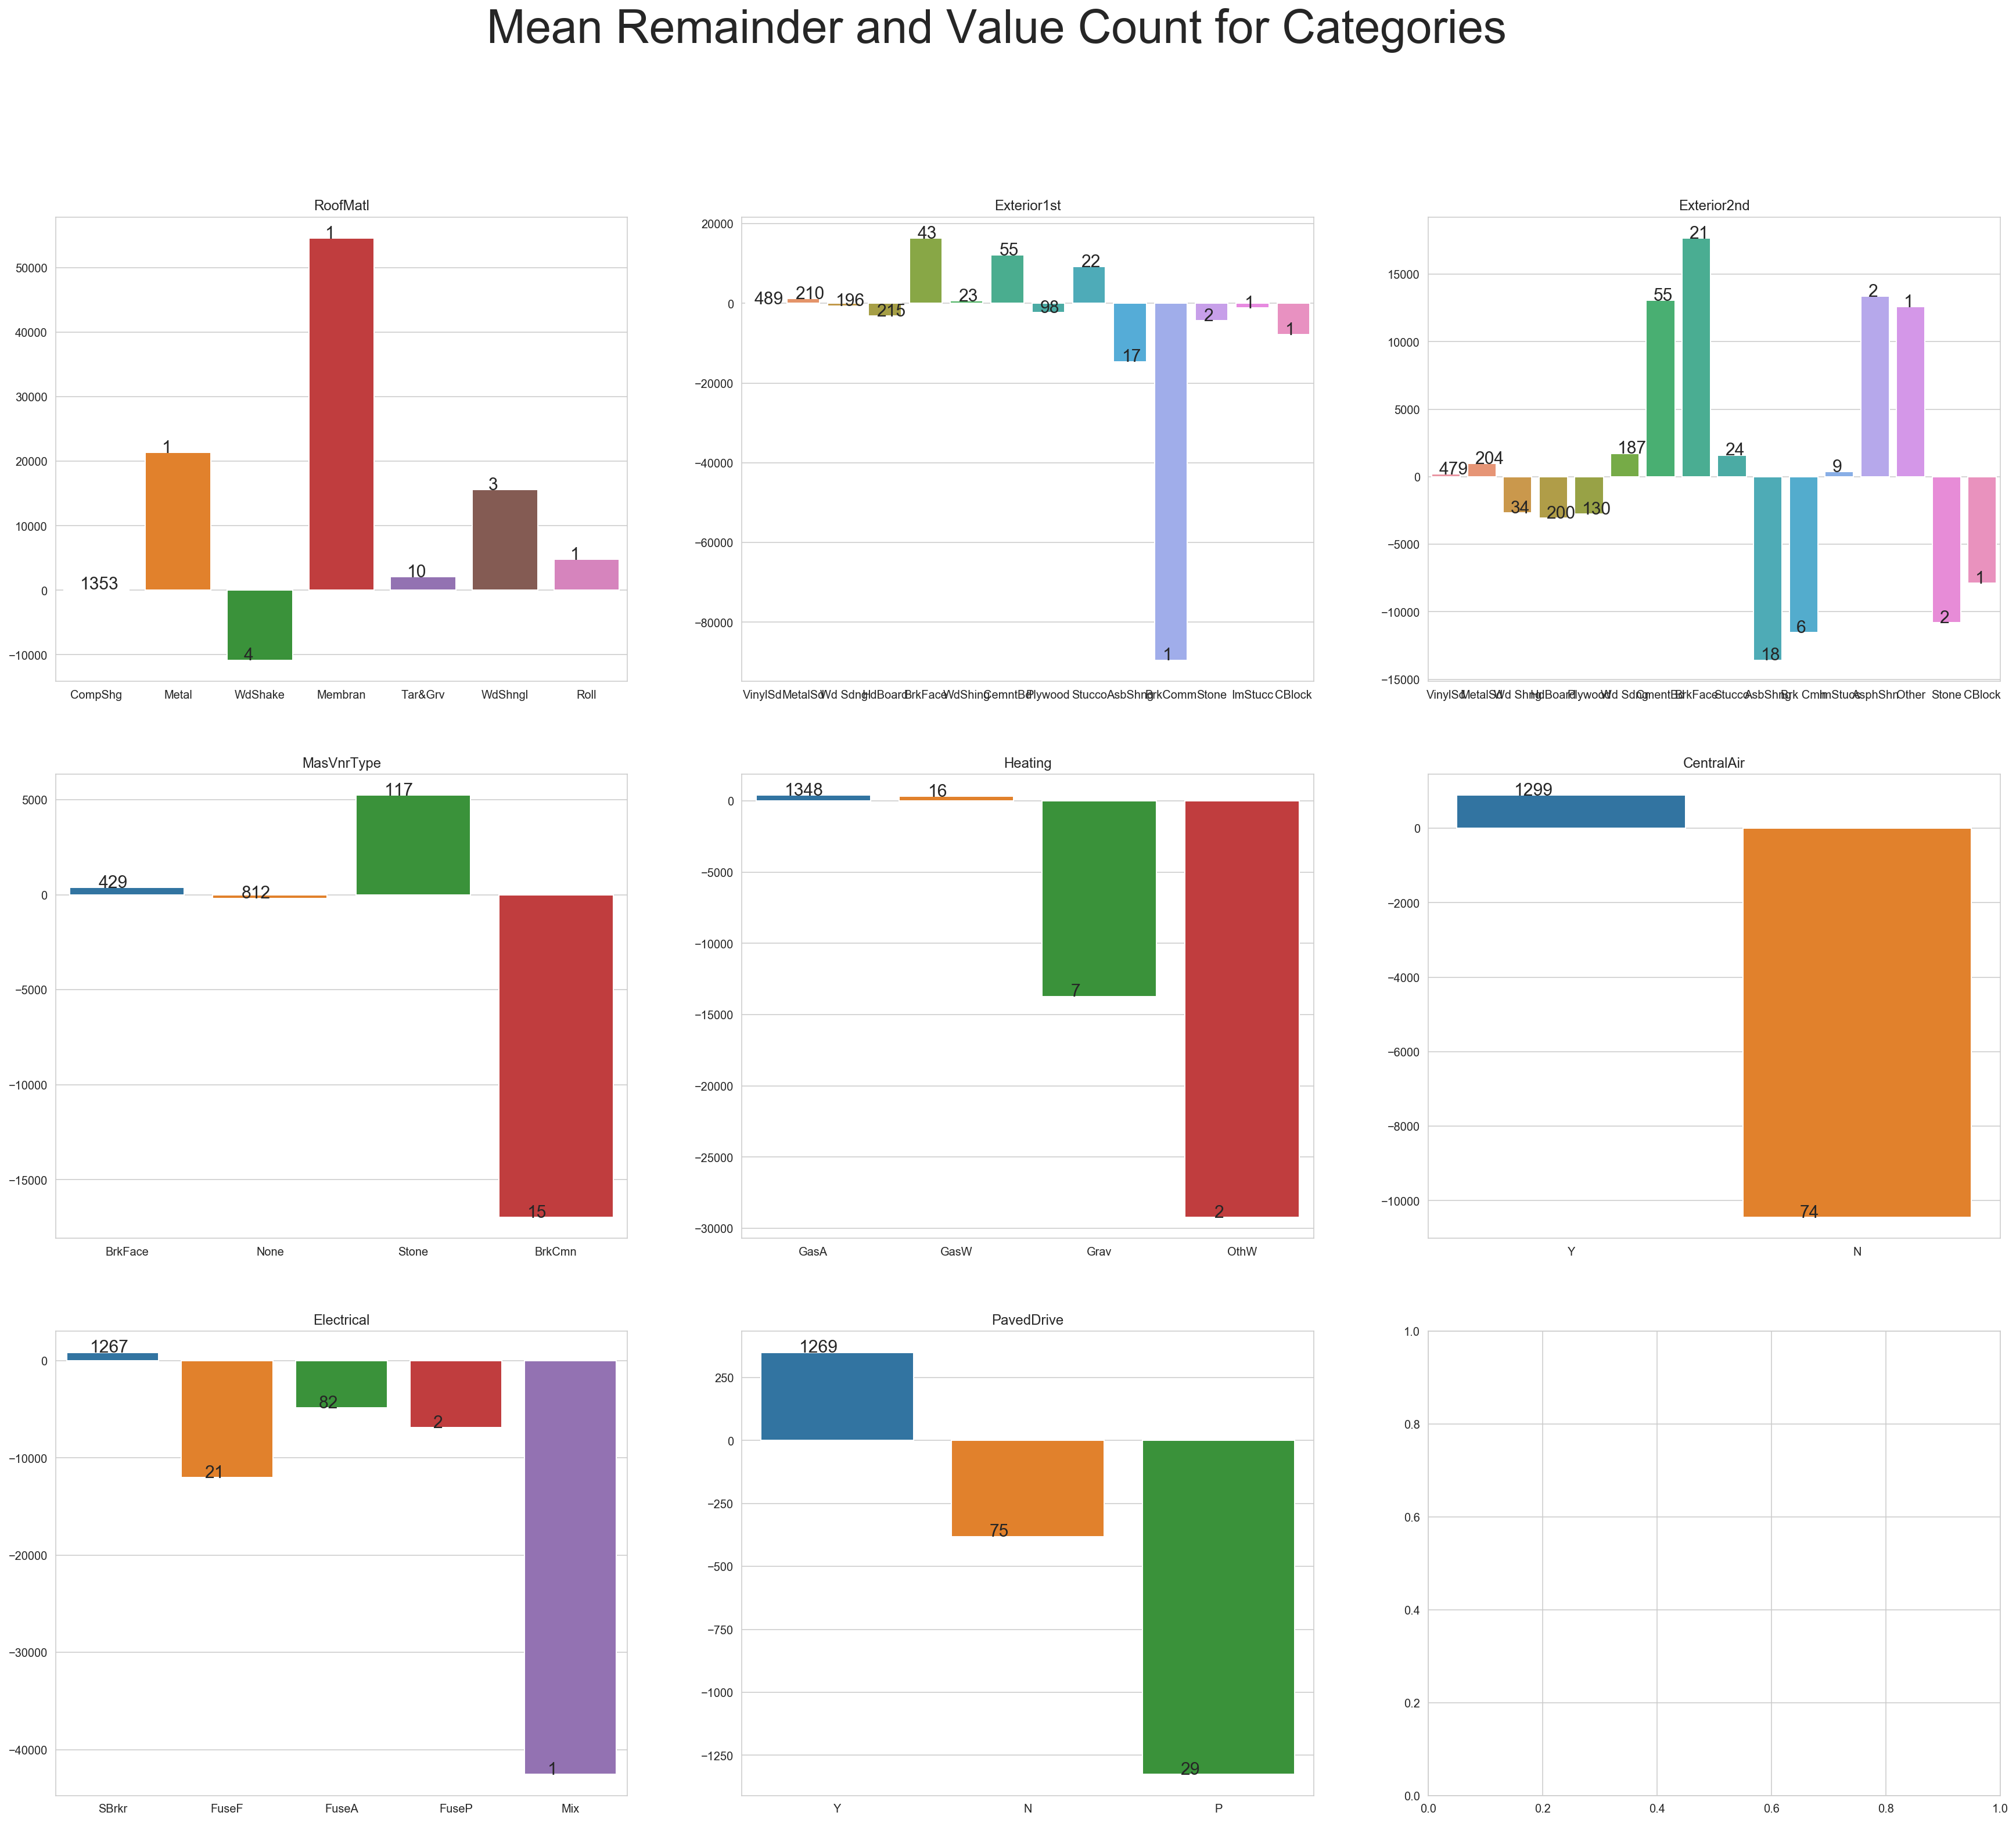

In [160]:
#Having another look at categoricals before continuing

#for category in column
#calculate mean of Remainder
#graph


fig, axes = plt.subplots(3,3, figsize=(30,25))

fig.suptitle('Mean Remainder and Value Count for Categories',fontsize=40)

graph = 1

for column in change_categorical_cols:
    categories = []
    category_means = []

    for category in change_house[column].unique():
        category_mean = change_house[change_house[column] == category].Remainder.mean()
        category_means.append(category_mean)
        categories.append(category)
        
    ax1 = plt.subplot(3,3,graph)
    sns.barplot(x=change_house[column].unique(), y=category_means, ax=ax1)
    ax1.set_title(str(column))
    
    #add count of values in category
    counter = 0
    for i in ax1.patches:
        cat = categories[counter]
        # get_x pulls left or right; get_height pushes up or down
        ax1.text(i.get_x()+0.2, i.get_height()+.5, \
                str((change_house[column] == cat).sum()), fontsize=15)
        counter += 1

    graph += 1

Exterior 1 & 2 both show good variation and sensitivity to target, although they look non-linear. 

Changing to 1 vs many or combined groupings might be good for a number of these

MasVnrType is also an exterior feature which shows potential, perhaps in conjunction with MasVnrArea somehow?

Central air is strangely not associated with an increase in price, so does not seem worth modelling, as removing a/c is probably not a reasonable renovation.

Same logic for PavedDrive - this indcates paving a driveway is not a good investment. We don't really need to know more than that.

Roof material and Heating do not have enough values in the non-dominant category to be useable.



In [161]:
for column in ['PavedDrive', 'CentralAir', 'RoofMatl', 'Heating']:
    change_categorical_cols.remove(column)
    
change_categorical_cols

['Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical']

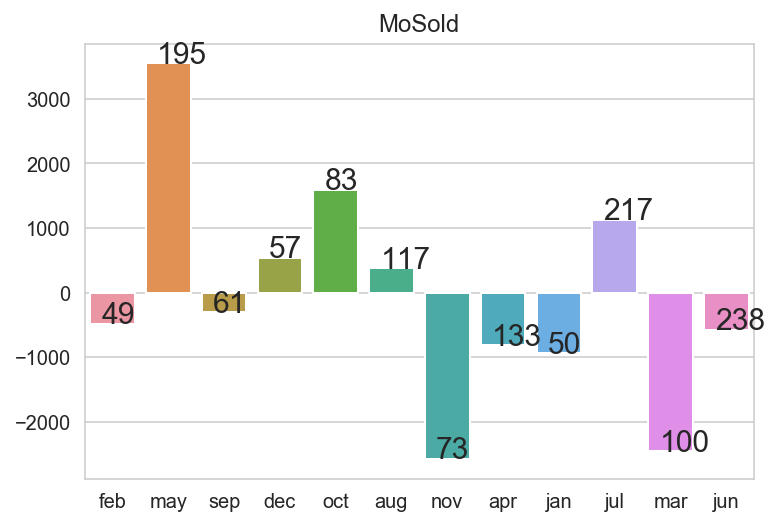

In [162]:
#What about our month variable?
column = 'MoSold'
categories = []
category_means = []

for category in change_house[column].unique():
    category_mean = change_house[change_house[column] == category].Remainder.mean()
    category_means.append(category_mean)
    categories.append(category)

# sorted_means = sorted(category_means)

fit, ax1 = plt.subplots()
sns.barplot(x=change_house[column].unique(), y=category_means, ax=ax1)
ax1.set_title(str(column))

#add count of values in category
counter = 0
for i in ax1.patches:
    cat = categories[counter]
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_x()+0.2, i.get_height()+.5, \
            str((change_house[column] == cat).sum()), fontsize=15)
    counter += 1

In [163]:
#MoSold could be useful as a categorical, although the price variation is lower than with many other variables
#What about a 3 column month option:
month_bins = []

for month in change_house.MoSold:
    if ((month == 'nov') or (month == 'mar')):
        month_bins.append('low')
    elif month == 'may':
        month_bins.append('high')
    else:
        month_bins.append('avg')

change_house['MonthBins'] = month_bins

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


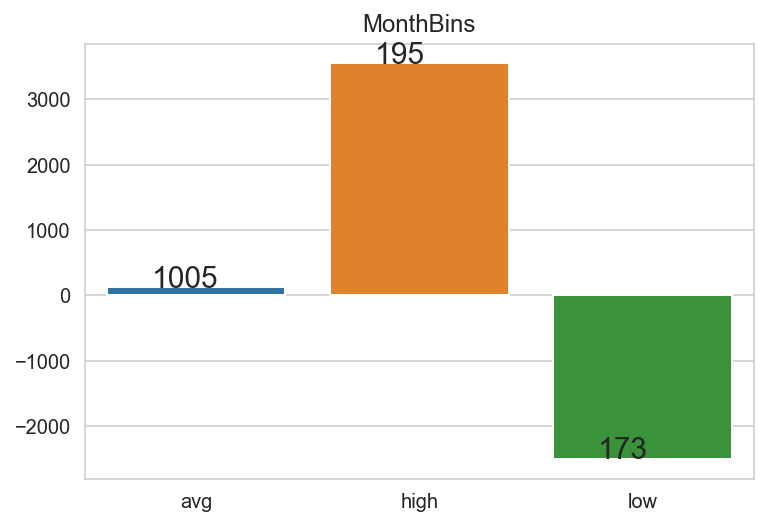

In [164]:
column = 'MonthBins'
categories = []
category_means = []

for category in change_house[column].unique():
    category_mean = change_house[change_house[column] == category].Remainder.mean()
    category_means.append(category_mean)
    categories.append(category)

fit, ax1 = plt.subplots()
sns.barplot(x=change_house[column].unique(), y=category_means, ax=ax1)
ax1.set_title(str(column))

#add count of values in category
counter = 0
for i in ax1.patches:
    cat = categories[counter]
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_x()+0.2, i.get_height()+.5, \
            str((change_house[column] == cat).sum()), fontsize=15)
    counter += 1

In [165]:
# Will test this as n ordinal option, as they now reflect high/average/low price
change_categorical_cols.append('MonthBins')

In [166]:
change_categorical_cols

['Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'MonthBins']

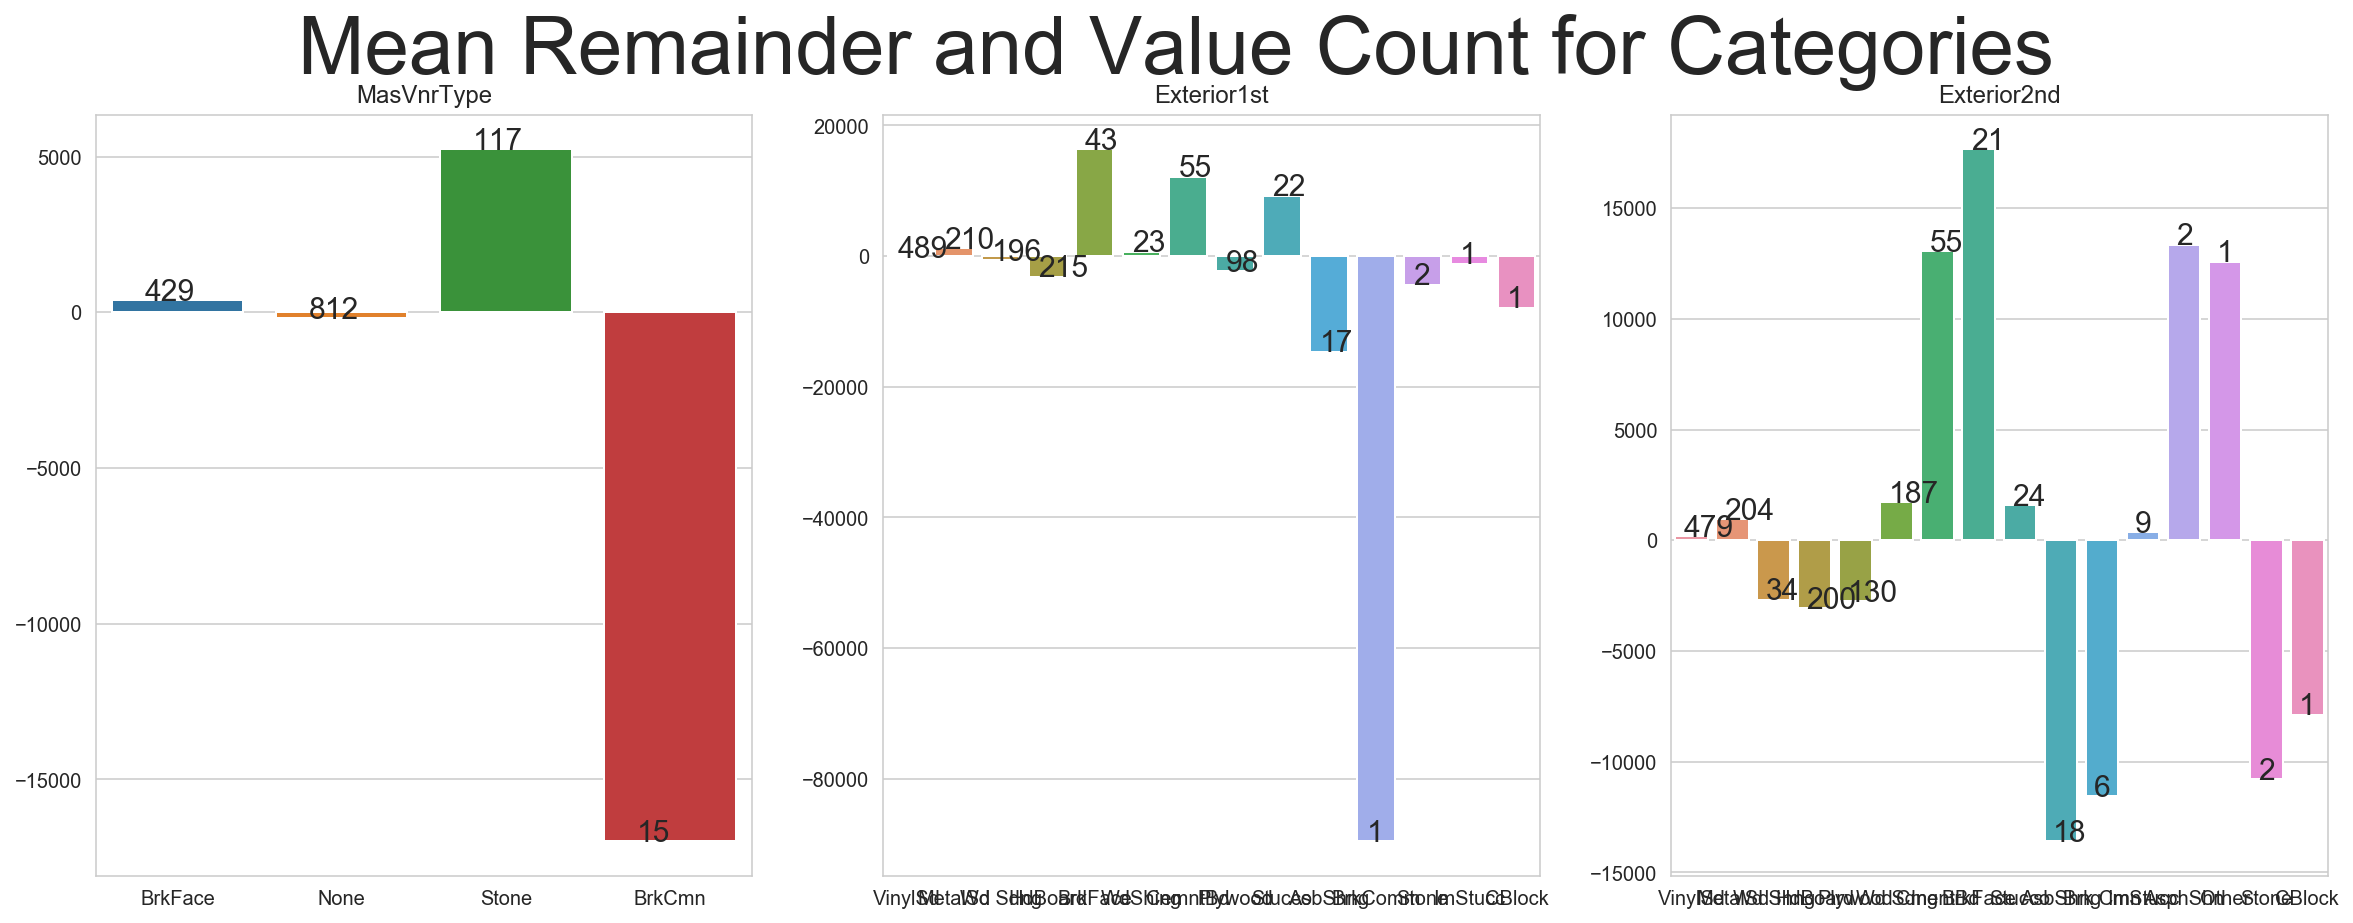

In [167]:
# The others that had potential for adjusting are: MasVnrType, Exterior1st, Exterior2nd
columns = ['MasVnrType', 'Exterior1st', 'Exterior2nd']

fig, axes = plt.subplots(3,3, figsize=(20,7))

fig.suptitle('Mean Remainder and Value Count for Categories',fontsize=40)

graph = 1

for column in columns:
    categories = []
    category_means = []

    for category in change_house[column].unique():
        category_mean = change_house[change_house[column] == category].Remainder.mean()
        category_means.append(category_mean)
        categories.append(category)
        
    ax1 = plt.subplot(1,3,graph)
    sns.barplot(x=change_house[column].unique(), y=category_means, ax=ax1)
    ax1.set_title(str(column))
    
    #add count of values in category
    counter = 0
    for i in ax1.patches:
        cat = categories[counter]
        # get_x pulls left or right; get_height pushes up or down
        ax1.text(i.get_x()+0.2, i.get_height()+.5, \
                str((change_house[column] == cat).sum()), fontsize=15)
        counter += 1

    graph += 1

In [168]:
#Dropping MasVnrType, as variation is not large enough among columns with large values
change_categorical_cols.remove('MasVnrType')

#Exterior 1st and 2nd also look concerning for modeling because, while they include a number of features 
#with signficant variation and numbers, they also include high-variance low count options

### Let's try an initial model
Definitely thinking it's too many features, but willing to have a look at this point, then adjust<br>
Doing initial testing without scaling, as it only  made a small difference in the original model

What does our model look like with just our continuous variables?

In [169]:
#calculate baseline mean squared error
mean_y_train = np.mean(y_train)
mse_baseline = np.mean([(i - mean_y_train)**2 for i in y_train])


print("Baseline mean squared error:", mse_baseline)

Baseline mean squared error: 4730618968.003764


In [170]:
change_continuous_df = change_house[change_cont_features]
change_continuous_df.columns

Index(['BsmtFinSF1', 'OutdoorSF', 'MasVnrArea', 'BsmtCombined'], dtype='object')

In [171]:
change_continuous_df = change_house[change_cont_features]
change_continuous_df.columns

Index(['BsmtFinSF1', 'OutdoorSF', 'MasVnrArea', 'BsmtCombined'], dtype='object')

In [172]:
change_continuous_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373 entries, 0 to 1459
Data columns (total 4 columns):
BsmtFinSF1      1373 non-null int64
OutdoorSF       1373 non-null int64
MasVnrArea      1373 non-null float64
BsmtCombined    1373 non-null int64
dtypes: float64(1), int64(3)
memory usage: 53.6 KB


In [173]:
X = change_continuous_df
y = change_house.Remainder

#using an 80% test/train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 4) (275, 4) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [174]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('\n','mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))

print('\n','percent difference from baseline mse')
print(((abs(np.mean(scores_train_mse)) - mse_baseline))/mse_baseline)


model = sm.OLS(y_train, X_train)
model = model.fit()
print('\n', model.summary())

Rsquared
0.06999392443728705 0.04321581489583508

 mse
-588546130.4248854 45774239.75655127

 percent difference from baseline mse
-0.8755879231860347

                             OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     21.89
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           2.12e-17
Time:                        09:52:56   Log-Likelihood:                -12646.
No. Observations:                1098   AIC:                         2.530e+04
Df Residuals:                    1094   BIC:                         2.532e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t| 

__Not great...__<br>
Only BsmtCombined strongly significant <br>

### Next up: Adding in ordinals


In [175]:
#still have nan values for FireplaceQu - leaving it out for now
change_house[change_ordinal_features].isna().sum()

BsmtCond         0
HeatingQC        0
KitchenQual      0
FireplaceQu    644
ExterQC          0
dtype: int64

In [176]:
change_ordinals_nf = change_ordinal_features.copy()
change_ordinals_nf.remove('FireplaceQu')

In [177]:
change_ordinal_nf_df = change_house[change_ordinals_nf]
change_ordinal_nf_df.columns

Index(['BsmtCond', 'HeatingQC', 'KitchenQual', 'ExterQC'], dtype='object')

In [178]:
#change_numercial should be a df of ordinal + continuous

X = pd.concat([change_continuous_df, change_ordinal_nf_df], axis = 1)

print(X.shape, y.shape)

(1373, 8) (1373,)


In [179]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 8) (275, 8) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [180]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

model = sm.OLS(y_train, X_train)
model = model.fit()
print(model.summary())

Rsquared
0.08406226594590668 0.05419662951314347
mse
-579468184.4119403 47361271.139536075
-----------------
                            OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     14.00
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           1.65e-19
Time:                        09:52:56   Log-Likelihood:                -12634.
No. Observations:                1098   AIC:                         2.528e+04
Df Residuals:                    1090   BIC:                         2.532e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [181]:
#Not seeing any reason to keep HeatingQC, BsmtCond, OutdoorSF or MasVnrArea
change_ordinal_features.remove('HeatingQC')
change_ordinals_nf.remove('HeatingQC')

change_ordinals_nf.remove('BsmtCond')

change_cont_features.remove('MasVnrArea')
change_cont_features.remove('OutdoorSF')


In [182]:
change_ordinal_nf_df = change_house[change_ordinals_nf]
change_ordinal_nf_df.columns

Index(['KitchenQual', 'ExterQC'], dtype='object')

In [183]:
change_continuous_df = change_house[change_cont_features]
change_ordinal_nf_df = change_house[change_ordinals_nf]
X = pd.concat([change_continuous_df, change_ordinal_nf_df], axis = 1)

print(X.shape, y.shape)

(1373, 4) (1373,)


In [184]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 4) (275, 4) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [185]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

#adding contstand for stats_models
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
model = model.fit()
print(model.summary())

Rsquared
0.0894970385517569 0.05935792397939297
mse
-576170062.8418236 51317905.4355848
-----------------
                            OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     33.29
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           3.16e-26
Time:                        09:52:56   Log-Likelihood:                -12625.
No. Observations:                1098   AIC:                         2.526e+04
Df Residuals:                    1093   BIC:                         2.528e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


__Rsquared is improving__ <br>
These three columns show reasonable significance. Let's see if categoricals help any.

In [186]:
X_numeric = pd.concat([change_continuous_df, change_ordinal_nf_df], axis = 1)

In [187]:
change_categorical_cols

['Exterior1st', 'Exterior2nd', 'Electrical', 'MonthBins']

In [188]:
#testing MonthBins first
change_dummies = pd.get_dummies(change_house['MonthBins'], drop_first=True)
change_dummies.columns

Index(['high', 'low'], dtype='object')

In [189]:
X = pd.concat([X_numeric, change_dummies], axis = 1)

In [190]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 6) (275, 6) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [191]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

#adding contstand for stats_models
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
model = model.fit()
print('\n', model.summary())

Rsquared
0.09264514070201754 0.05679369830697861
mse
-574085067.4025917 48899557.20018408
-----------------

                             OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     23.42
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           3.98e-26
Time:                        09:52:56   Log-Likelihood:                -12621.
No. Observations:                1098   AIC:                         2.526e+04
Df Residuals:                    1091   BIC:                         2.529e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [192]:
#maybe useful, adding in Electrical
change_dummies = pd.get_dummies(change_house[['MonthBins','Electrical']], drop_first=True)
change_dummies.columns

Index(['MonthBins_high', 'MonthBins_low', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr'],
      dtype='object')

In [193]:
X = pd.concat([X_numeric, change_dummies], axis = 1)

In [194]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 10) (275, 10) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [195]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

#adding contstand for stats_models
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
model = model.fit()
print('\n', model.summary())

Rsquared
0.08904121856172875 0.05905625950166299
mse
-576478804.8153038 51385924.09129217
-----------------

                             OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     14.28
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           5.31e-24
Time:                        09:52:56   Log-Likelihood:                -12620.
No. Observations:                1098   AIC:                         2.526e+04
Df Residuals:                    1087   BIC:                         2.532e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [196]:
#not great improvement, and hard to interpret
#testing adding Exterior1st
change_dummies = pd.get_dummies(change_house[['MonthBins','Electrical','Exterior1st']], drop_first=True)
change_dummies.columns

Index(['MonthBins_high', 'MonthBins_low', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc',
       'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing'],
      dtype='object')

In [197]:
X = pd.concat([X_numeric, change_dummies], axis = 1)

In [198]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1098, 23) (275, 23) (1098,) (275,)


In [199]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

#adding contstand for stats_models
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
model = model.fit()
print('\n', model.summary())

Rsquared
0.11313209225837781 0.07869475457608975
mse
-560881233.2147443 56626866.88228785
-----------------

                             OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     9.915
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           9.45e-31
Time:                        09:52:56   Log-Likelihood:                -12586.
No. Observations:                1098   AIC:                         2.522e+04
Df Residuals:                    1075   BIC:                         2.533e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [200]:
#as we add in exterior features, ExterQC loses significance - it would make sense that it would interact
#need to decide between dummies or ExterQC - will remove ExterQC and see what it does
num_df = change_house[['BsmtCombined','KitchenQual']]

In [201]:
X = pd.concat([num_df, change_dummies], axis = 1)

In [202]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 21) (275, 21) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [203]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

#adding contstand for stats_models
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
model = model.fit()
print('\n', model.summary())

Rsquared
0.1068039863101626 0.0789461522560235
mse
-564690691.2288206 54858699.143411905
-----------------

                             OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     10.26
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           1.42e-29
Time:                        09:52:57   Log-Likelihood:                -12592.
No. Observations:                1098   AIC:                         2.523e+04
Df Residuals:                    1077   BIC:                         2.533e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [204]:
#seems better without this feature
#last option to add: Exterior2nd
change_dummies = pd.get_dummies(change_house[['MonthBins','Electrical','Exterior1st','Exterior2nd']], drop_first=True)
change_dummies.columns

Index(['MonthBins_high', 'MonthBins_low', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc',
       'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn',
       'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd',
       'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd',
       'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone',
       'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
       'Exterior2nd_Wd Shng'],
      dtype='object')

In [205]:
X = pd.concat([num_df, change_dummies], axis = 1)

In [206]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 36) (275, 36) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [207]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

#adding contstand for stats_models
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
model = model.fit()
print('\n', model.summary())

Rsquared
0.07486921548167816 0.057851034798481894
mse

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)



-584852317.1775204 43558822.632851675
-----------------

                             OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     6.372
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           2.03e-25
Time:                        09:52:57   Log-Likelihood:                -12586.
No. Observations:                1098   AIC:                         2.524e+04
Df Residuals:                    1063   BIC:                         2.542e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

__That made things a lot worse__

Not surprising - too many external features are likely to be overalpping. One more check of what happens if we remove Electircal 

In [208]:
#last option to add: Removing Electrical - in the best model so far it was not showing significance
change_dummies = pd.get_dummies(change_house[['MonthBins','Exterior1st']], drop_first=True)
change_dummies.columns

Index(['MonthBins_high', 'MonthBins_low', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing'],
      dtype='object')

In [209]:
X = pd.concat([num_df, change_dummies], axis = 1)

In [210]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 17) (275, 17) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [211]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

#adding contstand for stats_models
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
model = model.fit()
print('\n', model.summary())

Rsquared
0.11198232094223455 0.07562388732434086
mse
-561371007.1089721 52389786.80488346
-----------------

                             OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     12.59
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           5.63e-31
Time:                        09:52:57   Log-Likelihood:                -12594.
No. Observations:                1098   AIC:                         2.522e+04
Df Residuals:                    1081   BIC:                         2.531e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### This looks like our best model
Still some concerning indicators, but most coefficients have higher significance, and Rsquared is best

Included features:
* BsmtCombined (sq of quality basement area)
* KitchenQual
* MonthBins
* Exterior1st

Will do a quick look at Ridge and Lasso to see if one looks better


In [212]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [213]:
#resetting X to best model
change_dummies = pd.get_dummies(change_house[['MonthBins', 'Exterior1st']], drop_first=True)
change_dummies.columns

Index(['MonthBins_high', 'MonthBins_low', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing'],
      dtype='object')

In [214]:
X = pd.concat([num_df, change_dummies], axis = 1)

In [220]:
#using an 80% test/train split ~ 1130 rows in test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=14)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1098, 17) (275, 17) (1098,) (275,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [221]:
lr = LinearRegression()

scores_train_r2 = cross_val_score(lr, X_train, y_train, scoring = 'r2', cv=5)
print('Rsquared')
print(np.mean(scores_train_r2),np.std(scores_train_r2))

scores_train_mse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
print('mse')
print(np.mean(scores_train_mse),np.std(scores_train_mse))
print('-----------------')

#adding contstand for stats_models
Xsm_train = sm.add_constant(X_train)
model = sm.OLS(y_train, Xsm_train)
model = model.fit()
print('\n', model.summary())

Rsquared
0.11198232094223455 0.07562388732434086
mse
-561371007.1089721 52389786.80488346
-----------------

                             OLS Regression Results                            
Dep. Variable:              Remainder   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     12.59
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           5.63e-31
Time:                        09:55:15   Log-Likelihood:                -12594.
No. Observations:                1098   AIC:                         2.522e+04
Df Residuals:                    1081   BIC:                         2.531e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [222]:
#trying Ridge
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
r_scores = cross_val_score(ridge, X_train, y_train, scoring = 'r2', cv=5)
print(r_scores)
print(np.mean(r_scores),np.std(r_scores))


[0.14224271 0.04204619 0.01939618 0.17898754 0.18559122]
0.11365276741309491 0.06967490706792778


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [223]:
#and Lasso
lasso = Lasso()

l_scores = cross_val_score(lasso, X_train, y_train, scoring = 'r2', cv=5)
print(l_scores)
print(np.mean(l_scores),np.std(r_scores))

[0.15081314 0.02894672 0.01446965 0.19806067 0.16804676]
0.11206738912527572 0.06967490706792778


Again, both are showing very similar results <br>
Running with Ridge on test data to looking at residuals now

In [226]:
ridge.fit(X_train, y_train)
ridge.score(X_test,y_test)

0.08837086057004673

In [ ]:
predictions = ridge.predict(X_test)
y_hat = y_test - predictions

### Let's see how it looks!!

In [ ]:
#Are the residuals normally distributed?
#Not quite, but given that we've skipped half the features, it's not too bad
sns.distplot(y_hat, fit=stats.norm)

In [ ]:
#How does our linear relationship look?
fig, ax = plt.subplots()
sns.scatterplot(y_test,predictions)

ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')

In [ ]:
#Our overall model looks good from the perspective of evenly distributed residuals
sns.jointplot(y_test,predictions)


In [ ]:
#There is a definite linear relationship between y_hat and our target, which is a concern
ax = sns.scatterplot(x = y_test, y = y_hat)
ax.set_ylabel('Error')


In [ ]:
columns = X_test.columns
coefs = list(ridge.coef_)

results = pd.DataFrame(coefs, columns)
results = results.reset_index()
results.columns = ['Feature', 'Coef Value']

#grabbing significance from stats models
results['P>|t|'] = [0.000, 0.000, 0.183, 0.103, 0.000, 0.578, 0.000, 0.018, 0.000, 
                    0.095, 0.000, 0.000, 0.061, 0.460, 0.000, 0.000, 0.018]
results

# Conclusions

Slightly over 10% of the remaining price variance after accounting for fixed features can be explained through this model. The following options are indicated by the model as potential revenue generators:

1. __Remodelling a basement__ can add value, but it only adds __\$3 per sqft__, so it would need to be a big basement to start to provide a return
2. Each __grade change in Kitchen Quality__ ladder provides an estimated __$6570 increase in sale price__. Depending on the cost of the upgrade, may need to have room to go up multiple steps to get a return on investment.
3. __Changing the exterior covering__ on the house could provide a return, depending on the change. The majority of siding types do show statistical significance in this model. The model should not be used to evaluate the following options, as they do not meet stastical thresholds: Brick Face and Stucco show virtually no significance in this model. Care should be taken when considering Immitation Stucco and Stone, as they meet a 90% confidence threshold, but not 95%. Cement Board and Wood Shingles are significant to 98%. Other siding over 99%. To use this model as a purchasing strategy, we look to buy and sell houses with the following sidings, listed accoring to price potential.
    * Buy: Brick Common, Vinyl Siding, Plywood, Hard Board, and Plywood. Immitation Stucco and Stone also show potential, but as mentioned previously, the model is not as strong in predicting values for those sidings.
    * Convert: For maximum return, we would convert the siding to Metal Siding, Wood Siding, or Cement Board.
    
    
4. The model indicates a potential value in aiming to buy and sell in certain months, but is not robust in this area, with a significance of 80-89% depending on the month category. Although this may be worth further investigation, it is not a good focus based on this model.

But, given that the model only explains 10% more variance than the baseline of the median price, there is alo risk that the unexplained factors will overwhelm improvements. A good strategy would be to aim for the options generating higher returns (low priced siding to high priced siding; low quality kitchen to high quality kitchen) rather than considering middle options that provide lesser returns, so will be less likely to cover the associated project risk.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.